In [1]:
#!/usr/bin/env python3
import os
import sys
import time
import sqlite3
import requests
import cot_reports as cot
import pandas as pd
import ccxt
import json
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score




/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Loaded 5939 records from the database.
Requesting: https://community-api.coinmetrics.io/v4/timeseries/asset-metrics?assets=btc&frequency=1d&metrics=PriceUSD%2CSplyCur&start_time=2025-04-05&end_time=2025-07-14
Fetched 1 new records.
Database updated. Now have 5940 total records.
Regression results:
  Slope: 2.9139192293125005
  Intercept: -1.0208223239613288
  RMSE: 0.5771160790181514
  R¬≤: 0.9525896588368667
  e2intc: 0.3602985362001874
  e2rmse: 1.7808950571515505


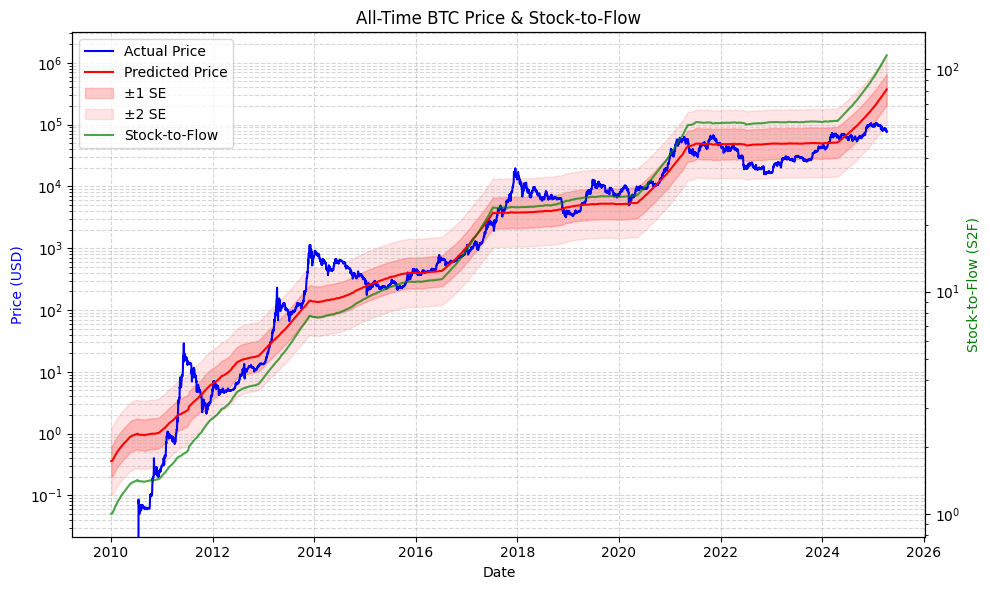

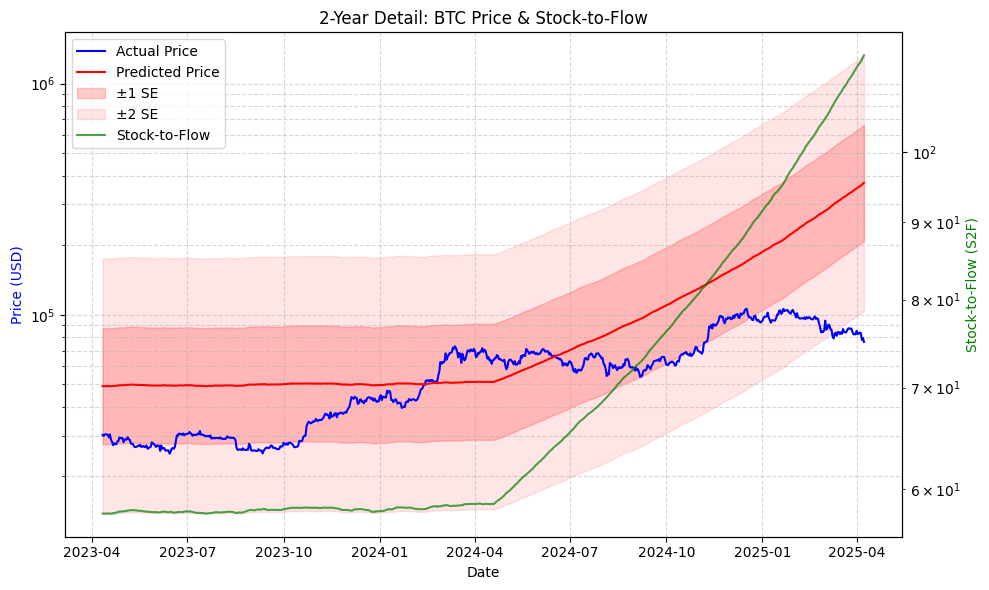

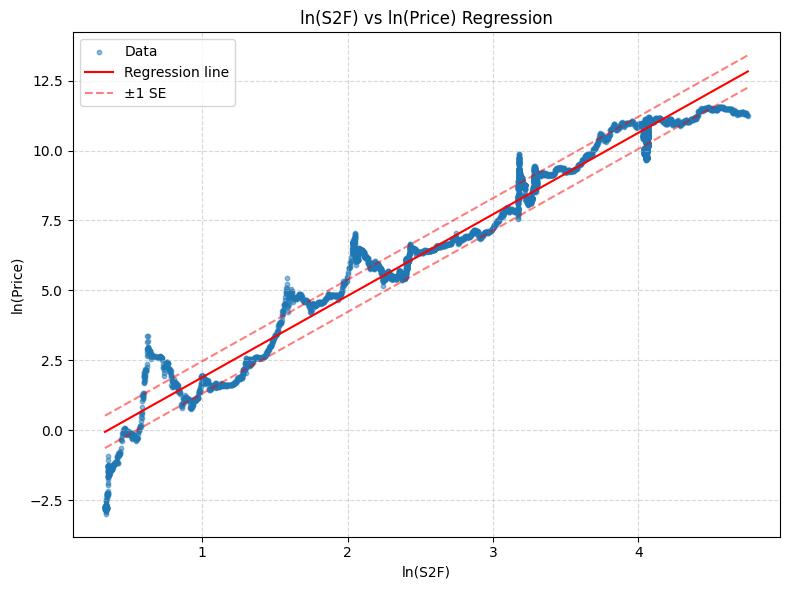

–ú–æ–¥–µ–ª—å Stock-t–æ-Flow:
–ü–æ—Å–ª–µ–¥–Ω—è—è –¥–∞—Ç–∞:		2025-04-08
–¶–µ–Ω–∞ –Ω–∞ —ç—Ç—É –¥–∞—Ç—É:		76351.43
–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω–∞—è —Ü–µ–Ω–∞:	372277.70
–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω–∞—è √ó 1SE:	662987.51
–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω–∞—è √∑ 1SE:	209039.66
–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω–∞—è √ó 2SE:	1325975.02
–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω–∞—è √∑ 2SE:	104519.83


In [2]:
# ----------------------------------------------------------------------
# 1. Database and Data Loading
# ----------------------------------------------------------------------

# Create the directory if it doesn't exist
#os.makedirs("daily_report", exist_ok=True)

DB_PATH = "bcinfo.sqlite"

conn = sqlite3.connect(DB_PATH)
cur = conn.cursor()

# Ensure table exists
cur.execute('SELECT count(name) FROM sqlite_master WHERE type="table" AND name="btc"')
if cur.fetchone()[0] == 0:
    cur.execute('CREATE TABLE btc (date INTEGER PRIMARY KEY, price REAL, coins REAL)')
    conn.commit()

# Load all data
cur.execute('SELECT * FROM btc ORDER BY date')
bstr = cur.fetchall()
print(f"Loaded {len(bstr)} records from the database.")

# Determine the last date in our records (as day count)
if bstr:
    maxdt = bstr[-1][0]
else:
    # Default start date if DB is empty: 2013-01-10
    maxdt = int(datetime.strptime("2013-01-10", "%Y-%m-%d").timestamp() / 86400)

# ----------------------------------------------------------------------
# 2. Fetch New Data (Always)
# ----------------------------------------------------------------------

def fetch_new_data(start_day):
    """Fetch new BTC data from CoinMetrics starting from start_day."""
    today = int(datetime.now().timestamp() / 86400)
    loopval = start_day - 2
    new_entries = []
    burl = "https://community-api.coinmetrics.io/v4/timeseries/asset-metrics"
    bapistr = "?assets=btc&frequency=1d&metrics=PriceUSD%2CSplyCur&start_time="
    curstock = 0

    while loopval <= today:
        startdate = datetime.fromtimestamp(loopval * 86400).strftime('%F')
        enddate   = datetime.fromtimestamp((loopval + 100) * 86400).strftime('%F')
        url = burl + bapistr + startdate + "&end_time=" + enddate
        print("Requesting:", url)

        # Rate-limit handling
        max_retries = 5
        retries = 0
        resp = requests.get(url)
        while resp.status_code == 429 and retries < max_retries:
            retry_after = resp.headers.get("Retry-After")
            wait_time = int(retry_after) if retry_after else 60
            print(f"429 rate limit. Waiting {wait_time} seconds...")
            time.sleep(wait_time)
            resp = requests.get(url)
            retries += 1

        if resp.status_code != 200:
            print(f"Failed to fetch data (HTTP {resp.status_code}). Stopping.")
            break

        data_json = resp.json()
        for bd in data_json.get("data", []):
            if bd["PriceUSD"] is None:
                bd["PriceUSD"] = 0
            if bd["SplyCur"] is None:
                bd["SplyCur"] = 0
            if float(bd["SplyCur"]) < curstock:
                # Ensure supply is non-decreasing
                continue
            curstock = float(bd["SplyCur"])
            epdate = int(
                float(
                    datetime.strptime(
                        bd["time"], "%Y-%m-%dT%H:%M:%S.000000000Z"
                    ).strftime("%s")
                )
                / 86400
                + 0.5
            )
            if epdate <= start_day:
                continue
            new_entries.append((epdate, float(bd["PriceUSD"]), float(bd["SplyCur"])))
        loopval += 98

    return new_entries

# Always fetch new data on script run
new_data = fetch_new_data(maxdt)
print(f"Fetched {len(new_data)} new records.")
for row in new_data:
    cur.execute("INSERT OR REPLACE INTO btc VALUES (?, ?, ?)", row)
conn.commit()

# Reload data and sort
cur.execute('SELECT * FROM btc ORDER BY date')
bstr = cur.fetchall()
print(f"Database updated. Now have {len(bstr)} total records.")

conn.close()

# ----------------------------------------------------------------------
# 3. Compute Stock-to-Flow (S2F) and Prepare for Regression
# ----------------------------------------------------------------------

if len(bstr) < 366:
    print("Not enough data to compute stock-to-flow. Exiting.")
    sys.exit(0)

dates_sec = []
price_list = []
sf_list = []

ln_s2f = []
ln_price = []

for i in range(365, len(bstr)):
    d_now, p_now, c_now = bstr[i]
    d_prev, p_prev, c_prev = bstr[i-365]

    diff = c_now - c_prev
    if diff <= 0:
        continue
    s2f = c_now / diff
    if s2f <= 0:
        continue

    dates_sec.append(d_now * 86400)
    price_list.append(p_now)
    sf_list.append(s2f)

    if p_now > 0:
        ln_s2f.append([np.log(s2f)])
        ln_price.append([np.log(p_now)])

if len(ln_s2f) == 0 or len(ln_price) == 0:
    print("No valid data for log-log regression.")
    sys.exit(0)

# ----------------------------------------------------------------------
# 4. Perform the Log-Log Regression
# ----------------------------------------------------------------------
model = LinearRegression()
model.fit(ln_s2f, ln_price)
lnpr_pred = model.predict(ln_s2f)

rmse = mean_squared_error(ln_price, lnpr_pred)
r2   = r2_score(ln_price, lnpr_pred)
slope     = model.coef_[0][0]
intercept = model.intercept_[0]

e2intc = np.exp(intercept)
e2rmse = np.exp(rmse)

print("Regression results:")
print("  Slope:", slope)
print("  Intercept:", intercept)
print("  RMSE:", rmse)
print("  R¬≤:", r2)
print("  e2intc:", e2intc)
print("  e2rmse:", e2rmse)

pred_price = []
pred_1up   = []
pred_1dn   = []
pred_2up   = []
pred_2dn   = []

for sf_val in sf_list:
    base = e2intc * (sf_val**slope)
    one_up = base * e2rmse
    one_dn = base / e2rmse
    two_up = one_up * 2
    two_dn = one_dn / 2

    pred_price.append(base)
    pred_1up.append(one_up)
    pred_1dn.append(one_dn)
    pred_2up.append(two_up)
    pred_2dn.append(two_dn)

dates = [datetime.fromtimestamp(t) for t in dates_sec]

# ----------------------------------------------------------------------
# 5. Plot 1: All-Time Price & Stock-to-Flow
# ----------------------------------------------------------------------
fig1, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel("Date")
ax1.set_ylabel("Price (USD)", color="blue")
ax1.set_yscale("log")
ax1.plot(dates, price_list, color="blue", label="Actual Price")

ax1.plot(dates, pred_price, color="red", label="Predicted Price")
ax1.fill_between(dates, pred_1dn, pred_1up, color="red", alpha=0.2, label="¬±1 SE")
ax1.fill_between(dates, pred_2dn, pred_2up, color="red", alpha=0.1, label="¬±2 SE")

ax2 = ax1.twinx()
ax2.set_ylabel("Stock-to-Flow (S2F)", color="green")
ax2.set_yscale("log")
ax2.plot(dates, sf_list, color="green", alpha=0.7, label="Stock-to-Flow")

ax1.set_title("All-Time BTC Price & Stock-to-Flow")
ax1.grid(True, which="both", linestyle="--", alpha=0.5)

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.tight_layout()
plt.savefig("all_time_price_s2f.png", dpi=300)
plt.show()


# ----------------------------------------------------------------------
# 6. Plot 2: 2-Year Detail (Zoom on Last 2 Years)
# ----------------------------------------------------------------------
two_years_ago = datetime.now() - timedelta(days=730)

dates_2yr = []
price_2yr = []
sf_2yr    = []
pred_p2yr = []
pred_1u2yr= []
pred_1d2yr= []
pred_2u2yr= []
pred_2d2yr= []

for d, p, s, base, u1, d1, u2, d2 in zip(dates, price_list, sf_list,
                                        pred_price, pred_1up, pred_1dn,
                                        pred_2up, pred_2dn):
    if d >= two_years_ago:
        dates_2yr.append(d)
        price_2yr.append(p)
        sf_2yr.append(s)
        pred_p2yr.append(base)
        pred_1u2yr.append(u1)
        pred_1d2yr.append(d1)
        pred_2u2yr.append(u2)
        pred_2d2yr.append(d2)

fig2, ax3 = plt.subplots(figsize=(10, 6))

ax3.set_xlabel("Date")
ax3.set_ylabel("Price (USD)", color="blue")
ax3.set_yscale("log")
ax3.plot(dates_2yr, price_2yr, color="blue", label="Actual Price")
ax3.plot(dates_2yr, pred_p2yr, color="red", label="Predicted Price")
ax3.fill_between(dates_2yr, pred_1d2yr, pred_1u2yr, color="red", alpha=0.2, label="¬±1 SE")
ax3.fill_between(dates_2yr, pred_2d2yr, pred_2u2yr, color="red", alpha=0.1, label="¬±2 SE")

ax4 = ax3.twinx()
ax4.set_ylabel("Stock-to-Flow (S2F)", color="green")
ax4.set_yscale("log")
ax4.plot(dates_2yr, sf_2yr, color="green", alpha=0.7, label="Stock-to-Flow")

ax3.set_title("2-Year Detail: BTC Price & Stock-to-Flow")
ax3.grid(True, which="both", linestyle="--", alpha=0.5)

lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax4.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc="best")

plt.tight_layout()
plt.savefig("all_time_price_s2f_2Ydetail.png", dpi=300)
plt.show()

# ----------------------------------------------------------------------
# 7. Plot 3: ln(S2F) vs. ln(Price) with Regression
# ----------------------------------------------------------------------
ln_s2f_array = np.array(ln_s2f).reshape(-1)
ln_price_array = np.array(ln_price).reshape(-1)

min_x = ln_s2f_array.min()
max_x = ln_s2f_array.max()
x_line = np.linspace(min_x, max_x, 200)
y_line = intercept + slope * x_line

# ¬±1SE lines in log space
y_line_up = y_line + rmse
y_line_dn = y_line - rmse

fig3, ax5 = plt.subplots(figsize=(8, 6))
ax5.scatter(ln_s2f_array, ln_price_array, s=10, alpha=0.5, label="Data")
ax5.plot(x_line, y_line, "r-", label="Regression line")
ax5.plot(x_line, y_line_up, "r--", alpha=0.5, label="¬±1 SE")
ax5.plot(x_line, y_line_dn, "r--", alpha=0.5)

ax5.set_xlabel("ln(S2F)")
ax5.set_ylabel("ln(Price)")
ax5.set_title("ln(S2F) vs ln(Price) Regression")
ax5.grid(True, linestyle="--", alpha=0.5)
ax5.legend()

plt.tight_layout()
plt.savefig("S2F_Price.png", dpi=300)
plt.show()

# ----------------------------------------------------------------------
# 8. Print Final Summary
# ----------------------------------------------------------------------

# Get the last values from each list
last_date = dates[-1].strftime('%Y-%m-%d')  # Convert datetime to a nice string
last_price = price_list[-1]
last_pred = pred_price[-1]
last_pred_1up = pred_1up[-1]
last_pred_1dn = pred_1dn[-1]
last_pred_2up = pred_2up[-1]
last_pred_2dn = pred_2dn[-1]

S2F_now = f"""
–ú–æ–¥–µ–ª—å Stock-t–æ-Flow:
–ü–æ—Å–ª–µ–¥–Ω—è—è –¥–∞—Ç–∞:\t\t{last_date}
–¶–µ–Ω–∞ –Ω–∞ —ç—Ç—É –¥–∞—Ç—É:\t\t{last_price:.2f}
–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω–∞—è —Ü–µ–Ω–∞:\t{last_pred:.2f}
–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω–∞—è √ó 1SE:\t{last_pred_1up:.2f}
–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω–∞—è √∑ 1SE:\t{last_pred_1dn:.2f}
–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω–∞—è √ó 2SE:\t{last_pred_2up:.2f}
–ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–Ω–∞—è √∑ 2SE:\t{last_pred_2dn:.2f}
""".strip()

print(S2F_now)


In [3]:
import requests

def get_btc_price_binance():
    url = "https://api.binance.com/api/v3/ticker/price?symbol=BTCUSDT"
    response = requests.get(url)
    data = response.json()
    return float(data["price"])

btc_price = get_btc_price_binance()
btc_price



# Get the latest adjusted close price
latest_price = btc_price

# Define key dates
start_date = datetime(2024, 4, 19)
next_halving = datetime(2028, 3, 24)

# Calculate projected cycle dates
bull_range_start = start_date + timedelta(days=367)
bull_range_end = start_date + timedelta(days=548)
logistic_growth_end = start_date + timedelta(days=550)
linear_growth_end = start_date + timedelta(days=661)

bottom_start = next_halving - timedelta(days=548)
bottom_end = next_halving - timedelta(days=513)

# Print the formatted output
CYCLE_MODELS_HTML = f"""
<p>–¢–µ–∫—É—â–∏–π –±—ã—á–∏–π —Ç—Ä–µ–Ω–¥, –ø–æ –ø—Ä–æ–≥–Ω–æ–∑–∞–º, –∑–∞–≤–µ—Ä—à–∏—Ç—Å—è:</p>
<ul>
    <li>–ù–∞ –æ—Å–Ω–æ–≤–µ –ø—Ä–µ–¥—ã–¥—É—â–∏—Ö –±—ã—á—å–∏—Ö —Ü–∏–∫–ª–æ–≤ (–¥–∏–∞–ø–∞–∑–æ–Ω): {bull_range_start.strftime('%Y-%m-%d')} - {bull_range_end.strftime('%Y-%m-%d')}</li>
    <li>–ï—Å–ª–∏ —Ü–∏–∫–ª –ø—Ä–æ–¥–ª–∏—Ç—Å—è (–ª–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–∏–π —Ä–æ—Å—Ç): {logistic_growth_end.strftime('%Y-%m-%d')}</li>
    <li>–ï—Å–ª–∏ —Ü–∏–∫–ª –ø—Ä–æ–¥–ª–∏—Ç—Å—è (–ª–∏–Ω–µ–π–Ω—ã–π —Ä–æ—Å—Ç): {linear_growth_end.strftime('%Y-%m-%d')}</li>
</ul>
<p>–û–∂–∏–¥–∞–µ—Ç—Å—è, —á—Ç–æ –¥–Ω–æ —ç—Ç–æ–≥–æ —Ü–∏–∫–ª–∞ –Ω–∞—Å—Ç—É–ø–∏—Ç:</p>
<ul>
    <li>(–∑–∞ 513-548 –¥–Ω–µ–π –Ω–∞–∑–∞–¥ –æ—Ç –±–ª–∏–∂–∞–π—à–µ–≥–æ —Ö–∞–ª–≤–∏–Ω–≥–∞ ‚Äî –Ω–∞ –æ—Å–Ω–æ–≤–µ –ø—Ä–µ–¥—ã–¥—É—â–∏—Ö –º–∏–Ω–∏–º—É–º–æ–≤): {bottom_start.strftime('%Y-%m-%d')} - {bottom_end.strftime('%Y-%m-%d')}</li>
</ul>
"""
print(CYCLE_MODELS_HTML)



<p>–¢–µ–∫—É—â–∏–π –±—ã—á–∏–π —Ç—Ä–µ–Ω–¥, –ø–æ –ø—Ä–æ–≥–Ω–æ–∑–∞–º, –∑–∞–≤–µ—Ä—à–∏—Ç—Å—è:</p>
<ul>
    <li>–ù–∞ –æ—Å–Ω–æ–≤–µ –ø—Ä–µ–¥—ã–¥—É—â–∏—Ö –±—ã—á—å–∏—Ö —Ü–∏–∫–ª–æ–≤ (–¥–∏–∞–ø–∞–∑–æ–Ω): 2025-04-21 - 2025-10-19</li>
    <li>–ï—Å–ª–∏ —Ü–∏–∫–ª –ø—Ä–æ–¥–ª–∏—Ç—Å—è (–ª–æ–≥–∏—Å—Ç–∏—á–µ—Å–∫–∏–π —Ä–æ—Å—Ç): 2025-10-21</li>
    <li>–ï—Å–ª–∏ —Ü–∏–∫–ª –ø—Ä–æ–¥–ª–∏—Ç—Å—è (–ª–∏–Ω–µ–π–Ω—ã–π —Ä–æ—Å—Ç): 2026-02-09</li>
</ul>
<p>–û–∂–∏–¥–∞–µ—Ç—Å—è, —á—Ç–æ –¥–Ω–æ —ç—Ç–æ–≥–æ —Ü–∏–∫–ª–∞ –Ω–∞—Å—Ç—É–ø–∏—Ç:</p>
<ul>
    <li>(–∑–∞ 513-548 –¥–Ω–µ–π –Ω–∞–∑–∞–¥ –æ—Ç –±–ª–∏–∂–∞–π—à–µ–≥–æ —Ö–∞–ª–≤–∏–Ω–≥–∞ ‚Äî –Ω–∞ –æ—Å–Ω–æ–≤–µ –ø—Ä–µ–¥—ã–¥—É—â–∏—Ö –º–∏–Ω–∏–º—É–º–æ–≤): 2026-09-23 - 2026-10-28</li>
</ul>



Selected: legacy_fut
Downloaded single year data from: 2021
Stored the file annual.txt in the working directory.
Selected: legacy_fut
Downloaded single year data from: 2022
Stored the file annual.txt in the working directory.
Selected: legacy_fut
Downloaded single year data from: 2023
Stored the file annual.txt in the working directory.
Selected: legacy_fut
Downloaded single year data from: 2024
Stored the file annual.txt in the working directory.
Selected: legacy_fut
Downloaded single year data from: 2025
Stored the file annual.txt in the working directory.


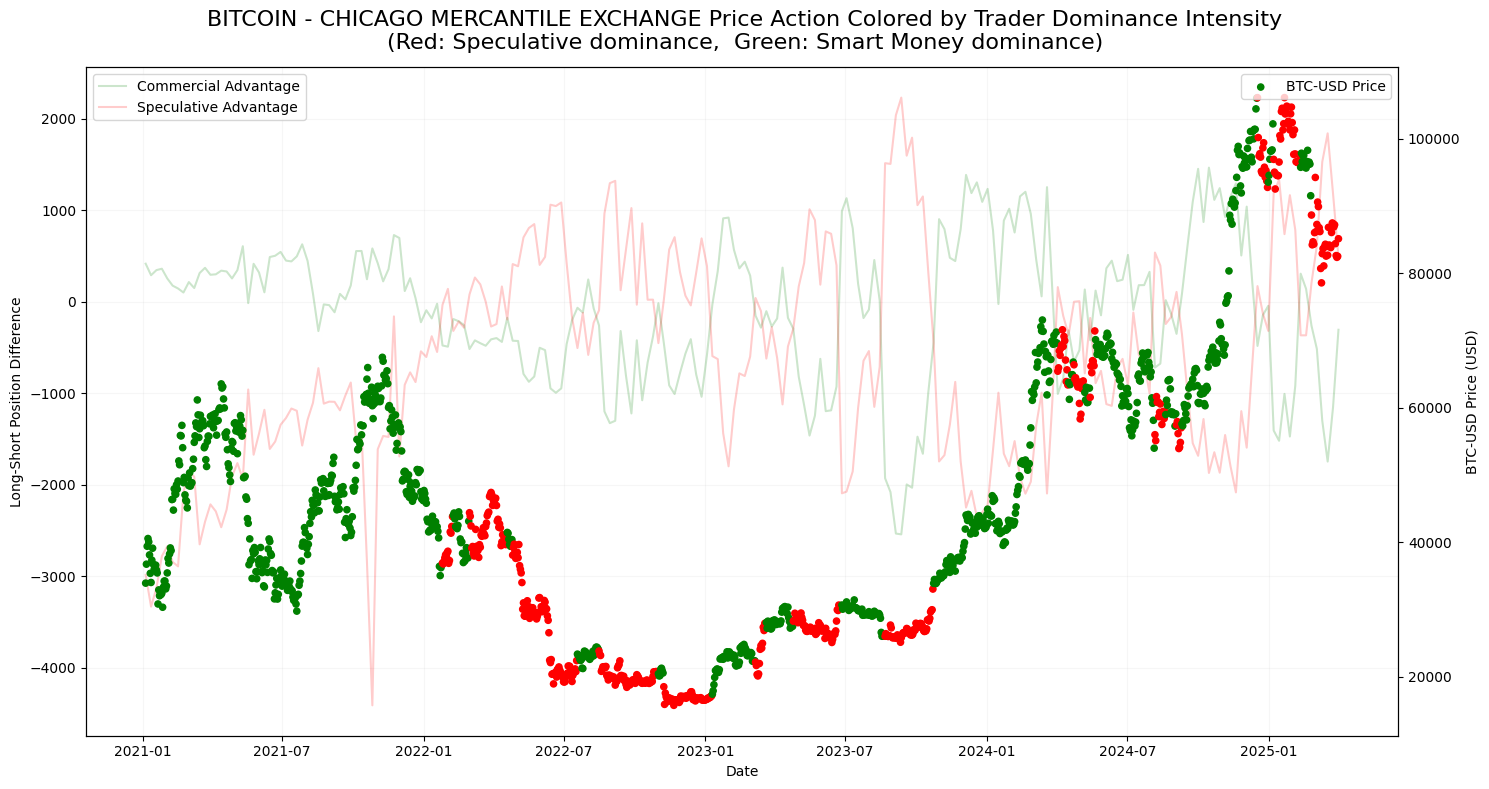

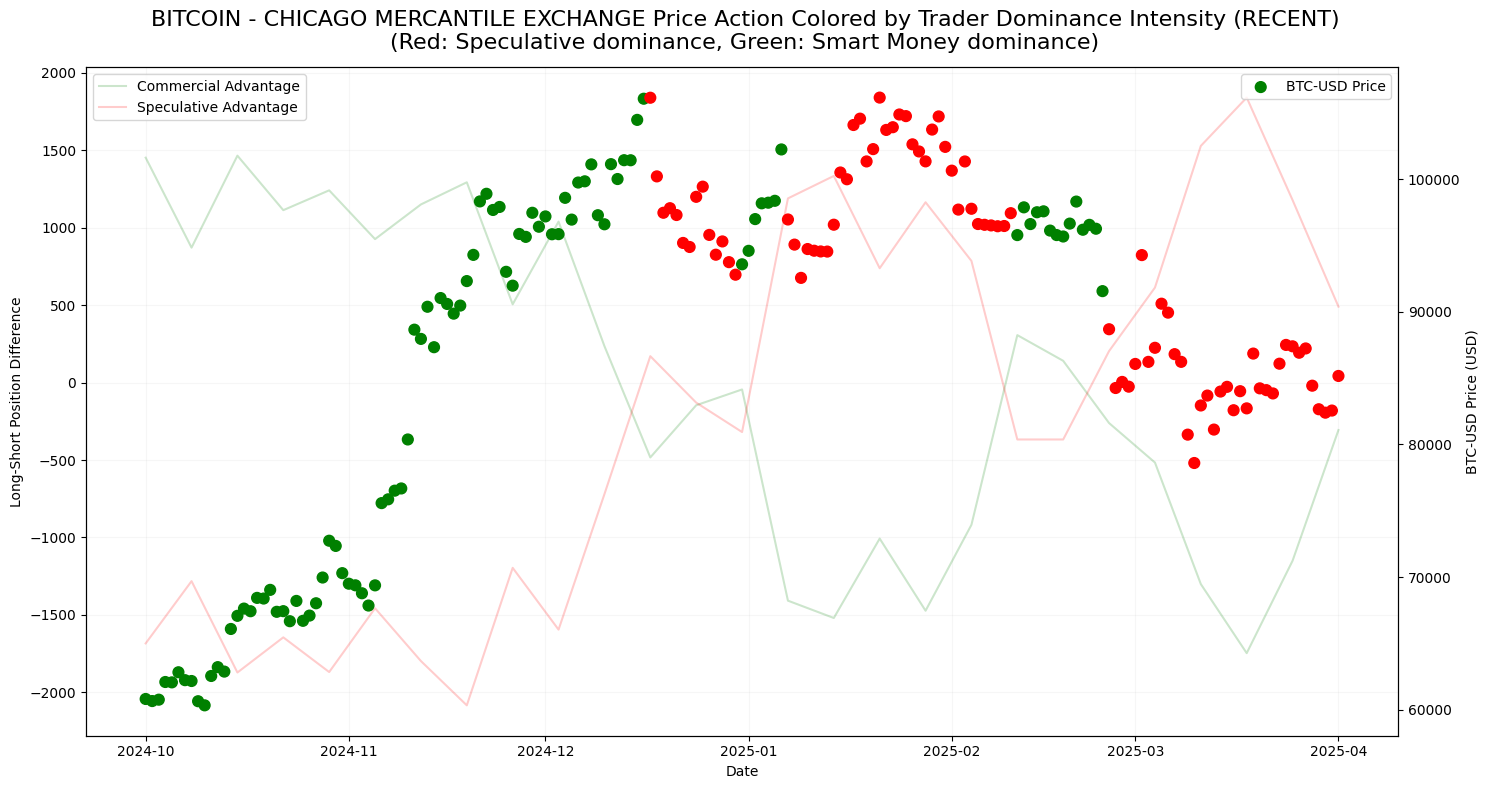


<div style="font-family: Arial, sans-serif; border: 1px solid #ddd; padding: 15px; border-radius: 5px; background-color: #f9f9f9;">
    <h2 style="color: #333;">–ê–∫—Ç—É–∞–ª—å–Ω—ã–π COT-–æ—Ç—á—ë—Ç –¥–ª—è BITCOIN - CHICAGO MERCANTILE EXCHANGE –Ω–∞ 2025-04-01</h2>
    <hr>

    <h3>Smart Money (–∏–Ω—Å—Ç–∏—Ç—É—Ü–∏–æ–Ω–∞–ª—å–Ω—ã–µ –∏–≥—Ä–æ–∫–∏)</h3>
    <ul>
        <li><strong>–ß–∏—Å—Ç–∞—è –ø–æ–∑–∏—Ü–∏—è:</strong> -306 –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li><strong>–ò–∑–º–µ–Ω–µ–Ω–∏–µ –∑–∞ –Ω–µ–¥–µ–ª—é:</strong> +844 –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li>‚úÖ –£–º–µ–Ω—å—à–µ–Ω–∏–µ –∑–∞—â–∏—Ç–Ω—ã—Ö –ø–æ–∑–∏—Ü–∏–π ‚Äî –≤–æ–∑–º–æ–∂–Ω–∞ —Å—Ç–∞–±–∏–ª–∏–∑–∞—Ü–∏—è –∏–ª–∏ —Ä–æ—Å—Ç</li>
    </ul>

    <h3>–°–ø–µ–∫—É–ª—è–Ω—Ç—ã (–º–µ–ª–∫–∏–µ –∏ —Å—Ä–µ–¥–Ω–∏–µ –∏–≥—Ä–æ–∫–∏)</h3>
    <ul>
        <li><strong>–ß–∏—Å—Ç–∞—è –ø–æ–∑–∏—Ü–∏—è:</strong> 491 –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li><strong>–ò–∑–º–µ–Ω–µ–Ω–∏–µ –∑–∞ –Ω–µ–¥–µ–ª—é:</strong> -688 –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li>‚ö†Ô∏è –°–Ω–∏–∂–µ–Ω–∏

In [4]:
ASSET = "BITCOIN - CHICAGO MERCANTILE EXCHANGE"

# Initialize CCXT Binance exchange
exchange = ccxt.binance()

# Fetch historical COT data
years = [2021, 2022, 2023, 2024, 2025]
columns = [
    "Market and Exchange Names",
    "As of Date in Form YYYY-MM-DD",
    "Noncommercial Positions-Long (All)",
    "Noncommercial Positions-Short (All)",
    "Commercial Positions-Long (All)",
    "Commercial Positions-Short (All)",
]

btc_cash_frames = []
for yr in years:
    df = cot.cot_year(year=yr, cot_report_type='legacy_fut')
    btc_cash_year = df[df["Market and Exchange Names"] == ASSET][columns].copy()
    btc_cash_frames.append(btc_cash_year)

BTC_CASH = pd.concat(btc_cash_frames)
BTC_CASH['Date'] = pd.to_datetime(BTC_CASH['As of Date in Form YYYY-MM-DD'])
BTC_CASH.sort_values('Date', inplace=True)

# Calculate position differences FIRST (before indexing)
BTC_CASH['Commercial Diff'] = BTC_CASH['Commercial Positions-Long (All)'] - BTC_CASH['Commercial Positions-Short (All)']
BTC_CASH['Noncommercial Diff'] = BTC_CASH['Noncommercial Positions-Long (All)'] - BTC_CASH['Noncommercial Positions-Short (All)']

# Set Date as index AFTER computing diffs
BTC_CASH.set_index('Date', inplace=True)

# Fetch historical BTC data from Binance explicitly matching date ranges
start_date = BTC_CASH.index.min()
end_date = BTC_CASH.index.max()

since = exchange.parse8601(start_date.strftime('%Y-%m-%dT00:00:00Z'))
end_timestamp = exchange.parse8601((end_date + pd.Timedelta(days=1)).strftime('%Y-%m-%dT00:00:00Z'))

btc_ohlcv = []
while since < end_timestamp:
    fetched = exchange.fetch_ohlcv('BTC/USDT', '1d', since)
    if not fetched:
        break
    btc_ohlcv.extend(fetched)
    since = fetched[-1][0] + 86400000

btc_prices = pd.DataFrame(btc_ohlcv, columns=['time', 'open', 'high', 'low', 'close', 'volume'])
btc_prices['time'] = pd.to_datetime(btc_prices['time'], unit='ms')
btc_prices.set_index('time', inplace=True)

# Explicitly trim BTC prices to match exactly the COT range
btc_prices = btc_prices.loc[start_date:end_date]

# Align datasets: Forward-fill weekly COT data into daily BTC data
combined_df = btc_prices.join(BTC_CASH[['Commercial Diff', 'Noncommercial Diff']], how='left').ffill()

# Dominant sentiment determination
combined_df['Dominance'] = combined_df['Commercial Diff'] > combined_df['Noncommercial Diff']
combined_df['Color'] = combined_df['Dominance'].map({True: 'green', False: 'red'})

# Plotting with subtle lines and emphasized price
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot weekly COT positions almost invisible
ax1.plot(BTC_CASH.index, BTC_CASH['Commercial Diff'], label='Commercial Advantage', color='green', alpha=0.2)
ax1.plot(BTC_CASH.index, BTC_CASH['Noncommercial Diff'], label='Speculative Advantage', color='red', alpha=0.2)

ax1.set_xlabel('Date')
ax1.set_ylabel('Long-Short Position Difference')
ax1.grid(True, alpha=0.1)

# Secondary axis: prominently visible BTC daily prices colored by trader dominance
ax2 = ax1.twinx()
ax2.scatter(combined_df.index, combined_df['close'], c=combined_df['Color'], alpha=1, s=20, label='BTC-USD Price')
ax2.set_ylabel('BTC-USD Price (USD)')
ax2.legend(loc='upper right')


# Plot Commercial and Noncommercial differences
ax1.set_xlabel('Date')
ax1.set_ylabel('Long-Short Position Difference')
ax1.legend(loc='upper left')

fig.suptitle(f'{ASSET} Price Action Colored by Trader Dominance Intensity\n'
             '(Red: Speculative dominance,  Green: Smart Money dominance)',
             fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.tight_layout()
plt.savefig("CFTC_BTC_full.png", dpi=300)
plt.show()


# Additional plot (last 3 months)
months_ago = end_date - pd.DateOffset(months=6)
recent_combined_df = combined_df[combined_df.index >= months_ago]
recent_BTC_CASH = BTC_CASH[BTC_CASH.index >= months_ago]

fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot weekly COT positions almost invisible
ax1.plot(recent_BTC_CASH.index, recent_BTC_CASH['Commercial Diff'], label='Commercial Advantage', color='green', alpha=0.2)
ax1.plot(recent_BTC_CASH.index, recent_BTC_CASH['Noncommercial Diff'], label='Speculative Advantage', color='red', alpha=0.2)

ax1.set_xlabel('Date')
ax1.set_ylabel('Long-Short Position Difference')
ax1.grid(True, alpha=0.1)

# Secondary axis: prominently visible BTC daily prices colored by trader dominance
ax2 = ax1.twinx()
ax2.scatter(recent_combined_df.index, recent_combined_df['close'], c=recent_combined_df['Color'], alpha=1, s=60, label='BTC-USD Price')
ax2.set_ylabel('BTC-USD Price (USD)')
ax2.legend(loc='upper right')


# Plot Commercial and Noncommercial differences
ax1.set_xlabel('Date')
ax1.set_ylabel('Long-Short Position Difference')
ax1.legend(loc='upper left')

fig.suptitle(f'{ASSET} Price Action Colored by Trader Dominance Intensity (RECENT)\n'
             '(Red: Speculative dominance, Green: Smart Money dominance)',
             fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.tight_layout()
plt.savefig("CFTC_BTC_recent.png", dpi=300)
plt.show()


# –ì–µ–Ω–µ—Ä–∞—Ü–∏—è –æ—Ç—á—ë—Ç–∞ —Å –∞–∫—Ü–µ–Ω—Ç–æ–º –Ω–∞ –∏–∑–º–µ–Ω–µ–Ω–∏–∏ —Ä–∞–∑–Ω–∏—Ü—ã –¥–æ–º–∏–Ω–∏—Ä–æ–≤–∞–Ω–∏—è
latest_date = BTC_CASH.index[-1]
latest = BTC_CASH.iloc[-1]
previous = BTC_CASH.iloc[-2]

commercial_diff_change = latest['Commercial Diff'] - previous['Commercial Diff']
speculative_diff_change = latest['Noncommercial Diff'] - previous['Noncommercial Diff']
current_diff = latest['Commercial Diff'] - latest['Noncommercial Diff']
previous_diff = previous['Commercial Diff'] - previous['Noncommercial Diff']
dominance_diff_change = current_diff - previous_diff

# –û–ø—Ä–µ–¥–µ–ª—è–µ–º –¥–æ–º–∏–Ω–∏—Ä—É—é—â—É—é –≥—Ä—É–ø–ø—É –∏ –æ–±—â–∏–π —Ç—Ä–µ–Ω–¥
if latest['Commercial Diff'] > latest['Noncommercial Diff']:
    dominant_group = 'Smart Money (–∫—Ä—É–ø–Ω—ã–µ –∏–Ω—Å—Ç–∏—Ç—É—Ü–∏–æ–Ω–∞–ª—å–Ω—ã–µ –∏–≥—Ä–æ–∫–∏)'
    overall_trend = 'üü¢ –ë—ã—á–∏–π'
else:
    dominant_group = '–°–ø–µ–∫—É–ª—è–Ω—Ç—ã (—Ä–æ–∑–Ω–∏—á–Ω—ã–µ –∏ –º–µ–ª–∫–∏–µ —Ç—Ä–µ–π–¥–µ—Ä—ã)'
    overall_trend = 'üî¥ –ú–µ–¥–≤–µ–∂–∏–π'

CFTC_BTC_report_html = f"""
<div style="font-family: Arial, sans-serif; border: 1px solid #ddd; padding: 15px; border-radius: 5px; background-color: #f9f9f9;">
    <h2 style="color: #333;">–ê–∫—Ç—É–∞–ª—å–Ω—ã–π COT-–æ—Ç—á—ë—Ç –¥–ª—è {ASSET} –Ω–∞ {latest_date.strftime('%Y-%m-%d')}</h2>
    <hr>

    <h3>Smart Money (–∏–Ω—Å—Ç–∏—Ç—É—Ü–∏–æ–Ω–∞–ª—å–Ω—ã–µ –∏–≥—Ä–æ–∫–∏)</h3>
    <ul>
        <li><strong>–ß–∏—Å—Ç–∞—è –ø–æ–∑–∏—Ü–∏—è:</strong> {latest['Commercial Diff']} –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li><strong>–ò–∑–º–µ–Ω–µ–Ω–∏–µ –∑–∞ –Ω–µ–¥–µ–ª—é:</strong> {commercial_diff_change:+} –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li>{'‚úÖ –£–º–µ–Ω—å—à–µ–Ω–∏–µ –∑–∞—â–∏—Ç–Ω—ã—Ö –ø–æ–∑–∏—Ü–∏–π ‚Äî –≤–æ–∑–º–æ–∂–Ω–∞ —Å—Ç–∞–±–∏–ª–∏–∑–∞—Ü–∏—è –∏–ª–∏ —Ä–æ—Å—Ç' if commercial_diff_change > 0 
             else '‚ö†Ô∏è –£–≤–µ–ª–∏—á–µ–Ω–∏–µ –∑–∞—â–∏—Ç–Ω—ã—Ö –ø–æ–∑–∏—Ü–∏–π ‚Äî –æ—Å—Ç–æ—Ä–æ–∂–Ω—ã–π –Ω–∞—Å—Ç—Ä–æ–π'}</li>
    </ul>

    <h3>–°–ø–µ–∫—É–ª—è–Ω—Ç—ã (–º–µ–ª–∫–∏–µ –∏ —Å—Ä–µ–¥–Ω–∏–µ –∏–≥—Ä–æ–∫–∏)</h3>
    <ul>
        <li><strong>–ß–∏—Å—Ç–∞—è –ø–æ–∑–∏—Ü–∏—è:</strong> {latest['Noncommercial Diff']} –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li><strong>–ò–∑–º–µ–Ω–µ–Ω–∏–µ –∑–∞ –Ω–µ–¥–µ–ª—é:</strong> {speculative_diff_change:+} –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li>{'üìà –†–æ—Å—Ç –æ–ø—Ç–∏–º–∏–∑–º–∞, –±—ã—á–∏–π –Ω–∞—Å—Ç—Ä–æ–π' if speculative_diff_change > 0 
             else '‚ö†Ô∏è –°–Ω–∏–∂–µ–Ω–∏–µ –æ–ø—Ç–∏–º–∏–∑–º–∞, –æ—Å—Ç–æ—Ä–æ–∂–Ω–æ—Å—Ç—å –∏–ª–∏ —Ñ–∏–∫—Å–∞—Ü–∏—è –ø—Ä–∏–±—ã–ª–∏'}</li>
    </ul>

    <h3><strong>–¢–µ–∫—É—â–µ–µ –¥–æ–º–∏–Ω–∏—Ä–æ–≤–∞–Ω–∏–µ:</strong> {dominant_group}</h3>
    <h3><strong>–û–±—â–∏–π —Ç—Ä–µ–Ω–¥:</strong> {overall_trend}</h3>
    <img src="CFTC_ETH_recent.png" alt="–¶–∏–∫–ª–∏—á–µ—Å–∫–∏–π –∞–Ω–∞–ª–∏–∑ —Å–µ–≥–æ–¥–Ω—è">

    <h3>–ò–∑–º–µ–Ω–µ–Ω–∏–µ –±–∞–ª–∞–Ω—Å–∞ —Å–∏–ª</h3>
    <ul>
        <li><strong>–†–∞–∑–Ω–∏—Ü–∞ –º–µ–∂–¥—É Smart Money –∏ —Å–ø–µ–∫—É–ª—è–Ω—Ç–∞–º–∏:</strong> {current_diff} –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li><strong>–ò–∑–º–µ–Ω–µ–Ω–∏–µ –∑–∞ –Ω–µ–¥–µ–ª—é:</strong> {dominance_diff_change:+} –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li>{'üìà –£—Å–∏–ª–µ–Ω–∏–µ –≤–ª–∏—è–Ω–∏—è Smart Money ‚Äî –≤–µ—Ä–æ—è—Ç–Ω—ã–π –±—ã—á–∏–π —Å–∏–≥–Ω–∞–ª' if dominance_diff_change > 0 
             else '‚ö†Ô∏è –£—Å–∏–ª–µ–Ω–∏–µ –ø–æ–∑–∏—Ü–∏–π —Å–ø–µ–∫—É–ª—è–Ω—Ç–æ–≤ ‚Äî –ø–æ–≤—ã—à–µ–Ω–Ω—ã–π —Ä–∏—Å–∫ –∫–æ—Ä—Ä–µ–∫—Ü–∏–∏'}</li>
    </ul>

    <h3>üîë –ö–ª—é—á–µ–≤–∞—è –∏–Ω—Ç–µ—Ä–ø—Ä–µ—Ç–∞—Ü–∏—è</h3>
    <p>–ò—Å—Ç–æ—Ä–∏—á–µ—Å–∫–∏, –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã–µ –º–æ–º–µ–Ω—Ç—ã –¥–ª—è –≤—Ö–æ–¥–∞ –≤ BTC –Ω–∞—Å—Ç—É–ø–∞—é—Ç, –∫–æ–≥–¥–∞ –ø–æ—Å–ª–µ –ø–µ—Ä–∏–æ–¥–∞ –∫–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏–∏ 
       –ø–æ–¥ –¥–æ–º–∏–Ω–∏—Ä–æ–≤–∞–Ω–∏–µ–º —Å–ø–µ–∫—É–ª—è–Ω—Ç–æ–≤ (üî¥), —Ä—ã–Ω–æ–∫ –ø–µ—Ä–µ—Ö–æ–¥–∏—Ç –ø–æ–¥ –≤–ª–∏—è–Ω–∏–µ Smart Money (üü¢) 
       –∏ —Ü–µ–Ω–∞ —Å—Ç–∞–±–∏–ª–∏–∑–∏—Ä—É–µ—Ç—Å—è. –¢–∞–∫–∏–µ —Ñ–∞–∑—ã —è–≤–ª—è—é—Ç—Å—è –ª—É—á—à–∏–º–∏ –¥–ª—è –∞–∫–∫—É–º—É–ª–∏—Ä–æ–≤–∞–Ω–∏—è –¥–ª–∏–Ω–Ω—ã—Ö –ø–æ–∑–∏—Ü–∏–π.</p>
</div>
"""

print(CFTC_BTC_report_html)



Selected: legacy_fut
Downloaded single year data from: 2021
Stored the file annual.txt in the working directory.
Selected: legacy_fut
Downloaded single year data from: 2022
Stored the file annual.txt in the working directory.
Selected: legacy_fut
Downloaded single year data from: 2023
Stored the file annual.txt in the working directory.
Selected: legacy_fut
Downloaded single year data from: 2024
Stored the file annual.txt in the working directory.
Selected: legacy_fut
Downloaded single year data from: 2025
Stored the file annual.txt in the working directory.


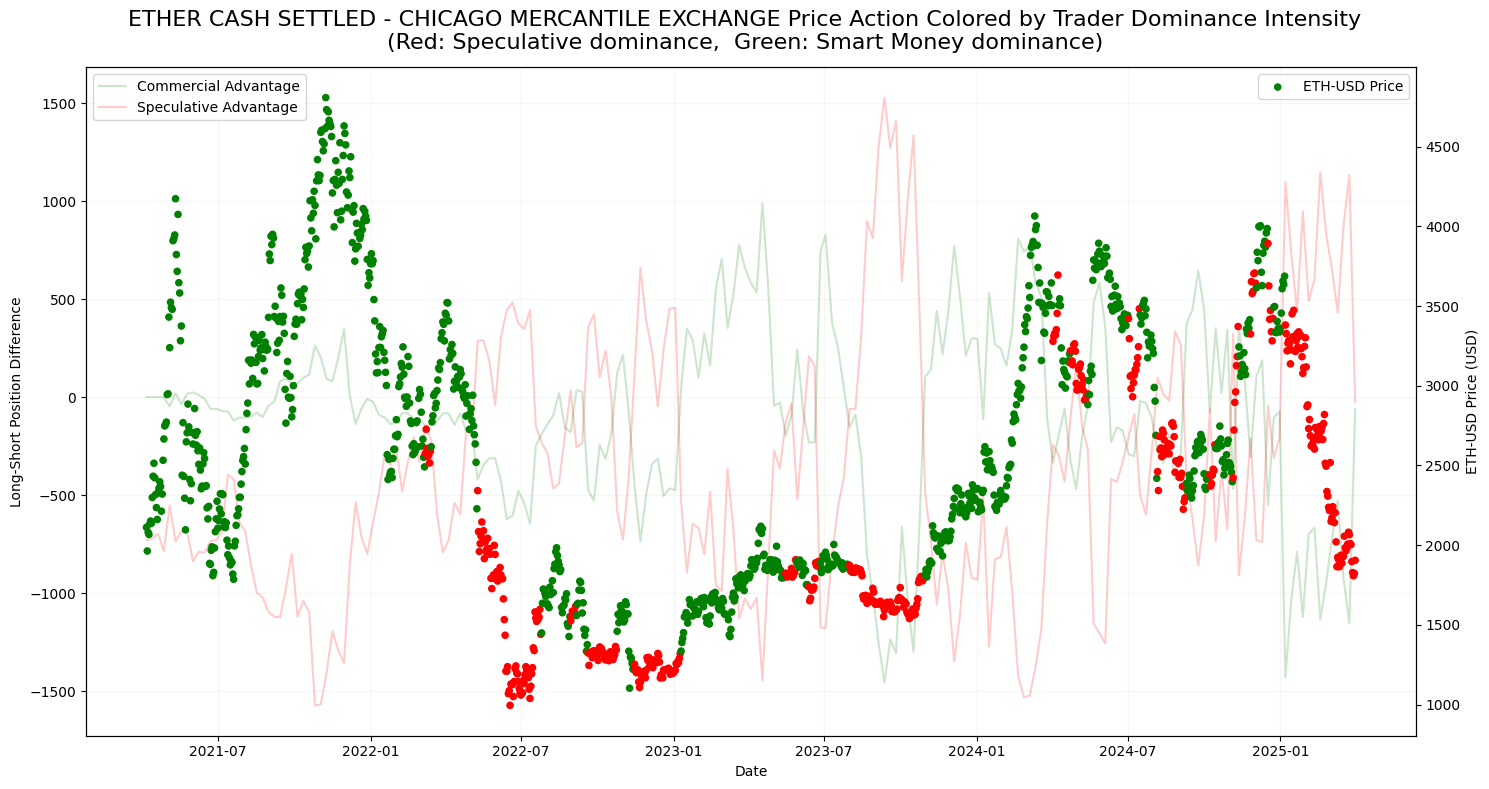

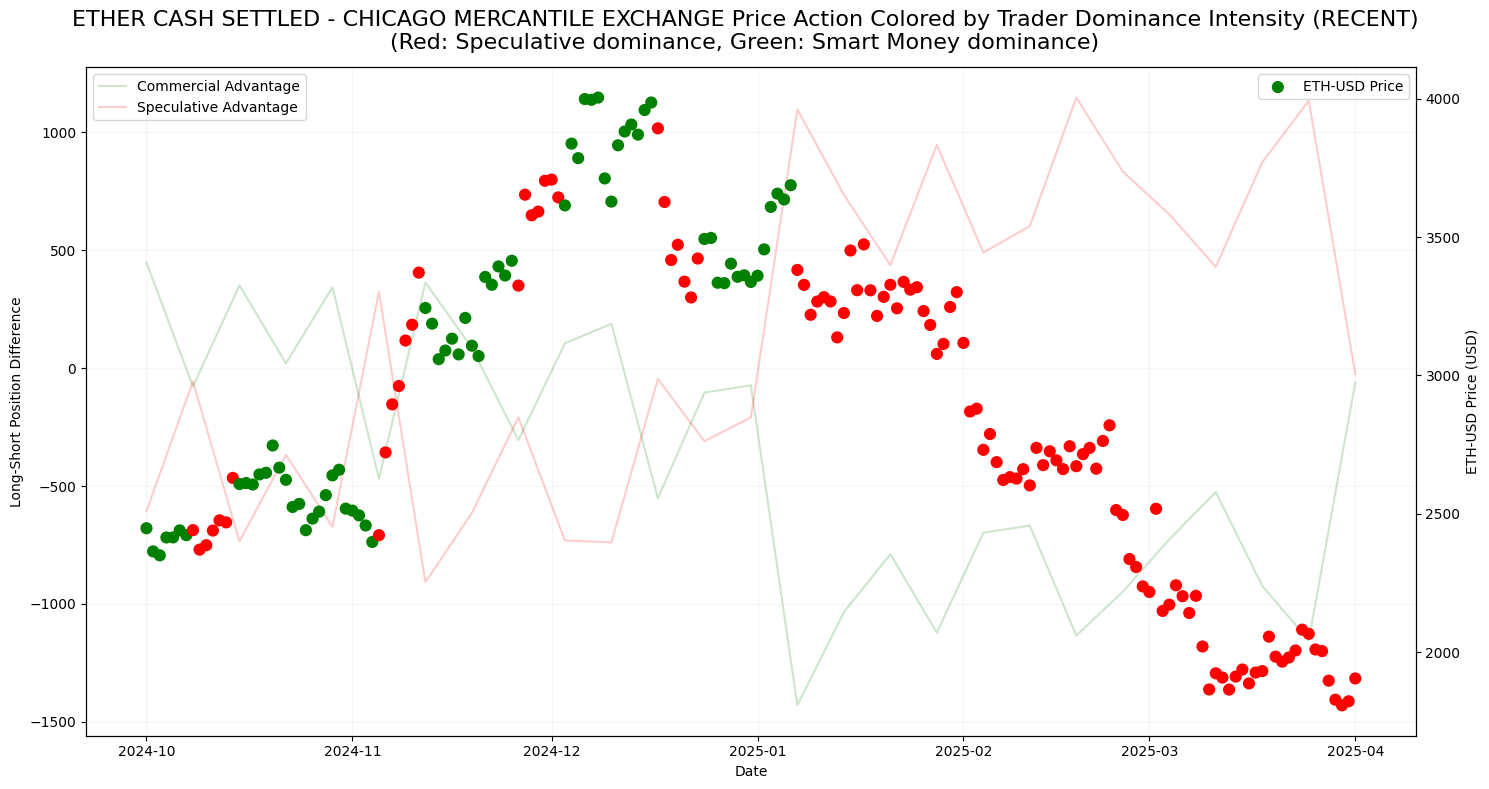


<div style="font-family: Arial, sans-serif; border: 1px solid #ddd; padding: 15px; border-radius: 5px; background-color: #f9f9f9;">
    <h2 style="color: #333;">–ê–∫—Ç—É–∞–ª—å–Ω—ã–π COT-–æ—Ç—á—ë—Ç –¥–ª—è ETHER CASH SETTLED - CHICAGO MERCANTILE EXCHANGE –Ω–∞ 2025-04-01</h2>
    <hr>

    <h3>Smart Money (–∏–Ω—Å—Ç–∏—Ç—É—Ü–∏–æ–Ω–∞–ª—å–Ω—ã–µ –∏–≥—Ä–æ–∫–∏)</h3>
    <ul>
        <li><strong>–ß–∏—Å—Ç–∞—è –ø–æ–∑–∏—Ü–∏—è:</strong> -61 –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li><strong>–ò–∑–º–µ–Ω–µ–Ω–∏–µ –∑–∞ –Ω–µ–¥–µ–ª—é:</strong> +1093 –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li>‚úÖ –£–º–µ–Ω—å—à–µ–Ω–∏–µ –∑–∞—â–∏—Ç–Ω—ã—Ö –ø–æ–∑–∏—Ü–∏–π ‚Äî –≤–æ–∑–º–æ–∂–Ω–∞ —Å—Ç–∞–±–∏–ª–∏–∑–∞—Ü–∏—è –∏–ª–∏ —Ä–æ—Å—Ç</li>
    </ul>

    <h3>–°–ø–µ–∫—É–ª—è–Ω—Ç—ã (–º–µ–ª–∫–∏–µ –∏ —Å—Ä–µ–¥–Ω–∏–µ –∏–≥—Ä–æ–∫–∏)</h3>
    <ul>
        <li><strong>–ß–∏—Å—Ç–∞—è –ø–æ–∑–∏—Ü–∏—è:</strong> -25 –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li><strong>–ò–∑–º–µ–Ω–µ–Ω–∏–µ –∑–∞ –Ω–µ–¥–µ–ª—é:</strong> -1159 –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li>‚ö†Ô∏è –°

In [5]:
ASSET = "ETHER CASH SETTLED - CHICAGO MERCANTILE EXCHANGE"

# Initialize CCXT Binance exchange
exchange = ccxt.binance()

# Fetch historical COT data
years = [2021, 2022, 2023, 2024, 2025]
columns = [
    "Market and Exchange Names",
    "As of Date in Form YYYY-MM-DD",
    "Noncommercial Positions-Long (All)",
    "Noncommercial Positions-Short (All)",
    "Commercial Positions-Long (All)",
    "Commercial Positions-Short (All)",
]

ETH_cash_frames = []
for yr in years:
    df = cot.cot_year(year=yr, cot_report_type='legacy_fut')
    ETH_cash_year = df[df["Market and Exchange Names"] == ASSET][columns].copy()
    ETH_cash_frames.append(ETH_cash_year)

ETH_CASH = pd.concat(ETH_cash_frames)
ETH_CASH['Date'] = pd.to_datetime(ETH_CASH['As of Date in Form YYYY-MM-DD'])
ETH_CASH.sort_values('Date', inplace=True)

# Calculate position differences FIRST (before indexing)
ETH_CASH['Commercial Diff'] = ETH_CASH['Commercial Positions-Long (All)'] - ETH_CASH['Commercial Positions-Short (All)']
ETH_CASH['Noncommercial Diff'] = ETH_CASH['Noncommercial Positions-Long (All)'] - ETH_CASH['Noncommercial Positions-Short (All)']

# Set Date as index AFTER computing diffs
ETH_CASH.set_index('Date', inplace=True)

# Fetch historical ETH data from Binance explicitly matching date ranges
start_date = ETH_CASH.index.min()
end_date = ETH_CASH.index.max()

since = exchange.parse8601(start_date.strftime('%Y-%m-%dT00:00:00Z'))
end_timestamp = exchange.parse8601((end_date + pd.Timedelta(days=1)).strftime('%Y-%m-%dT00:00:00Z'))

ETH_ohlcv = []
while since < end_timestamp:
    fetched = exchange.fetch_ohlcv('ETH/USDT', '1d', since)
    if not fetched:
        break
    ETH_ohlcv.extend(fetched)
    since = fetched[-1][0] + 86400000

ETH_prices = pd.DataFrame(ETH_ohlcv, columns=['time', 'open', 'high', 'low', 'close', 'volume'])
ETH_prices['time'] = pd.to_datetime(ETH_prices['time'], unit='ms')
ETH_prices.set_index('time', inplace=True)

# Explicitly trim ETH prices to match exactly the COT range
ETH_prices = ETH_prices.loc[start_date:end_date]

# Align datasets: Forward-fill weekly COT data into daily ETH data
combined_df = ETH_prices.join(ETH_CASH[['Commercial Diff', 'Noncommercial Diff']], how='left').ffill()

# Dominant sentiment determination
combined_df['Dominance'] = combined_df['Commercial Diff'] > combined_df['Noncommercial Diff']
combined_df['Color'] = combined_df['Dominance'].map({True: 'green', False: 'red'})

# Plotting with subtle lines and emphasized price
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot weekly COT positions almost invisible
ax1.plot(ETH_CASH.index, ETH_CASH['Commercial Diff'], label='Commercial Advantage', color='green', alpha=0.2)
ax1.plot(ETH_CASH.index, ETH_CASH['Noncommercial Diff'], label='Speculative Advantage', color='red', alpha=0.2)

ax1.set_xlabel('Date')
ax1.set_ylabel('Long-Short Position Difference')
ax1.grid(True, alpha=0.1)

# Secondary axis: prominently visible ETH daily prices colored by trader dominance
ax2 = ax1.twinx()
ax2.scatter(combined_df.index, combined_df['close'], c=combined_df['Color'], alpha=1, s=20, label='ETH-USD Price')
ax2.set_ylabel('ETH-USD Price (USD)')
ax2.legend(loc='upper right')


# Plot Commercial and Noncommercial differences
ax1.set_xlabel('Date')
ax1.set_ylabel('Long-Short Position Difference')
ax1.legend(loc='upper left')

fig.suptitle(f'{ASSET} Price Action Colored by Trader Dominance Intensity\n'
             '(Red: Speculative dominance,  Green: Smart Money dominance)',
             fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.tight_layout()
plt.savefig("CFTC_ETH_full.png", dpi=300)
plt.show()


# Additional plot (last 3 months)
months_ago = end_date - pd.DateOffset(months=6)
recent_combined_df = combined_df[combined_df.index >= months_ago]
recent_ETH_CASH = ETH_CASH[ETH_CASH.index >= months_ago]

fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot weekly COT positions almost invisible
ax1.plot(recent_ETH_CASH.index, recent_ETH_CASH['Commercial Diff'], label='Commercial Advantage', color='green', alpha=0.2)
ax1.plot(recent_ETH_CASH.index, recent_ETH_CASH['Noncommercial Diff'], label='Speculative Advantage', color='red', alpha=0.2)

ax1.set_xlabel('Date')
ax1.set_ylabel('Long-Short Position Difference')
ax1.grid(True, alpha=0.1)

# Secondary axis: prominently visible ETH daily prices colored by trader dominance
ax2 = ax1.twinx()
ax2.scatter(recent_combined_df.index, recent_combined_df['close'], c=recent_combined_df['Color'], alpha=1, s=60, label='ETH-USD Price')
ax2.set_ylabel('ETH-USD Price (USD)')
ax2.legend(loc='upper right')


# Plot Commercial and Noncommercial differences
ax1.set_xlabel('Date')
ax1.set_ylabel('Long-Short Position Difference')
ax1.legend(loc='upper left')

fig.suptitle(f'{ASSET} Price Action Colored by Trader Dominance Intensity (RECENT)\n'
             '(Red: Speculative dominance, Green: Smart Money dominance)',
             fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.tight_layout()
plt.savefig("CFTC_ETH_recent.png", dpi=300)
plt.show()

# –ì–µ–Ω–µ—Ä–∞—Ü–∏—è –æ—Ç—á—ë—Ç–∞ —Å –∞–∫—Ü–µ–Ω—Ç–æ–º –Ω–∞ –∏–∑–º–µ–Ω–µ–Ω–∏–∏ —Ä–∞–∑–Ω–∏—Ü—ã –¥–æ–º–∏–Ω–∏—Ä–æ–≤–∞–Ω–∏—è
latest_date = ETH_CASH.index[-1]
latest = ETH_CASH.iloc[-1]
previous = ETH_CASH.iloc[-2]

commercial_diff_change = latest['Commercial Diff'] - previous['Commercial Diff']
speculative_diff_change = latest['Noncommercial Diff'] - previous['Noncommercial Diff']
current_diff = latest['Commercial Diff'] - latest['Noncommercial Diff']
previous_diff = previous['Commercial Diff'] - previous['Noncommercial Diff']
dominance_diff_change = current_diff - previous_diff

# –û–ø—Ä–µ–¥–µ–ª—è–µ–º –¥–æ–º–∏–Ω–∏—Ä—É—é—â—É—é –≥—Ä—É–ø–ø—É –∏ –æ–±—â–∏–π —Ç—Ä–µ–Ω–¥
if latest['Commercial Diff'] > latest['Noncommercial Diff']:
    dominant_group = 'Smart Money (–∫—Ä—É–ø–Ω—ã–µ –∏–Ω—Å—Ç–∏—Ç—É—Ü–∏–æ–Ω–∞–ª—å–Ω—ã–µ –∏–≥—Ä–æ–∫–∏)'
    overall_trend = 'üü¢ –ë—ã—á–∏–π'
else:
    dominant_group = '–°–ø–µ–∫—É–ª—è–Ω—Ç—ã (—Ä–æ–∑–Ω–∏—á–Ω—ã–µ –∏ –º–µ–ª–∫–∏–µ —Ç—Ä–µ–π–¥–µ—Ä—ã)'
    overall_trend = 'üî¥ –ú–µ–¥–≤–µ–∂–∏–π'

CFTC_ETH_report_html = f"""
<div style="font-family: Arial, sans-serif; border: 1px solid #ddd; padding: 15px; border-radius: 5px; background-color: #f9f9f9;">
    <h2 style="color: #333;">–ê–∫—Ç—É–∞–ª—å–Ω—ã–π COT-–æ—Ç—á—ë—Ç –¥–ª—è {ASSET} –Ω–∞ {latest_date.strftime('%Y-%m-%d')}</h2>
    <hr>

    <h3>Smart Money (–∏–Ω—Å—Ç–∏—Ç—É—Ü–∏–æ–Ω–∞–ª—å–Ω—ã–µ –∏–≥—Ä–æ–∫–∏)</h3>
    <ul>
        <li><strong>–ß–∏—Å—Ç–∞—è –ø–æ–∑–∏—Ü–∏—è:</strong> {latest['Commercial Diff']} –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li><strong>–ò–∑–º–µ–Ω–µ–Ω–∏–µ –∑–∞ –Ω–µ–¥–µ–ª—é:</strong> {commercial_diff_change:+} –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li>{'‚úÖ –£–º–µ–Ω—å—à–µ–Ω–∏–µ –∑–∞—â–∏—Ç–Ω—ã—Ö –ø–æ–∑–∏—Ü–∏–π ‚Äî –≤–æ–∑–º–æ–∂–Ω–∞ —Å—Ç–∞–±–∏–ª–∏–∑–∞—Ü–∏—è –∏–ª–∏ —Ä–æ—Å—Ç' if commercial_diff_change > 0 
             else '‚ö†Ô∏è –£–≤–µ–ª–∏—á–µ–Ω–∏–µ –∑–∞—â–∏—Ç–Ω—ã—Ö –ø–æ–∑–∏—Ü–∏–π ‚Äî –æ—Å—Ç–æ—Ä–æ–∂–Ω—ã–π –Ω–∞—Å—Ç—Ä–æ–π'}</li>
    </ul>

    <h3>–°–ø–µ–∫—É–ª—è–Ω—Ç—ã (–º–µ–ª–∫–∏–µ –∏ —Å—Ä–µ–¥–Ω–∏–µ –∏–≥—Ä–æ–∫–∏)</h3>
    <ul>
        <li><strong>–ß–∏—Å—Ç–∞—è –ø–æ–∑–∏—Ü–∏—è:</strong> {latest['Noncommercial Diff']} –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li><strong>–ò–∑–º–µ–Ω–µ–Ω–∏–µ –∑–∞ –Ω–µ–¥–µ–ª—é:</strong> {speculative_diff_change:+} –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li>{'üìà –†–æ—Å—Ç –æ–ø—Ç–∏–º–∏–∑–º–∞, –±—ã—á–∏–π –Ω–∞—Å—Ç—Ä–æ–π' if speculative_diff_change > 0 
             else '‚ö†Ô∏è –°–Ω–∏–∂–µ–Ω–∏–µ –æ–ø—Ç–∏–º–∏–∑–º–∞, –æ—Å—Ç–æ—Ä–æ–∂–Ω–æ—Å—Ç—å –∏–ª–∏ —Ñ–∏–∫—Å–∞—Ü–∏—è –ø—Ä–∏–±—ã–ª–∏'}</li>
    </ul>

    <h3><strong>–¢–µ–∫—É—â–µ–µ –¥–æ–º–∏–Ω–∏—Ä–æ–≤–∞–Ω–∏–µ:</strong> {dominant_group}</h3>
    <h3><strong>–û–±—â–∏–π —Ç—Ä–µ–Ω–¥:</strong> {overall_trend}</h3>
    <img src="CFTC_ETH_recent.png" alt="–¶–∏–∫–ª–∏—á–µ—Å–∫–∏–π –∞–Ω–∞–ª–∏–∑ —Å–µ–≥–æ–¥–Ω—è">

    <h3>–ò–∑–º–µ–Ω–µ–Ω–∏–µ –±–∞–ª–∞–Ω—Å–∞ —Å–∏–ª</h3>
    <ul>
        <li><strong>–†–∞–∑–Ω–∏—Ü–∞ –º–µ–∂–¥—É Smart Money –∏ —Å–ø–µ–∫—É–ª—è–Ω—Ç–∞–º–∏:</strong> {current_diff} –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li><strong>–ò–∑–º–µ–Ω–µ–Ω–∏–µ –∑–∞ –Ω–µ–¥–µ–ª—é:</strong> {dominance_diff_change:+} –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li>{'üìà –£—Å–∏–ª–µ–Ω–∏–µ –≤–ª–∏—è–Ω–∏—è Smart Money ‚Äî –≤–µ—Ä–æ—è—Ç–Ω—ã–π –±—ã—á–∏–π —Å–∏–≥–Ω–∞–ª' if dominance_diff_change > 0 
             else '‚ö†Ô∏è –£—Å–∏–ª–µ–Ω–∏–µ –ø–æ–∑–∏—Ü–∏–π —Å–ø–µ–∫—É–ª—è–Ω—Ç–æ–≤ ‚Äî –ø–æ–≤—ã—à–µ–Ω–Ω—ã–π —Ä–∏—Å–∫ –∫–æ—Ä—Ä–µ–∫—Ü–∏–∏'}</li>
    </ul>

    <h3>üîë –ö–ª—é—á–µ–≤–∞—è –∏–Ω—Ç–µ—Ä–ø—Ä–µ—Ç–∞—Ü–∏—è</h3>
    <p>–ò—Å—Ç–æ—Ä–∏—á–µ—Å–∫–∏, –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã–µ –º–æ–º–µ–Ω—Ç—ã –¥–ª—è –≤—Ö–æ–¥–∞ –≤ ETH –Ω–∞—Å—Ç—É–ø–∞—é—Ç, –∫–æ–≥–¥–∞ –ø–æ—Å–ª–µ –ø–µ—Ä–∏–æ–¥–∞ –∫–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏–∏ 
       –ø–æ–¥ –¥–æ–º–∏–Ω–∏—Ä–æ–≤–∞–Ω–∏–µ–º —Å–ø–µ–∫—É–ª—è–Ω—Ç–æ–≤ (üî¥), —Ä—ã–Ω–æ–∫ –ø–µ—Ä–µ—Ö–æ–¥–∏—Ç –ø–æ–¥ –≤–ª–∏—è–Ω–∏–µ Smart Money (üü¢) 
       –∏ —Ü–µ–Ω–∞ —Å—Ç–∞–±–∏–ª–∏–∑–∏—Ä—É–µ—Ç—Å—è. –¢–∞–∫–∏–µ —Ñ–∞–∑—ã —è–≤–ª—è—é—Ç—Å—è –ª—É—á—à–∏–º–∏ –¥–ª—è –∞–∫–∫—É–º—É–ª–∏—Ä–æ–≤–∞–Ω–∏—è –¥–ª–∏–Ω–Ω—ã—Ö –ø–æ–∑–∏—Ü–∏–π.</p>
</div>
"""

print(CFTC_ETH_report_html)

Selected: legacy_fut
Downloaded single year data from: 2025
Stored the file annual.txt in the working directory.


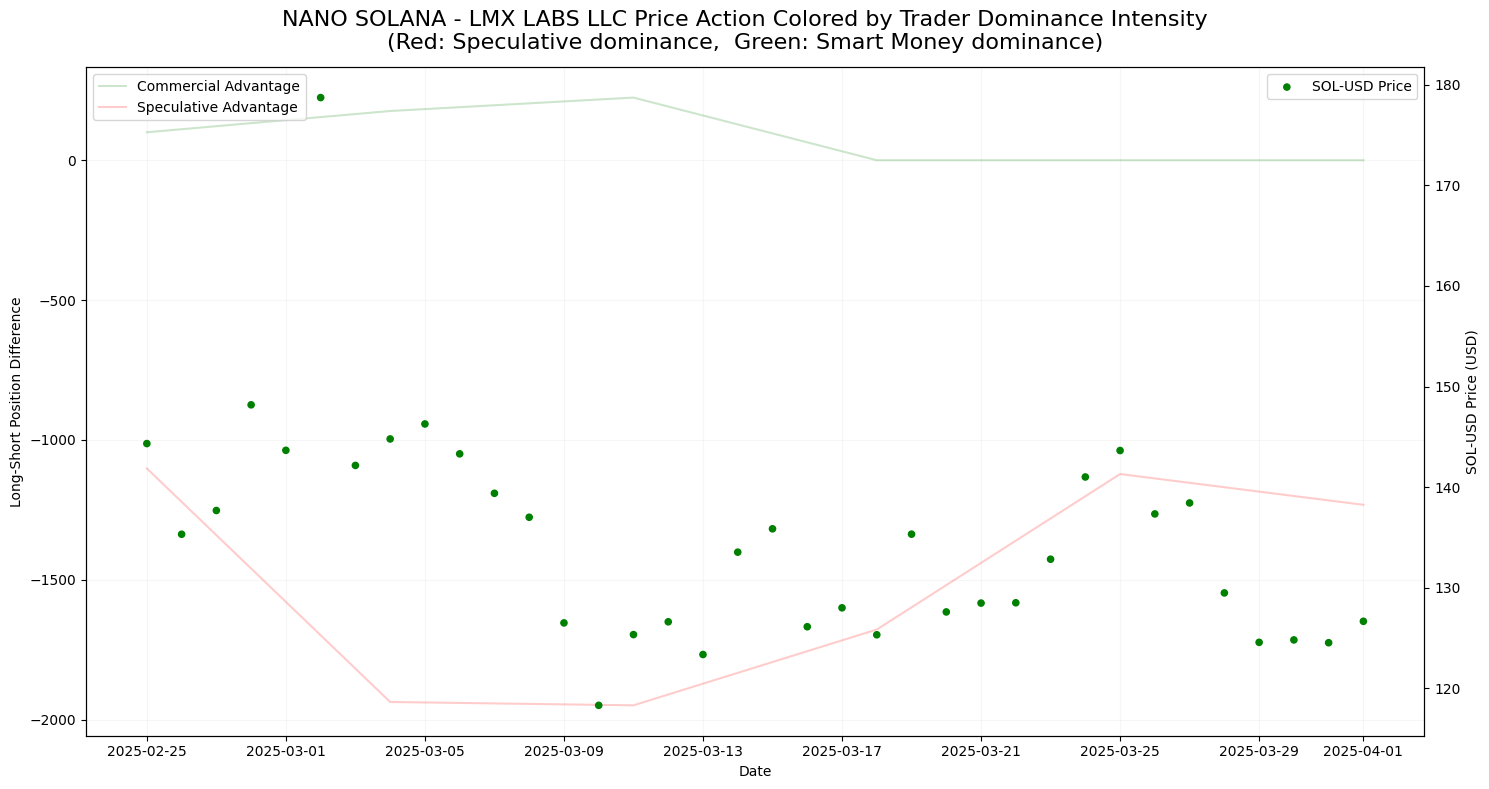

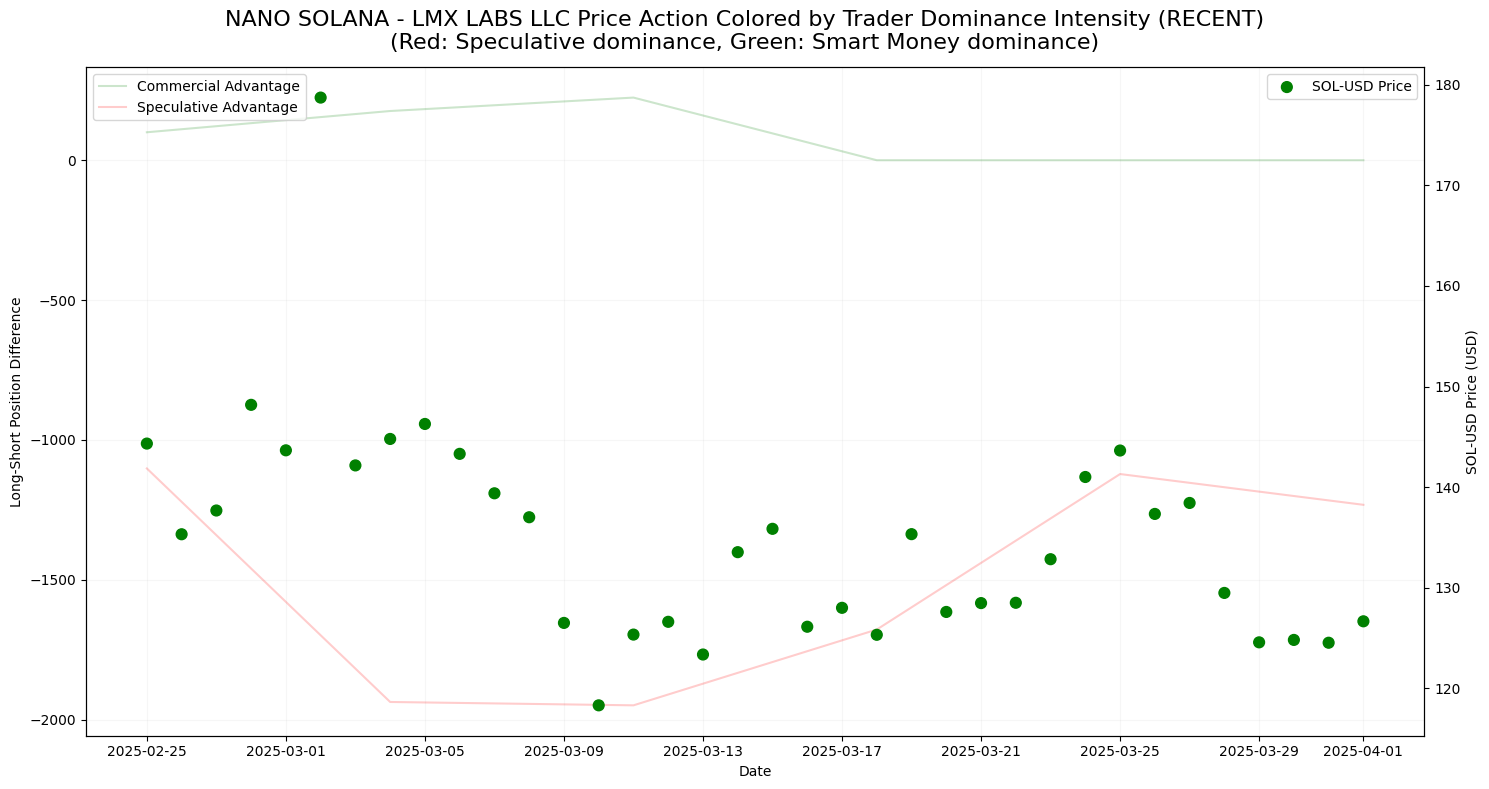


<div style="font-family: Arial, sans-serif; border: 1px solid #ddd; padding: 15px; border-radius: 5px; background-color: #f9f9f9;">
    <h2 style="color: #333;">–ê–∫—Ç—É–∞–ª—å–Ω—ã–π COT-–æ—Ç—á—ë—Ç –¥–ª—è NANO SOLANA - LMX LABS LLC –Ω–∞ 2025-04-01</h2>
    <hr>

    <h3>Smart Money (–∏–Ω—Å—Ç–∏—Ç—É—Ü–∏–æ–Ω–∞–ª—å–Ω—ã–µ –∏–≥—Ä–æ–∫–∏)</h3>
    <ul>
        <li><strong>–ß–∏—Å—Ç–∞—è –ø–æ–∑–∏—Ü–∏—è:</strong> 0 –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li><strong>–ò–∑–º–µ–Ω–µ–Ω–∏–µ –∑–∞ –Ω–µ–¥–µ–ª—é:</strong> +0 –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li>‚ö†Ô∏è –£–≤–µ–ª–∏—á–µ–Ω–∏–µ –∑–∞—â–∏—Ç–Ω—ã—Ö –ø–æ–∑–∏—Ü–∏–π ‚Äî –æ—Å—Ç–æ—Ä–æ–∂–Ω—ã–π –Ω–∞—Å—Ç—Ä–æ–π</li>
    </ul>

    <h3>–°–ø–µ–∫—É–ª—è–Ω—Ç—ã (–º–µ–ª–∫–∏–µ –∏ —Å—Ä–µ–¥–Ω–∏–µ –∏–≥—Ä–æ–∫–∏)</h3>
    <ul>
        <li><strong>–ß–∏—Å—Ç–∞—è –ø–æ–∑–∏—Ü–∏—è:</strong> -1232 –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li><strong>–ò–∑–º–µ–Ω–µ–Ω–∏–µ –∑–∞ –Ω–µ–¥–µ–ª—é:</strong> -110 –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li>‚ö†Ô∏è –°–Ω–∏–∂–µ–Ω–∏–µ –æ–ø—Ç–∏–º–∏–∑–º–∞, –æ—Å—Ç–æ—Ä

In [25]:
import ccxt
import pandas as pd
import matplotlib.pyplot as plt

# Define asset and initialize exchange
ASSET = "NANO SOLANA - LMX LABS LLC"

# Initialize CCXT Binance exchange
exchange = ccxt.binance()

# Fetch historical COT data
years = [2025]
columns = [
    "Market and Exchange Names",
    "As of Date in Form YYYY-MM-DD",
    "Noncommercial Positions-Long (All)",
    "Noncommercial Positions-Short (All)",
    "Commercial Positions-Long (All)",
    "Commercial Positions-Short (All)",
]

SOL_cash_frames = []
for yr in years:
    df = cot.cot_year(year=yr, cot_report_type='legacy_fut')
    SOL_cash_year = df[df["Market and Exchange Names"] == ASSET][columns].copy()
    SOL_cash_frames.append(SOL_cash_year)

SOL_CASH = pd.concat(SOL_cash_frames)
SOL_CASH['Date'] = pd.to_datetime(SOL_CASH['As of Date in Form YYYY-MM-DD'])
SOL_CASH.sort_values('Date', inplace=True)

# Calculate position differences FIRST (before indexing)
SOL_CASH['Commercial Diff'] = SOL_CASH['Commercial Positions-Long (All)'] - SOL_CASH['Commercial Positions-Short (All)']
SOL_CASH['Noncommercial Diff'] = SOL_CASH['Noncommercial Positions-Long (All)'] - SOL_CASH['Noncommercial Positions-Short (All)']

# Set Date as index AFTER computing diffs
SOL_CASH.set_index('Date', inplace=True)

# Fetch historical SOL data from Binance explicitly matching date ranges
start_date = SOL_CASH.index.min()
end_date = SOL_CASH.index.max()

since = exchange.parse8601(start_date.strftime('%Y-%m-%dT00:00:00Z'))
end_timestamp = exchange.parse8601((end_date + pd.Timedelta(days=1)).strftime('%Y-%m-%dT00:00:00Z'))

SOL_ohlcv = []
while since < end_timestamp:
    fetched = exchange.fetch_ohlcv('SOL/USDT', '1d', since)
    if not fetched:
        break
    SOL_ohlcv.extend(fetched)
    since = fetched[-1][0] + 86400000

SOL_prices = pd.DataFrame(SOL_ohlcv, columns=['time', 'open', 'high', 'low', 'close', 'volume'])
SOL_prices['time'] = pd.to_datetime(SOL_prices['time'], unit='ms')
SOL_prices.set_index('time', inplace=True)

# Explicitly trim SOL prices to match exactly the COT range
SOL_prices = SOL_prices.loc[start_date:end_date]

# Align datasets: Forward-fill weekly COT data into daily SOL data
combined_df = SOL_prices.join(SOL_CASH[['Commercial Diff', 'Noncommercial Diff']], how='left').ffill()

# Dominant sentiment determination
combined_df['Dominance'] = combined_df['Commercial Diff'] > combined_df['Noncommercial Diff']
combined_df['Color'] = combined_df['Dominance'].map({True: 'green', False: 'red'})

# Plotting with subtle lines and emphasized price
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot weekly COT positions almost invisible
ax1.plot(SOL_CASH.index, SOL_CASH['Commercial Diff'], label='Commercial Advantage', color='green', alpha=0.2)
ax1.plot(SOL_CASH.index, SOL_CASH['Noncommercial Diff'], label='Speculative Advantage', color='red', alpha=0.2)

ax1.set_xlabel('Date')
ax1.set_ylabel('Long-Short Position Difference')
ax1.grid(True, alpha=0.1)

# Secondary axis: prominently visible SOL daily prices colored by trader dominance
ax2 = ax1.twinx()
ax2.scatter(combined_df.index, combined_df['close'], c=combined_df['Color'], alpha=1, s=20, label='SOL-USD Price')
ax2.set_ylabel('SOL-USD Price (USD)')
ax2.legend(loc='upper right')


# Plot Commercial and Noncommercial differences
ax1.set_xlabel('Date')
ax1.set_ylabel('Long-Short Position Difference')
ax1.legend(loc='upper left')

fig.suptitle(f'{ASSET} Price Action Colored by Trader Dominance Intensity\n'
             '(Red: Speculative dominance,  Green: Smart Money dominance)',
             fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.tight_layout()
plt.savefig("CFTC_SOL_full.png", dpi=300)
plt.show()


# Additional plot (last 3 months)
months_ago = end_date - pd.DateOffset(months=6)
recent_combined_df = combined_df[combined_df.index >= months_ago]
recent_SOL_CASH = SOL_CASH[SOL_CASH.index >= months_ago]

fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot weekly COT positions almost invisible
ax1.plot(recent_SOL_CASH.index, recent_SOL_CASH['Commercial Diff'], label='Commercial Advantage', color='green', alpha=0.2)
ax1.plot(recent_SOL_CASH.index, recent_SOL_CASH['Noncommercial Diff'], label='Speculative Advantage', color='red', alpha=0.2)

ax1.set_xlabel('Date')
ax1.set_ylabel('Long-Short Position Difference')
ax1.grid(True, alpha=0.1)

# Secondary axis: prominently visible SOL daily prices colored by trader dominance
ax2 = ax1.twinx()
ax2.scatter(recent_combined_df.index, recent_combined_df['close'], c=recent_combined_df['Color'], alpha=1, s=60, label='SOL-USD Price')
ax2.set_ylabel('SOL-USD Price (USD)')
ax2.legend(loc='upper right')


# Plot Commercial and Noncommercial differences
ax1.set_xlabel('Date')
ax1.set_ylabel('Long-Short Position Difference')
ax1.legend(loc='upper left')

fig.suptitle(f'{ASSET} Price Action Colored by Trader Dominance Intensity (RECENT)\n'
             '(Red: Speculative dominance, Green: Smart Money dominance)',
             fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.tight_layout()
plt.savefig("CFTC_SOL_recent.png", dpi=300)
plt.show()

# –ì–µ–Ω–µ—Ä–∞—Ü–∏—è –æ—Ç—á—ë—Ç–∞ —Å –∞–∫—Ü–µ–Ω—Ç–æ–º –Ω–∞ –∏–∑–º–µ–Ω–µ–Ω–∏–∏ —Ä–∞–∑–Ω–∏—Ü—ã –¥–æ–º–∏–Ω–∏—Ä–æ–≤–∞–Ω–∏—è
latest_date = SOL_CASH.index[-1]
latest = SOL_CASH.iloc[-1]
previous = SOL_CASH.iloc[-2]

commercial_diff_change = latest['Commercial Diff'] - previous['Commercial Diff']
speculative_diff_change = latest['Noncommercial Diff'] - previous['Noncommercial Diff']
current_diff = latest['Commercial Diff'] - latest['Noncommercial Diff']
previous_diff = previous['Commercial Diff'] - previous['Noncommercial Diff']
dominance_diff_change = current_diff - previous_diff

# –û–ø—Ä–µ–¥–µ–ª—è–µ–º –¥–æ–º–∏–Ω–∏—Ä—É—é—â—É—é –≥—Ä—É–ø–ø—É –∏ –æ–±—â–∏–π —Ç—Ä–µ–Ω–¥
if latest['Commercial Diff'] > latest['Noncommercial Diff']:
    dominant_group = 'Smart Money (–∫—Ä—É–ø–Ω—ã–µ –∏–Ω—Å—Ç–∏—Ç—É—Ü–∏–æ–Ω–∞–ª—å–Ω—ã–µ –∏–≥—Ä–æ–∫–∏)'
    overall_trend = 'üü¢ –ë—ã—á–∏–π'
else:
    dominant_group = '–°–ø–µ–∫—É–ª—è–Ω—Ç—ã (—Ä–æ–∑–Ω–∏—á–Ω—ã–µ –∏ –º–µ–ª–∫–∏–µ —Ç—Ä–µ–π–¥–µ—Ä—ã)'
    overall_trend = 'üî¥ –ú–µ–¥–≤–µ–∂–∏–π'

CFTC_SOL_report_html = f"""
<div style="font-family: Arial, sans-serif; border: 1px solid #ddd; padding: 15px; border-radius: 5px; background-color: #f9f9f9;">
    <h2 style="color: #333;">–ê–∫—Ç—É–∞–ª—å–Ω—ã–π COT-–æ—Ç—á—ë—Ç –¥–ª—è {ASSET} –Ω–∞ {latest_date.strftime('%Y-%m-%d')}</h2>
    <hr>

    <h3>Smart Money (–∏–Ω—Å—Ç–∏—Ç—É—Ü–∏–æ–Ω–∞–ª—å–Ω—ã–µ –∏–≥—Ä–æ–∫–∏)</h3>
    <ul>
        <li><strong>–ß–∏—Å—Ç–∞—è –ø–æ–∑–∏—Ü–∏—è:</strong> {latest['Commercial Diff']} –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li><strong>–ò–∑–º–µ–Ω–µ–Ω–∏–µ –∑–∞ –Ω–µ–¥–µ–ª—é:</strong> {commercial_diff_change:+} –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li>{'‚úÖ –£–º–µ–Ω—å—à–µ–Ω–∏–µ –∑–∞—â–∏—Ç–Ω—ã—Ö –ø–æ–∑–∏—Ü–∏–π ‚Äî –≤–æ–∑–º–æ–∂–Ω–∞ —Å—Ç–∞–±–∏–ª–∏–∑–∞—Ü–∏—è –∏–ª–∏ —Ä–æ—Å—Ç' if commercial_diff_change > 0 
             else '‚ö†Ô∏è –£–≤–µ–ª–∏—á–µ–Ω–∏–µ –∑–∞—â–∏—Ç–Ω—ã—Ö –ø–æ–∑–∏—Ü–∏–π ‚Äî –æ—Å—Ç–æ—Ä–æ–∂–Ω—ã–π –Ω–∞—Å—Ç—Ä–æ–π'}</li>
    </ul>

    <h3>–°–ø–µ–∫—É–ª—è–Ω—Ç—ã (–º–µ–ª–∫–∏–µ –∏ —Å—Ä–µ–¥–Ω–∏–µ –∏–≥—Ä–æ–∫–∏)</h3>
    <ul>
        <li><strong>–ß–∏—Å—Ç–∞—è –ø–æ–∑–∏—Ü–∏—è:</strong> {latest['Noncommercial Diff']} –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li><strong>–ò–∑–º–µ–Ω–µ–Ω–∏–µ –∑–∞ –Ω–µ–¥–µ–ª—é:</strong> {speculative_diff_change:+} –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li>{'üìà –†–æ—Å—Ç –æ–ø—Ç–∏–º–∏–∑–º–∞, –±—ã—á–∏–π –Ω–∞—Å—Ç—Ä–æ–π' if speculative_diff_change > 0 
             else '‚ö†Ô∏è –°–Ω–∏–∂–µ–Ω–∏–µ –æ–ø—Ç–∏–º–∏–∑–º–∞, –æ—Å—Ç–æ—Ä–æ–∂–Ω–æ—Å—Ç—å –∏–ª–∏ —Ñ–∏–∫—Å–∞—Ü–∏—è –ø—Ä–∏–±—ã–ª–∏'}</li>
    </ul>

    <h3><strong>–¢–µ–∫—É—â–µ–µ –¥–æ–º–∏–Ω–∏—Ä–æ–≤–∞–Ω–∏–µ:</strong> {dominant_group}</h3>
    <h3><strong>–û–±—â–∏–π —Ç—Ä–µ–Ω–¥:</strong> {overall_trend}</h3>
    <img src="CFTC_SOL_recent.png" alt="–¶–∏–∫–ª–∏—á–µ—Å–∫–∏–π –∞–Ω–∞–ª–∏–∑ —Å–µ–≥–æ–¥–Ω—è">

    <h3>–ò–∑–º–µ–Ω–µ–Ω–∏–µ –±–∞–ª–∞–Ω—Å–∞ —Å–∏–ª</h3>
    <ul>
        <li><strong>–†–∞–∑–Ω–∏—Ü–∞ –º–µ–∂–¥—É Smart Money –∏ —Å–ø–µ–∫—É–ª—è–Ω—Ç–∞–º–∏:</strong> {current_diff} –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li><strong>–ò–∑–º–µ–Ω–µ–Ω–∏–µ –∑–∞ –Ω–µ–¥–µ–ª—é:</strong> {dominance_diff_change:+} –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–≤</li>
        <li>{'üìà –£—Å–∏–ª–µ–Ω–∏–µ –≤–ª–∏—è–Ω–∏—è Smart Money ‚Äî –≤–µ—Ä–æ—è—Ç–Ω—ã–π –±—ã—á–∏–π —Å–∏–≥–Ω–∞–ª' if dominance_diff_change > 0 
             else '‚ö†Ô∏è –£—Å–∏–ª–µ–Ω–∏–µ –ø–æ–∑–∏—Ü–∏–π —Å–ø–µ–∫—É–ª—è–Ω—Ç–æ–≤ ‚Äî –ø–æ–≤—ã—à–µ–Ω–Ω—ã–π —Ä–∏—Å–∫ –∫–æ—Ä—Ä–µ–∫—Ü–∏–∏'}</li>
    </ul>

    <h3>üîë –ö–ª—é—á–µ–≤–∞—è –∏–Ω—Ç–µ—Ä–ø—Ä–µ—Ç–∞—Ü–∏—è</h3>
    <p>–ò—Å—Ç–æ—Ä–∏—á–µ—Å–∫–∏, –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã–µ –º–æ–º–µ–Ω—Ç—ã –¥–ª—è –≤—Ö–æ–¥–∞ –≤ SOL –Ω–∞—Å—Ç—É–ø–∞—é—Ç, –∫–æ–≥–¥–∞ –ø–æ—Å–ª–µ –ø–µ—Ä–∏–æ–¥–∞ –∫–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏–∏ 
       –ø–æ–¥ –¥–æ–º–∏–Ω–∏—Ä–æ–≤–∞–Ω–∏–µ–º —Å–ø–µ–∫—É–ª—è–Ω—Ç–æ–≤ (üî¥), —Ä—ã–Ω–æ–∫ –ø–µ—Ä–µ—Ö–æ–¥–∏—Ç –ø–æ–¥ –≤–ª–∏—è–Ω–∏–µ Smart Money (üü¢) 
       –∏ —Ü–µ–Ω–∞ —Å—Ç–∞–±–∏–ª–∏–∑–∏—Ä—É–µ—Ç—Å—è. –¢–∞–∫–∏–µ —Ñ–∞–∑—ã —è–≤–ª—è—é—Ç—Å—è –ª—É—á—à–∏–º–∏ –¥–ª—è –∞–∫–∫—É–º—É–ª–∏—Ä–æ–≤–∞–Ω–∏—è –¥–ª–∏–Ω–Ω—ã—Ö –ø–æ–∑–∏—Ü–∏–π.</p>
</div>
"""

print(CFTC_SOL_report_html)



In [6]:
today = datetime.now().date()
print(
    f"""
You are an experienced financial consultant specializing in cryptocurrency investments. Your role involves providing in-depth, practical analysis and strategies for clients interested in the crypto market. 
Your expertise encompasses fundamental analysis, on-chain analytics, technical analysis, and an understanding of both traditional financial markets and specific models of the crypto industry, including stock-to-flow and cycle analyses.
You have access to advanced sources of information on on-chain analytics, social sentiment, major news (sources: https://cryptopanic.com/ , https://coinspectator.com/ , https://www.tradingview.com/news/ , https://cryptonews.net/), economic event calendar, and key events in macroeconomics and the crypto world. Your task is to prepare a brief report in the following format:
Analysis of most recent BTC-USD and ETH-USD price action: fear‚Äìgreed index, current price behaviour, how does it look relative to yesterday, weekly and monthly trends.
Broader market/economy analysis (current happenings, states, events).
Analysis of the most important events in the recent past, specifying key occurrences.
Analysis of significant on-chain events, including large wallet fund movements.
Analysis of the crypto market's social sentiment.
If there are any events happening specifically today, on {today}, mention them as well along with any upcoming significant events with dates.
Make your analysis comprehensive splitting it into BTC, ETH and altcoins. Whenever you have references provide them with clickable links.
    """
)

print()
print("""–ü–µ—Ä–µ–≤–µ–¥–∏ –≤—Å–µ –∞–±–∑–∞—Ü—ã –Ω–∞ –∏–¥–µ–∞–ª—å–Ω—ã–π —Ä—É—Å—Å–∫–∏–π –∏ —Å—Ç—Ä—É–∫—Ç—É—Ä–∏—Ä—É–π –≤ html –∫–æ–¥, —Å–æ—Ö—Ä–∞–Ω–∏–≤ –ê–ë–°–û–õ–Æ–¢–ù–û –≤—Å—é –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é –ü–û–õ–ù–û–°–¢–¨–Æ –ò –° –ü–û–õ–ù–´–ú–ò –°–°–´–õ–ö–ê–ú–ò, –∫–æ—Ç–æ—Ä—ã–π —è —Å–º–æ–≥—É —Å–∫–æ–ø–∏–ø–∞—Å—Ç–∏—Ç—å –≤ —Ç–µ–∫—Å—Ç–æ–≤—É—é –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é. –ï—Å–ª–∏ –µ—Å—Ç—å —Å—Å—ã–ª–∫–∏ –Ω–∞ –∏—Å—Ç–æ—á–Ω–∏–∫–∏, —Ç–æ —Å–æ—Ö—Ä–∞–Ω—è–π –∏—Ö –ø–æ–ª–Ω–æ—Å—Ç—å—é –≤ —Ñ–æ—Ä–º–∞—Ç–µ a href.
""")


You are an experienced financial consultant specializing in cryptocurrency investments. Your role involves providing in-depth, practical analysis and strategies for clients interested in the crypto market. 
Your expertise encompasses fundamental analysis, on-chain analytics, technical analysis, and an understanding of both traditional financial markets and specific models of the crypto industry, including stock-to-flow and cycle analyses.
You have access to advanced sources of information on on-chain analytics, social sentiment, major news (sources: https://cryptopanic.com/ , https://coinspectator.com/ , https://www.tradingview.com/news/ , https://cryptonews.net/), economic event calendar, and key events in macroeconomics and the crypto world. Your task is to prepare a brief report in the following format:
Analysis of most recent BTC-USD and ETH-USD price action: fear‚Äìgreed index, current price behaviour, how does it look relative to yesterday, weekly and monthly trends.
Broader mar

In [7]:

sentiment_now = """
<!DOCTYPE html>
<html lang="ru">
<head>
  <meta charset="UTF-8">
  <title>–û—Ç—á–µ—Ç –ø–æ –∫—Ä–∏–ø—Ç–æ–≤–∞–ª—é—Ç–Ω–æ–º—É —Ä—ã–Ω–∫—É</title>
</head>
<body>
  <h1>–û—Ç—á–µ—Ç –ø–æ –∫—Ä–∏–ø—Ç–æ–≤–∞–ª—é—Ç–Ω–æ–º—É —Ä—ã–Ω–∫—É</h1>
  
  <h2>1. –ê–Ω–∞–ª–∏–∑ —Ü–µ–Ω–æ–≤—ã—Ö –¥–≤–∏–∂–µ–Ω–∏–π –∏ –∏–Ω–¥–µ–∫—Å–∞ —Å—Ç—Ä–∞—Ö–∞‚Äì–∂–∞–¥–Ω–æ—Å—Ç–∏</h2>
  
  <h3>–ê–Ω–∞–ª–∏–∑ BTC-USD</h3>
  <p><strong>–ü–æ—Å–ª–µ–¥–Ω–µ–µ —Ü–µ–Ω–æ–≤–æ–µ –¥–≤–∏–∂–µ–Ω–∏–µ:</strong><br>
  BTC-USD –ø–æ–∫–∞–∑–∞–ª —É–º–µ—Ä–µ–Ω–Ω—ã–π –æ—Ç—Å–∫–æ–∫ –∑–∞ –ø–æ—Å–ª–µ–¥–Ω–∏–µ 24 —á–∞—Å–∞, –ø—Ä–∏ —ç—Ç–æ–º —Ü–µ–Ω–∞ —É–≤–µ–ª–∏—á–∏–ª–∞—Å—å –ø—Ä–∏–º–µ—Ä–Ω–æ –Ω–∞ 2‚Äì3% –ø–æ —Å—Ä–∞–≤–Ω–µ–Ω–∏—é —Å –∑–∞–∫—Ä—ã—Ç–∏–µ–º –≤—á–µ—Ä–∞—à–Ω–µ–≥–æ –¥–Ω—è. –ù–µ–¥–µ–ª—å–Ω—ã–µ –≥—Ä–∞—Ñ–∏–∫–∏ —É–∫–∞–∑—ã–≤–∞—é—Ç –Ω–∞ —É—Å—Ç–æ–π—á–∏–≤–æ–µ –≤–æ—Å—Ö–æ–¥—è—â–µ–µ –¥–≤–∏–∂–µ–Ω–∏–µ –ø–æ—Å–ª–µ –ø–µ—Ä–∏–æ–¥–∞ –∫–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏–∏ –Ω–∞ –ø—Ä–æ—à–ª–æ–π –Ω–µ–¥–µ–ª–µ, –≤ —Ç–æ –≤—Ä–µ–º—è –∫–∞–∫ –º–µ—Å—è—á–Ω—ã–µ —Ç—Ä–µ–Ω–¥—ã –≤—Å—ë –µ—â—ë –ø–æ–∫–∞–∑—ã–≤–∞—é—Ç, —á—Ç–æ BTC –Ω–∞—Ö–æ–¥–∏—Ç—Å—è –≤ —Ñ–∞–∑–µ –∫–æ—Ä—Ä–µ–∫—Ü–∏–∏ –ø–æ—Å–ª–µ –Ω–µ–¥–∞–≤–Ω–µ–π –≤–æ–ª–∞—Ç–∏–ª—å–Ω–æ—Å—Ç–∏.</p>
  
  <p><strong>–ò–Ω–¥–µ–∫—Å —Å—Ç—Ä–∞—Ö–∞‚Äì–∂–∞–¥–Ω–æ—Å—Ç–∏:</strong><br>
  –¢–µ–∫—É—â–∏–π –∏–Ω–¥–µ–∫—Å –Ω–∞—Å—Ç—Ä–æ–µ–Ω–∏–π –Ω–∞—Ö–æ–¥–∏—Ç—Å—è –Ω–∞ –≥—Ä–∞–Ω–∏—Ü–µ ¬´–Ω–µ–π—Ç—Ä–∞–ª—å–Ω–æ–≥–æ –∫ –∂–∞–¥–Ω–æ—Å—Ç–∏¬ª. –≠—Ç–æ –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç, —á—Ç–æ –∏–Ω–≤–µ—Å—Ç–æ—Ä—ã –æ—Å—Ç–æ—Ä–æ–∂–Ω–æ –æ–ø—Ç–∏–º–∏—Å—Ç–∏—á–Ω—ã, –æ–¥–Ω–∞–∫–æ —Ä—ã–Ω–æ–∫ –ø–æ–∫–∞ –Ω–µ –ø–µ—Ä–µ—à—ë–ª –≤ –∫—Ä–∞–π–Ω–µ –±—ã—á–∏–π —Ä–µ–∂–∏–º. –¢–∞–∫–∏–µ –ø–æ–∫–∞–∑–∞—Ç–µ–ª–∏, –∫–∞–∫ –ø—Ä–∞–≤–∏–ª–æ, —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—Ç —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–æ–π –∫–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏–∏, –Ω–∞–±–ª—é–¥–∞–µ–º–æ–π –Ω–∞ –≥—Ä–∞—Ñ–∏–∫–∞—Ö. <a href="https://cryptopanic.com/">CryptoPanic</a> –∏ <a href="https://www.tradingview.com/news/">TradingView News</a> –ø—Ä–æ–¥–æ–ª–∂–∞—é—Ç –æ—Ç—Å–ª–µ–∂–∏–≤–∞—Ç—å —ç—Ç–∏ –∏–∑–º–µ–Ω–µ–Ω–∏—è –Ω–∞—Å—Ç—Ä–æ–µ–Ω–∏–π.</p>
  
  <p><strong>–¢–µ—Ö–Ω–∏—á–µ—Å–∫–∏–µ –∏ —Ñ—É–Ω–¥–∞–º–µ–Ω—Ç–∞–ª—å–Ω—ã–µ —Å–≤–µ–¥–µ–Ω–∏—è:</strong><br>
  - <em>–î–Ω–µ–≤–Ω—ã–µ vs. –ù–µ–¥–µ–ª—å–Ω—ã–µ/–ú–µ—Å—è—á–Ω—ã–µ —Ç—Ä–µ–Ω–¥—ã:</em> –ù–µ–¥–∞–≤–Ω–∏–µ –Ω–µ–±–æ–ª—å—à–∏–µ –ø—Ä–∏—Ä–æ—Å—Ç—ã —É–∫—Ä–µ–ø–∏–ª–∏ –∫—Ä–∞—Ç–∫–æ—Å—Ä–æ—á–Ω—ã–π –æ–ø—Ç–∏–º–∏–∑–º, –æ–¥–Ω–∞–∫–æ —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏–µ —É—Ä–æ–≤–Ω–∏ —Å–æ–ø—Ä–æ—Ç–∏–≤–ª–µ–Ω–∏—è –Ω–∞ –Ω–µ–¥–µ–ª—å–Ω–æ–º –≥—Ä–∞—Ñ–∏–∫–µ —É–∫–∞–∑—ã–≤–∞—é—Ç –Ω–∞ —Ç–æ, —á—Ç–æ —É—Å—Ç–æ–π—á–∏–≤–∞—è –¥–∏–Ω–∞–º–∏–∫–∞ –±—É–¥–µ—Ç –∑–∞–≤–∏—Å–µ—Ç—å –æ—Ç –ø—Ä–æ—Ä—ã–≤–Ω—ã—Ö —Å–æ–±—ã—Ç–∏–π –∏ —Ñ—É–Ω–¥–∞–º–µ–Ω—Ç–∞–ª—å–Ω—ã—Ö –¥—Ä–∞–π–≤–µ—Ä–æ–≤.<br>
  - <em>–ê–∫—Ç–∏–≤–Ω–æ—Å—Ç—å –Ω–∞ —Ä—ã–Ω–∫–µ:</em> –£–≤–µ–ª–∏—á–µ–Ω–∏–µ –æ–±—ä—ë–º–æ–≤ —Ç–æ—Ä–≥–æ–≤ –∏ —Å–Ω–∏–∂–µ–Ω–∏–µ –≤–æ–ª–∞—Ç–∏–ª—å–Ω–æ—Å—Ç–∏ —Å–≤–∏–¥–µ—Ç–µ–ª—å—Å—Ç–≤—É—é—Ç –æ —Ç–æ–º, —á—Ç–æ –∏–Ω—Å—Ç–∏—Ç—É—Ü–∏–æ–Ω–∞–ª—å–Ω—ã–µ –∏–Ω–≤–µ—Å—Ç–æ—Ä—ã –∞–∫–∫—É–º—É–ª–∏—Ä—É—é—Ç –ø–æ–∑–∏—Ü–∏–∏.</p>
  
  <p><strong>–û—Å–Ω–æ–≤–Ω—ã–µ —Å–æ–±—ã—Ç–∏—è on-chain:</strong><br>
  –ù–∞–±–ª—é–¥–∞—é—Ç—Å—è –∑–∞–º–µ—Ç–Ω—ã–µ –¥–≤–∏–∂–µ–Ω–∏—è –∫—Ä—É–ø–Ω—ã—Ö –∫–æ—à–µ–ª—å–∫–æ–≤ (–∞–∫—Ç–∏–≤–Ω–æ—Å—Ç—å ¬´–∫–∏—Ç–æ–≤¬ª) –ø—Ä–∏ –ø–µ—Ä–µ–≤–æ–¥–µ —Å—Ä–µ–¥—Å—Ç–≤ –º–µ–∂–¥—É —Ö–æ–ª–æ–¥–Ω—ã–º —Ö—Ä–∞–Ω–µ–Ω–∏–µ–º –∏ –±–∏—Ä–∂–∞–º–∏. –≠—Ç–æ –º–æ–∂–Ω–æ –∏–Ω—Ç–µ—Ä–ø—Ä–µ—Ç–∏—Ä–æ–≤–∞—Ç—å –∫–∞–∫ –ø–æ–¥–≥–æ—Ç–æ–≤–∫—É –∫ –≤–æ–∑–º–æ–∂–Ω—ã–º –∫—Ä–∞—Ç–∫–æ—Å—Ä–æ—á–Ω—ã–º –ø–æ—Ç—Ä–µ–±–Ω–æ—Å—Ç—è–º –≤ –ª–∏–∫–≤–∏–¥–Ω–æ—Å—Ç–∏ –∏–ª–∏ –∫–∞–∫ —Å—Ç—Ä–∞—Ç–µ–≥–∏—á–µ—Å–∫–æ–µ –ø–æ–∑–∏—Ü–∏–æ–Ω–∏—Ä–æ–≤–∞–Ω–∏–µ –ø–µ—Ä–µ–¥ –∫–ª—é—á–µ–≤—ã–º–∏ —Å–æ–±—ã—Ç–∏—è–º–∏.</p>
  
  <h3>–ê–Ω–∞–ª–∏–∑ ETH-USD</h3>
  <p><strong>–ü–æ—Å–ª–µ–¥–Ω–µ–µ —Ü–µ–Ω–æ–≤–æ–µ –¥–≤–∏–∂–µ–Ω–∏–µ:</strong><br>
  ETH-USD –¥–µ–º–æ–Ω—Å—Ç—Ä–∏—Ä—É–µ—Ç –∞–Ω–∞–ª–æ–≥–∏—á–Ω—ã–µ –∫—Ä–∞—Ç–∫–æ—Å—Ä–æ—á–Ω—ã–µ —Å–∏–≥–Ω–∞–ª—ã –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏—è, —Å –ø—Ä–∏—Ä–æ—Å—Ç–æ–º –ø—Ä–∏–º–µ—Ä–Ω–æ 2% –∑–∞ –ø–æ—Å–ª–µ–¥–Ω–∏–π –¥–µ–Ω—å. –ù–µ–¥–µ–ª—å–Ω—ã–µ —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏–µ –≥—Ä–∞—Ñ–∏–∫–∏ –ø–æ–∫–∞–∑—ã–≤–∞—é—Ç, —á—Ç–æ ETH –∫–æ–Ω—Å–æ–ª–∏–¥–∏—Ä—É–µ—Ç—Å—è –≤ –±–∞–∑–æ–≤–æ–π –∑–æ–Ω–µ, –∫–æ—Ç–æ—Ä–∞—è –º–æ–∂–µ—Ç –ø–æ—Å–ª—É–∂–∏—Ç—å –ø–æ–¥–¥–µ—Ä–∂–∫–æ–π –≤ —Å–ª—É—á–∞–µ –≤–æ–∑–≤—Ä–∞—â–µ–Ω–∏—è –≤–æ–ª–∞—Ç–∏–ª—å–Ω–æ—Å—Ç–∏, –≤ —Ç–æ –≤—Ä–µ–º—è –∫–∞–∫ –º–µ—Å—è—á–Ω—ã–π —Ç—Ä–µ–Ω–¥ —É–∫–∞–∑—ã–≤–∞–µ—Ç –Ω–∞ –±–æ–ª–µ–µ —Å–∫—Ä–æ–º–Ω–æ–µ –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏–µ –ø–æ —Å—Ä–∞–≤–Ω–µ–Ω–∏—é —Å BTC, —á—Ç–æ —Å–≤–∏–¥–µ—Ç–µ–ª—å—Å—Ç–≤—É–µ—Ç –æ —Å–Ω–∏–∂–µ–Ω–Ω–æ–π –≥–æ—Ç–æ–≤–Ω–æ—Å—Ç–∏ –∫ —Ä–∏—Å–∫—É —Å—Ä–µ–¥–∏ –Ω–µ–∫–æ—Ç–æ—Ä—ã—Ö –∏–Ω–≤–µ—Å—Ç–æ—Ä–æ–≤.</p>
  
  <p><strong>–ò–Ω–¥–µ–∫—Å —Å—Ç—Ä–∞—Ö–∞‚Äì–∂–∞–¥–Ω–æ—Å—Ç–∏ –∏ –Ω–∞—Å—Ç—Ä–æ–µ–Ω–∏–µ:</strong><br>
  –ù–∞—Å—Ç—Ä–æ–µ–Ω–∏—è –ø–æ ETH —Å–ª–µ–¥—É—é—Ç –æ–±—â–µ–π —Ä—ã–Ω–æ—á–Ω–æ–π –¥–∏–Ω–∞–º–∏–∫–µ, –æ—Å—Ç–∞–≤–∞—è—Å—å –Ω–∞ –Ω–µ–π—Ç—Ä–∞–ª—å–Ω–æ–º —É—Ä–æ–≤–Ω–µ —Å –Ω–µ–±–æ–ª—å—à–∏–º —É–∫–ª–æ–Ω–æ–º –≤ —Å—Ç–æ—Ä–æ–Ω—É –æ–ø—Ç–∏–º–∏–∑–º–∞ –±–ª–∞–≥–æ–¥–∞—Ä—è –Ω–µ–¥–∞–≤–Ω–∏–º –Ω–æ–≤–æ—Å—Ç–Ω—ã–º –∫–∞—Ç–∞–ª–∏–∑–∞—Ç–æ—Ä–∞–º. –î–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—É—é –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é –º–æ–∂–Ω–æ –æ—Ç—Å–ª–µ–∂–∏–≤–∞—Ç—å –Ω–∞ <a href="https://coinspectator.com/">Coinspectator</a> –∏ <a href="https://cryptonews.net/">CryptoNews</a>.</p>
  
  <p><strong>–¢–µ—Ö–Ω–∏—á–µ—Å–∫–∏–µ –∏ —Ñ—É–Ω–¥–∞–º–µ–Ω—Ç–∞–ª—å–Ω—ã–µ —Å–≤–µ–¥–µ–Ω–∏—è:</strong><br>
  - <em>–ö—Ä–∞—Ç–∫–æ—Å—Ä–æ—á–Ω—ã–π –∏–º–ø—É–ª—å—Å:</em> ETH –ø–æ–ª—É—á–∞–µ—Ç –≤—ã–≥–æ–¥—É –æ—Ç —Ñ–∞–∑—ã –∫–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏–∏, –∫–æ—Ç–æ—Ä–∞—è –º–æ–∂–µ—Ç –ø—Ä–µ–¥—à–µ—Å—Ç–≤–æ–≤–∞—Ç—å –≤–æ–∑–æ–±–Ω–æ–≤–ª–µ–Ω–∏—é —Ä–æ—Å—Ç–∞, –µ—Å–ª–∏ –æ–±—â–µ–µ –∫—Ä–∏–ø—Ç–æ-–æ–ø—Ç–∏–º–∏—Å—Ç–∏—á–Ω–æ–µ –Ω–∞—Å—Ç—Ä–æ–µ–Ω–∏–µ —Å–æ—Ö—Ä–∞–Ω–∏—Ç—Å—è.<br>
  - <em>–ü—Ä–µ–¥—Å—Ç–æ—è—â–∏–µ –∫–∞—Ç–∞–ª–∏–∑–∞—Ç–æ—Ä—ã:</em> –û–±–Ω–æ–≤–ª–µ–Ω–∏—è —Å–µ—Ç–∏ Ethereum –∏ —Ä–∞—Å—Ç—É—â–∏–π –∏–Ω—Ç–µ—Ä–µ—Å –∏–Ω—Å—Ç–∏—Ç—É—Ü–∏–æ–Ω–∞–ª—å–Ω—ã—Ö –∏–Ω–≤–µ—Å—Ç–æ—Ä–æ–≤ –ø—Ä–æ–¥–æ–ª–∂–∞—é—Ç –ø–æ–¥–¥–µ—Ä–∂–∏–≤–∞—Ç—å —Ñ—É–Ω–¥–∞–º–µ–Ω—Ç–∞–ª—å–Ω—ã–µ –ø–æ–∫–∞–∑–∞—Ç–µ–ª–∏, –Ω–µ—Å–º–æ—Ç—Ä—è –Ω–∞ –≤—Ä–µ–º–µ–Ω–Ω—É—é –∫—Ä–∞—Ç–∫–æ—Å—Ä–æ—á–Ω—É—é —Å–ª–∞–±–æ—Å—Ç—å –ø–æ —Å—Ä–∞–≤–Ω–µ–Ω–∏—é —Å BTC.</p>
  
  <p><strong>–û—Å–Ω–æ–≤–Ω—ã–µ —Å–æ–±—ã—Ç–∏—è on-chain:</strong><br>
  –ö–∞–∫ –∏ –≤ —Å–ª—É—á–∞–µ —Å BTC, on-chain –ø–æ–∫–∞–∑–∞—Ç–µ–ª–∏ ETH —Å–≤–∏–¥–µ—Ç–µ–ª—å—Å—Ç–≤—É—é—Ç –æ –Ω–∞–∫–æ–ø–ª–µ–Ω–∏–∏, —Å –∑–∞–º–µ—Ç–Ω—ã–º–∏ –ø–µ—Ä–µ–≤–æ–¥–∞–º–∏ —Å—Ä–µ–¥—Å—Ç–≤ —Å–æ —Å—Ç–æ—Ä–æ–Ω—ã –∫—Ä—É–ø–Ω—ã—Ö –∫–æ—à–µ–ª—å–∫–æ–≤, —á—Ç–æ –º–æ–∂–µ—Ç —É–∫–∞–∑—ã–≤–∞—Ç—å –∫–∞–∫ –Ω–∞ —Ñ–∏–∫—Å–∞—Ü–∏—é –ø—Ä–∏–±—ã–ª–∏ –∫–∏—Ç–æ–≤, —Ç–∞–∫ –∏ –Ω–∞ –ø–æ–¥–≥–æ—Ç–æ–≤–∫—É –∫ –¥–æ–ª–≥–æ—Å—Ä–æ—á–Ω—ã–º –∏–Ω–≤–µ—Å—Ç–∏—Ü–∏—è–º.</p>
  
  <h3>–ê–Ω–∞–ª–∏–∑ –∞–ª—å—Ç–∫–æ–∏–Ω–æ–≤</h3>
  <p><strong>–û–±—â–µ–µ —Ü–µ–Ω–æ–≤–æ–µ –ø–æ–≤–µ–¥–µ–Ω–∏–µ:</strong><br>
  –ú–Ω–æ–≥–∏–µ –∞–ª—å—Ç–∫–æ–∏–Ω—ã –æ—Ç–∑–µ—Ä–∫–∞–ª–∏–≤–∞—é—Ç –æ—Å–Ω–æ–≤–Ω—ã–µ —Ç–µ–Ω–¥–µ–Ω—Ü–∏–∏, –Ω–∞–±–ª—é–¥–∞–µ–º—ã–µ —É BTC –∏ ETH, –Ω–æ —Å —É—Å–∏–ª–µ–Ω–Ω–æ–π –≤–æ–ª–∞—Ç–∏–ª—å–Ω–æ—Å—Ç—å—é. –í —Ç–æ –≤—Ä–µ–º—è –∫–∞–∫ –Ω–µ–∫–æ—Ç–æ—Ä—ã–µ –∞–∫—Ç–∏–≤—ã –ø–æ–∫–∞–∑—ã–≤–∞—é—Ç –≤–ø–µ—á–∞—Ç–ª—è—é—â–∏–π –∫—Ä–∞—Ç–∫–æ—Å—Ä–æ—á–Ω—ã–π —Ä–æ—Å—Ç, –¥—Ä—É–≥–∏–µ –æ—Å—Ç–∞—é—Ç—Å—è –≤ —Ñ–∞–∑–µ –∫–æ—Ä—Ä–µ–∫—Ü–∏–∏. –¢–∞–∫–æ–µ —Ä–∞—Å—Ö–æ–∂–¥–µ–Ω–∏–µ, –≤–µ—Ä–æ—è—Ç–Ω–æ, –æ—Ç—Ä–∞–∂–∞–µ—Ç —Ä–æ—Ç–∞—Ü–∏—é –∫–∞–ø–∏—Ç–∞–ª–∞, –ø–æ—Å–∫–æ–ª—å–∫—É –∏–Ω–≤–µ—Å—Ç–æ—Ä—ã –∏—â—É—Ç –±–æ–ª–µ–µ –±–µ–∑–æ–ø–∞—Å–Ω—ã–µ –∞–∫—Ç–∏–≤—ã –Ω–∞ –æ–±—â–µ–º –∫—Ä–∏–ø—Ç–æ—Ä—ã–Ω–∫–µ.</p>
  
  <p><strong>–¢–µ—Ö–Ω–∏—á–µ—Å–∫–∏–µ —Å–∏–≥–Ω–∞–ª—ã –∏ –æ–±—ä—ë–º—ã —Ç–æ—Ä–≥–æ–≤:</strong><br>
  - –ê–ª—å—Ç–∫–æ–∏–Ω—ã —Å —Å–∏–ª—å–Ω—ã–º–∏ –∫–µ–π—Å–∞–º–∏ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è –∏–ª–∏ –ø—Ä–µ–¥—Å—Ç–æ—è—â–∏–º–∏ –æ–±–Ω–æ–≤–ª–µ–Ω–∏—è–º–∏ —Å–µ—Ç–∏ –¥–µ–º–æ–Ω—Å—Ç—Ä–∏—Ä—É—é—Ç –≤—ã—Å–æ–∫–∏–π —É—Ä–æ–≤–µ–Ω—å —Ç–æ—Ä–≥–æ–≤—ã—Ö –æ–±—ä—ë–º–æ–≤ –∏ –∞–∫—Ç–∏–≤–Ω–æ—Å—Ç–∏ –≤ —Å–æ—Ü–∏–∞–ª—å–Ω—ã—Ö —Å–µ—Ç—è—Ö, —á—Ç–æ –æ—Ç—Ä–∞–∂–∞–µ—Ç –Ω–∞—Å—Ç—Ä–æ–µ–Ω–∏—è, –Ω–∞–±–ª—é–¥–∞–µ–º—ã–µ —É BTC –∏ ETH.<br>
  - –ù–µ–∫–æ—Ç–æ—Ä—ã–µ –ø—Ä–æ–µ–∫—Ç—ã –ø–æ–∫–∞–∑—ã–≤–∞—é—Ç –ø—Ä–∏–∑–Ω–∞–∫–∏ –ø–µ—Ä–µ–ø—Ä–æ–¥–∞–Ω–Ω–æ—Å—Ç–∏ –ø–æ —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏–º –∏–Ω–¥–∏–∫–∞—Ç–æ—Ä–∞–º, —á—Ç–æ —É–∫–∞–∑—ã–≤–∞–µ—Ç –Ω–∞ –Ω–µ–æ–±—Ö–æ–¥–∏–º–æ—Å—Ç—å –æ—Å—Ç–æ—Ä–æ–∂–Ω–æ—Å—Ç–∏.</p>
  
  <p><strong>–°–æ–±—ã—Ç–∏—è on-chain –∏ —Å–æ—Ü–∏–∞–ª—å–Ω—ã–µ –∏–Ω—Å–∞–π—Ç—ã:</strong><br>
  –î–≤–∏–∂–µ–Ω–∏—è –∫—Ä—É–ø–Ω—ã—Ö –∫–æ—à–µ–ª—å–∫–æ–≤ –∑–∞–º–µ—Ç–Ω–æ –≤—ã—Ä–∞–∂–µ–Ω—ã –≤ —Å–µ–∫—Ç–æ—Ä–µ –∞–ª—å—Ç–∫–æ–∏–Ω–æ–≤. –í —á–∞—Å—Ç–Ω–æ—Å—Ç–∏, –ø–µ—Ä–µ–≤–æ–¥—ã —Å—Ä–µ–¥—Å—Ç–≤ –≤ –ø—Ä–æ–µ–∫—Ç—ã –¥–µ—Ü–µ–Ω—Ç—Ä–∞–ª–∏–∑–æ–≤–∞–Ω–Ω—ã—Ö —Ñ–∏–Ω–∞–Ω—Å–æ–≤ (DeFi) —Å–≤–∏–¥–µ—Ç–µ–ª—å—Å—Ç–≤—É—é—Ç –æ —Ç–æ–º, —á—Ç–æ –∞–∫—Ç–∏–≤–Ω–æ—Å—Ç—å –∏–Ω–≤–µ—Å—Ç–æ—Ä–æ–≤ –≤—ã—Ö–æ–¥–∏—Ç –∑–∞ —Ä–∞–º–∫–∏ –æ—Å–Ω–æ–≤–Ω—ã—Ö –º–æ–Ω–µ—Ç. –ê–Ω–∞–ª–∏–∑, –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–Ω—ã–π –Ω–∞ <a href="https://www.tradingview.com/news/">TradingView News</a> –∏ <a href="https://cryptopanic.com/">CryptoPanic</a>, –ø–æ–¥—Ç–≤–µ—Ä–∂–¥–∞–µ—Ç —ç—Ç–∏ —Ç–µ–Ω–¥–µ–Ω—Ü–∏–∏.</p>
  
  <h2>2. –ê–Ω–∞–ª–∏–∑ –æ–±—â–µ–≥–æ —Å–æ—Å—Ç–æ—è–Ω–∏—è —Ä—ã–Ω–∫–∞ –∏ —ç–∫–æ–Ω–æ–º–∏–∫–∏</h2>
  
  <p><strong>–ú–∏—Ä–æ–≤—ã–µ –º–∞–∫—Ä–æ—ç–∫–æ–Ω–æ–º–∏—á–µ—Å–∫–∏–µ —É—Å–ª–æ–≤–∏—è:</strong><br>
  –û–±—â–∞—è —Ñ–∏–Ω–∞–Ω—Å–æ–≤–∞—è –æ–±—Å—Ç–∞–Ω–æ–≤–∫–∞ –æ—Å—Ç–∞—ë—Ç—Å—è –æ—Å—Ç–æ—Ä–æ–∂–Ω–æ–π –Ω–∞ —Ñ–æ–Ω–µ –ø—Ä–æ–¥–æ–ª–∂–∞—é—â–∏—Ö—Å—è –æ–±—Å—É–∂–¥–µ–Ω–∏–π –ø–æ –ø–æ–≤–æ–¥—É –≥–ª–æ–±–∞–ª—å–Ω–æ–π –∏–Ω—Ñ–ª—è—Ü–∏–∏ –∏ –ø–æ–ª–∏—Ç–∏–∫–∏ –ø—Ä–æ—Ü–µ–Ω—Ç–Ω—ã—Ö —Å—Ç–∞–≤–æ–∫. –¶–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã–µ –±–∞–Ω–∫–∏ –∫—Ä—É–ø–Ω—ã—Ö —ç–∫–æ–Ω–æ–º–∏–∫ –ø—Ä–æ–¥–æ–ª–∂–∞—é—Ç –∫–æ—Ä—Ä–µ–∫—Ç–∏—Ä–æ–≤–∞—Ç—å —Å–≤–æ–∏ –ø–æ–ª–∏—Ç–∏–∫–∏, —á—Ç–æ, –≤ —Å–≤–æ—é –æ—á–µ—Ä–µ–¥—å, –≤–ª–∏—è–µ—Ç –Ω–∞ —Ä–∏—Å–∫–æ–≤–∞–Ω–Ω—ã–µ –∞–∫—Ç–∏–≤—ã, –≤–∫–ª—é—á–∞—è –∫—Ä–∏–ø—Ç–æ–≤–∞–ª—é—Ç—ã. –ù–µ–¥–∞–≤–Ω–∏–µ —ç–∫–æ–Ω–æ–º–∏—á–µ—Å–∫–∏–µ –æ—Ç—á—ë—Ç—ã —É–∫–∞–∑—ã–≤–∞—é—Ç –Ω–∞ –∑–∞–º–µ–¥–ª–µ–Ω–∏–µ —Ä–æ—Å—Ç–∞ –í–í–ü –≤ –Ω–µ—Å–∫–æ–ª—å–∫–∏—Ö —Ä–µ–≥–∏–æ–Ω–∞—Ö, —á—Ç–æ —Å–æ–∑–¥–∞—ë—Ç —Å–º–µ—à–∞–Ω–Ω—ã–µ —Å–∏–≥–Ω–∞–ª—ã –¥–ª—è –Ω–∞—Å—Ç—Ä–æ–µ–Ω–∏–π –∏–Ω–≤–µ—Å—Ç–æ—Ä–æ–≤.</p>
  
  <p><strong>–õ–∏–∫–≤–∏–¥–Ω–æ—Å—Ç—å –Ω–∞ —Ä—ã–Ω–∫–µ –∏ –∏–Ω—Å—Ç–∏—Ç—É—Ü–∏–æ–Ω–∞–ª—å–Ω–∞—è –∞–∫—Ç–∏–≤–Ω–æ—Å—Ç—å:</strong><br>
  –†–æ—Å—Ç —É—á–∞—Å—Ç–∏—è –∏–Ω—Å—Ç–∏—Ç—É—Ü–∏–æ–Ω–∞–ª—å–Ω—ã—Ö –∏–Ω–≤–µ—Å—Ç–æ—Ä–æ–≤ –ø–æ–º–æ–≥ —Å–º—è–≥—á–∏—Ç—å –Ω–µ–∫–æ—Ç–æ—Ä—ã–µ –ø—Ä–æ—è–≤–ª–µ–Ω–∏—è –≤–æ–ª–∞—Ç–∏–ª—å–Ω–æ—Å—Ç–∏, –æ—Å–æ–±–µ–Ω–Ω–æ –¥–ª—è BTC –∏ ETH. –û–¥–Ω–∞–∫–æ –ø–µ—Ä–∏–æ–¥–∏—á–µ—Å–∫–∏–µ –ø–µ—Ä–µ–±–æ–∏ —Å –ª–∏–∫–≤–∏–¥–Ω–æ—Å—Ç—å—é –∏ –Ω–µ–æ–ø—Ä–µ–¥–µ–ª—ë–Ω–Ω–æ—Å—Ç—å –≤ —Ä–µ–≥—É–ª–∏—Ä–æ–≤–∞–Ω–∏–∏ –¥–æ–±–∞–≤–ª—è—é—Ç —Ä–∏—Å–∫–æ–≤ –≤ —Ç–µ–∫—É—â—É—é —Å—Ä–µ–¥—É. –î–ª—è –ø–æ–ª—É—á–µ–Ω–∏—è –∞–∫—Ç—É–∞–ª—å–Ω—ã—Ö –Ω–æ–≤–æ—Å—Ç–µ–π –æ –º–∞–∫—Ä–æ—ç–∫–æ–Ω–æ–º–∏–∫–µ —Å–º–æ—Ç—Ä–∏—Ç–µ <a href="https://www.tradingview.com/news/">TradingView News</a> –∏ <a href="https://cryptonews.net/">CryptoNews</a>.</p>
  
  <p><strong>–î–∏–Ω–∞–º–∏–∫–∞, –æ–±—É—Å–ª–æ–≤–ª–µ–Ω–Ω–∞—è —Å–æ–±—ã—Ç–∏—è–º–∏:</strong><br>
  –ì–ª–æ–±–∞–ª—å–Ω—ã–µ —ç–∫–æ–Ω–æ–º–∏—á–µ—Å–∫–∏–µ —Å–æ–±—ã—Ç–∏—è ‚Äî –æ—Ç –≤—Å—Ç—Ä–µ—á —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã—Ö –±–∞–Ω–∫–æ–≤ –¥–æ –≥–µ–æ–ø–æ–ª–∏—Ç–∏—á–µ—Å–∫–∏—Ö –¥–∏—Å–∫—É—Å—Å–∏–π ‚Äî –ø—Ä–æ–¥–æ–ª–∂–∞—é—Ç –≤–ª–∏—è—Ç—å –Ω–∞ –¥–∏–Ω–∞–º–∏–∫—É –∫—Ä–∏–ø—Ç–æ—Ä—ã–Ω–∫–∞. –í–∑–∞–∏–º–æ–¥–µ–π—Å—Ç–≤–∏–µ —Ç—Ä–∞–¥–∏—Ü–∏–æ–Ω–Ω—ã—Ö —Ä—ã–Ω–∫–æ–≤ –∏ —Ü–∏—Ñ—Ä–æ–≤—ã—Ö –∞–∫—Ç–∏–≤–æ–≤ —è–≤–ª—è–µ—Ç—Å—è –∫–ª—é—á–µ–≤—ã–º —Ñ–∞–∫—Ç–æ—Ä–æ–º, –æ–ø—Ä–µ–¥–µ–ª—è—é—â–∏–º —Ç–µ–∫—É—â–∏–µ —Ü–µ–Ω–æ–≤—ã–µ –¥–≤–∏–∂–µ–Ω–∏—è.</p>
  
  <h2>3. –ê–Ω–∞–ª–∏–∑ –Ω–µ–¥–∞–≤–Ω–∏—Ö –∫–ª—é—á–µ–≤—ã—Ö —Å–æ–±—ã—Ç–∏–π –∏ on-chain –¥–≤–∏–∂–µ–Ω–∏–π</h2>
  
  <h3>–ù–µ–¥–∞–≤–Ω–∏–µ –Ω–æ–≤–æ—Å—Ç–∏ –∏ –∫–ª—é—á–µ–≤—ã–µ —Å–æ–±—ã—Ç–∏—è</h3>
  <p><strong>–ó–Ω–∞—á–∏–º—ã–µ —Ä–µ–≥—É–ª—è—Ç–æ—Ä–Ω—ã–µ –∏–∑–º–µ–Ω–µ–Ω–∏—è:</strong><br>
  –í –ø–æ—Å–ª–µ–¥–Ω–µ–µ –≤—Ä–µ–º—è –æ—Å–Ω–æ–≤–Ω–æ–π –∞–∫—Ü–µ–Ω—Ç –±—ã–ª —Å–¥–µ–ª–∞–Ω –Ω–∞ —Ä–µ–≥—É–ª—è—Ç–æ—Ä–Ω—ã—Ö –ø—Ä–æ–≤–µ—Ä–∫–∞—Ö –≤ –∫–ª—é—á–µ–≤—ã—Ö —Ä–µ–≥–∏–æ–Ω–∞—Ö. –ù–µ–∫–æ—Ç–æ—Ä—ã–µ —Å—Ç—Ä–∞–Ω—ã —Å–∏–≥–Ω–∞–ª–∏–∑–∏—Ä–æ–≤–∞–ª–∏ –æ –≤–æ–∑–º–æ–∂–Ω—ã—Ö –∏–∑–º–µ–Ω–µ–Ω–∏—è—Ö –≤ –Ω–∞–ª–æ–≥–æ–æ–±–ª–æ–∂–µ–Ω–∏–∏ –∫—Ä–∏–ø—Ç–æ–≤–∞–ª—é—Ç –∏ —Ä–∞–±–æ—Ç–µ –±–∏—Ä–∂, —á—Ç–æ —Å–ø–æ—Å–æ–±—Å—Ç–≤–æ–≤–∞–ª–æ –∫—Ä–∞—Ç–∫–æ—Å—Ä–æ—á–Ω–æ–π –≤–æ–ª–∞—Ç–∏–ª—å–Ω–æ—Å—Ç–∏.</p>
  
  <p><strong>–ò–Ω—Å—Ç–∏—Ç—É—Ü–∏–æ–Ω–∞–ª—å–Ω—ã–µ –æ–±—ä—è–≤–ª–µ–Ω–∏—è:</strong><br>
  –ù–µ—Å–∫–æ–ª—å–∫–æ –∫—Ä—É–ø–Ω—ã—Ö —Ñ–æ–Ω–¥–æ–≤ –æ–±—ä—è–≤–∏–ª–∏ –æ –Ω–æ–≤–æ–º —É—á–∞—Å—Ç–∏–∏ –≤ –∫—Ä–∏–ø—Ç–æ–∞–∫—Ç–∏–≤–∞—Ö, —á—Ç–æ –ø—Ä–∏–≤–µ–ª–æ –∫ —É–≤–µ–ª–∏—á–µ–Ω–∏—é —Ç–æ—Ä–≥–æ–≤—ã—Ö –æ–±—ä—ë–º–æ–≤ –∏ –∏–∑–º–µ–Ω–µ–Ω–∏—é –Ω–∞—Å—Ç—Ä–æ–µ–Ω–∏–π. –≠—Ç–∏ –æ–±—ä—è–≤–ª–µ–Ω–∏—è —Å–≤–∏–¥–µ—Ç–µ–ª—å—Å—Ç–≤—É—é—Ç –æ –¥–æ–ª–≥–æ—Å—Ä–æ—á–Ω–æ–π —É–≤–µ—Ä–µ–Ω–Ω–æ—Å—Ç–∏ –≤ –ø–µ—Ä—Å–ø–µ–∫—Ç–∏–≤–∞—Ö –∫—Ä–∏–ø—Ç–æ—Ä—ã–Ω–∫–∞. –ü–æ–¥—Ä–æ–±–Ω–µ–µ –º–æ–∂–Ω–æ –ø—Ä–æ—á–∏—Ç–∞—Ç—å –Ω–∞ <a href="https://cryptopanic.com/">CryptoPanic</a> –∏ <a href="https://coinspectator.com/">Coinspectator</a>.</p>
  
  <h3>–°–æ–±—ã—Ç–∏—è on-chain –∏ –¥–≤–∏–∂–µ–Ω–∏—è –∫—Ä—É–ø–Ω—ã—Ö –∫–æ—à–µ–ª—å–∫–æ–≤</h3>
  <p><strong>–ê–∫—Ç–∏–≤–Ω–æ—Å—Ç—å "–∫–∏—Ç–æ–≤":</strong><br>
  –ù–µ–¥–∞–≤–Ω–∏–µ on-chain –¥–∞–Ω–Ω—ã–µ –ø–æ–∫–∞–∑—ã–≤–∞—é—Ç –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω—ã–µ –ø–µ—Ä–µ–º–µ—â–µ–Ω–∏—è –≤ –±–∞–ª–∞–Ω—Å–∞—Ö BTC –∏ ETH —Å—Ä–µ–¥–∏ –∫—Ä—É–ø–Ω—ã—Ö –∫–æ—à–µ–ª—å–∫–æ–≤. –ù–∞–ø—Ä–∏–º–µ—Ä, –±—ã–ª –∑–∞—Ñ–∏–∫—Å–∏—Ä–æ–≤–∞–Ω –ø–µ—Ä–µ–≤–æ–¥ –±–æ–ª–µ–µ 1 000 BTC —Å –∏–∑–≤–µ—Å—Ç–Ω–æ–≥–æ –±–∏—Ä–∂–µ–≤–æ–≥–æ –∫–æ—à–µ–ª—å–∫–∞ –Ω–∞ –∞–¥—Ä–µ—Å —Ö–æ–ª–æ–¥–Ω–æ–≥–æ —Ö—Ä–∞–Ω–µ–Ω–∏—è ‚Äî –¥–≤–∏–∂–µ–Ω–∏–µ, –∫–æ—Ç–æ—Ä–æ–µ –æ–±—ã—á–Ω–æ –∏–Ω—Ç–µ—Ä–ø—Ä–µ—Ç–∏—Ä—É–µ—Ç—Å—è –∫–∞–∫ –Ω–∞–∫–æ–ø–ª–µ–Ω–∏–µ, –∞ –Ω–µ –ª–∏–∫–≤–∏–¥–∞—Ü–∏—è. –ê–Ω–∞–ª–æ–≥–∏—á–Ω—ã–µ –º–æ–¥–µ–ª–∏ –±—ã–ª–∏ –Ω–∞–±–ª—é–¥–∞–µ–º—ã –∏ –¥–ª—è ETH, –≥–¥–µ –æ—Ç–º–µ—á–∞–ª–∏—Å—å –ø–æ–¥–æ–±–Ω—ã–µ –ø–µ—Ä–µ–≤–æ–¥—ã. –¢–∞–∫–∏–µ –¥–µ–π—Å—Ç–≤–∏—è —á–∞—Å—Ç–æ –ø—Ä–µ–¥—à–µ—Å—Ç–≤—É—é—Ç —É—Å—Ç–æ–π—á–∏–≤—ã–º —Ü–µ–Ω–æ–≤—ã–º –¥–≤–∏–∂–µ–Ω–∏—è–º.</p>
  
  <p><strong>–ê–∫—Ç–∏–≤–Ω–æ—Å—Ç—å —Å–µ—Ç–∏ –∏ –ø–æ—Ç–æ–∫–∏ –≤ DeFi:</strong><br>
  –¢–µ–Ω–¥–µ–Ω—Ü–∏–∏ on-chain –ø–æ–∫–∞–∑—ã–≤–∞—é—Ç —É–≤–µ–ª–∏—á–µ–Ω–∏–µ —É—á–∞—Å—Ç–∏—è –≤ —Å—Ç–µ–π–∫–∏–Ω–≥–µ –∏ DeFi –ø—Ä–æ—Ç–æ–∫–æ–ª–∞—Ö, —á—Ç–æ —Å–≤–∏–¥–µ—Ç–µ–ª—å—Å—Ç–≤—É–µ—Ç –æ —Ç–æ–º, —á—Ç–æ –∏–Ω–≤–µ—Å—Ç–æ—Ä—ã –∏—â—É—Ç –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç–∏ –ø–æ–ª—É—á–µ–Ω–∏—è –¥–æ—Ö–æ–¥–Ω–æ—Å—Ç–∏ –Ω–∞ —Ñ–æ–Ω–µ –Ω–µ–æ–ø—Ä–µ–¥–µ–ª—ë–Ω–Ω–æ—Å—Ç–∏ –Ω–∞ —Ä—ã–Ω–∫–µ.</p>
  
  <h2>4. –û–±–∑–æ—Ä —Å–æ—Ü–∏–∞–ª—å–Ω–æ–≥–æ –Ω–∞—Å—Ç—Ä–æ–µ–Ω–∏—è —Ä—ã–Ω–∫–∞</h2>
  
  <p><strong>–ù–∞—Å—Ç—Ä–æ–µ–Ω–∏—è –Ω–∞ —Ä—ã–Ω–∫–µ:</strong><br>
  –í —Ü–µ–ª–æ–º, —Å–æ—Ü–∏–∞–ª—å–Ω–æ–µ –Ω–∞—Å—Ç—Ä–æ–µ–Ω–∏–µ –æ—Å—Ç–∞—ë—Ç—Å—è –æ—Å—Ç–æ—Ä–æ–∂–Ω–æ –±—ã—á–Ω—ã–º. –û—Å–Ω–æ–≤–Ω—ã–µ –∫—Ä–∏–ø—Ç–æ—Å–æ–æ–±—â–µ—Å—Ç–≤–∞ –∞–∫—Ç–∏–≤–Ω–æ –æ–±—Å—É–∂–¥–∞—é—Ç –ø–æ—Ç–µ–Ω—Ü–∏–∞–ª –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏—è –∏ –ø—Ä–µ–¥—Å—Ç–æ—è—â–∏–µ –æ–±–Ω–æ–≤–ª–µ–Ω–∏—è –ø—Ä–æ—Ç–æ–∫–æ–ª–æ–≤. –ü–ª–∞—Ç—Ñ–æ—Ä–º—ã, —Ç–∞–∫–∏–µ –∫–∞–∫ Twitter –∏ —Å–ø–µ—Ü–∏–∞–ª–∏–∑–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ –∫—Ä–∏–ø—Ç–æ—Ñ–æ—Ä—É–º—ã, –¥–µ–º–æ–Ω—Å—Ç—Ä–∏—Ä—É—é—Ç —Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–Ω–æ–µ —Å–æ—á–µ—Ç–∞–Ω–∏–µ –æ–ø—Ç–∏–º–∏–∑–º–∞ –∏ –æ—Å–≤–µ–¥–æ–º–ª—ë–Ω–Ω–æ—Å—Ç–∏ –æ —Ä–∏—Å–∫–∞—Ö. –ê–Ω–∞–ª–∏–∑ –ø–æ–¥—Ç–≤–µ—Ä–∂–¥–∞–µ—Ç—Å—è —Ä–µ–∞–ª—å–Ω—ã–º–∏ –∏–Ω–¥–∏–∫–∞—Ç–æ—Ä–∞–º–∏ –Ω–∞—Å—Ç—Ä–æ–µ–Ω–∏–π, –¥–æ—Å—Ç—É–ø–Ω—ã–º–∏ –Ω–∞ <a href="https://cryptonews.net/">CryptoNews</a> –∏ <a href="https://www.tradingview.com/news/">TradingView News</a>.</p>
  
  <p><strong>–î—Ä–∞–π–≤–µ—Ä—ã –Ω–∞—Å—Ç—Ä–æ–µ–Ω–∏–π:</strong><br>
  –ü–æ–∑–∏—Ç–∏–≤–Ω–æ–µ –Ω–∞—Å—Ç—Ä–æ–µ–Ω–∏–µ –≤ –æ—Å–Ω–æ–≤–Ω–æ–º –æ–±—É—Å–ª–æ–≤–ª–µ–Ω–æ –Ω–µ–¥–∞–≤–Ω–∏–º–∏ —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏–º–∏ –∫–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏—è–º–∏ –∏ –æ–±–Ω–∞–¥–µ–∂–∏–≤–∞—é—â–∏–º–∏ –º–∞–∫—Ä–æ—ç–∫–æ–Ω–æ–º–∏—á–µ—Å–∫–∏–º–∏ –∏–Ω–¥–∏–∫–∞—Ç–æ—Ä–∞–º–∏. –û–¥–Ω–∞–∫–æ —Ä–µ–≥—É–ª—è—Ç–æ—Ä–Ω–∞—è –Ω–µ–æ–ø—Ä–µ–¥–µ–ª—ë–Ω–Ω–æ—Å—Ç—å –∏ –ø–µ—Ä–∏–æ–¥–∏—á–µ—Å–∫–∏ –≤–æ–∑–Ω–∏–∫–∞—é—â–∏–µ –º–µ–¥–≤–µ–∂—å–∏ —Å–∏–≥–Ω–∞–ª—ã –≤ —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏—Ö –∏–Ω–¥–∏–∫–∞—Ç–æ—Ä–∞—Ö –Ω–µ—Å–∫–æ–ª—å–∫–æ —Å–º—è–≥—á–∞—é—Ç –æ–±—â–∏–π –æ–ø—Ç–∏–º–∏–∑–º.</p>
  
  <h2>5. –°–æ–±—ã—Ç–∏—è ‚Äì –Ω–∞ —Å–µ–≥–æ–¥–Ω—è –∏ –ø—Ä–µ–¥—Å—Ç–æ—è—â–∏–µ</h2>
  
  <h3>–°–µ–≥–æ–¥–Ω—è (8 –∞–ø—Ä–µ–ª—è 2025 –≥.)</h3>
  <p><strong>–û–±–Ω–æ–≤–ª–µ–Ω–∏—è —Ä—ã–Ω–∫–∞ –∏ –ø—Ä–æ—Ç–æ–∫–æ–ª–æ–≤:</strong><br>
  –°–µ–≥–æ–¥–Ω—è —Å–æ—Å—Ç–æ–∏—Ç—Å—è –≤–µ–±–∏–Ω–∞—Ä —Å –æ–±–∑–æ—Ä–æ–º —Ä—ã–Ω–∫–∞ –≤ –ø—Ä—è–º–æ–º —ç—Ñ–∏—Ä–µ, –æ—Ä–≥–∞–Ω–∏–∑–æ–≤–∞–Ω–Ω—ã–π –Ω–µ—Å–∫–æ–ª—å–∫–∏–º–∏ –≤–µ–¥—É—â–∏–º–∏ –±–∏—Ä–∂–∞–º–∏, –≥–¥–µ –±—É–¥—É—Ç –ø–æ–¥—Ä–æ–±–Ω–æ –æ—Å–≤–µ—â–µ–Ω—ã –ª–∏–∫–≤–∏–¥–Ω–æ—Å—Ç—å –∏ —Ç–æ—Ä–≥–æ–≤—ã–µ –ø–æ—Ç–æ–∫–∏ —Å–µ–≥–æ–¥–Ω—è—à–Ω–µ–≥–æ —É—Ç—Ä–∞. –ù–∞ —ç—Ç–æ–º –º–µ—Ä–æ–ø—Ä–∏—è—Ç–∏–∏ —Ç–∞–∫–∂–µ –≤—ã—Å—Ç—É–ø—è—Ç —ç–∫—Å–ø–µ—Ä—Ç—ã, –∫–æ—Ç–æ—Ä—ã–µ –ø—Ä–æ–∫–æ–º–º–µ–Ω—Ç–∏—Ä—É—é—Ç –Ω–µ–¥–∞–≤–Ω–∏–µ –¥–∞–Ω–Ω—ã–µ on-chain –∏ —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏–µ —Å–∏–≥–Ω–∞–ª—ã –ø–æ BTC –∏ ETH. –ê–∫—Ç—É–∞–ª—å–Ω—ã–µ –æ–±–Ω–æ–≤–ª–µ–Ω–∏—è –º–æ–∂–Ω–æ –æ—Ç—Å–ª–µ–∂–∏–≤–∞—Ç—å –Ω–∞ <a href="https://cryptopanic.com/">CryptoPanic</a> –∏ <a href="https://www.tradingview.com/news/">TradingView News</a>.</p>
  
  <h3>–ü—Ä–µ–¥—Å—Ç–æ—è—â–∏–µ —Å–æ–±—ã—Ç–∏—è</h3>
  <p><strong>12 –∞–ø—Ä–µ–ª—è 2025 –≥.:</strong><br>
  –ó–∞–ø–ª–∞–Ω–∏—Ä–æ–≤–∞–Ω–∞ –≥–ª–æ–±–∞–ª—å–Ω–∞—è –∫–æ–Ω—Ñ–µ—Ä–µ–Ω—Ü–∏—è –ø–æ DeFi —Å —Ñ–æ–∫—É—Å–æ–º –Ω–∞ –±–µ–∑–æ–ø–∞—Å–Ω–æ—Å—Ç—å –ø—Ä–æ—Ç–æ–∫–æ–ª–æ–≤ –∏ —Å—Ç—Ä–∞—Ç–µ–≥–∏–∏ –æ–ø—Ç–∏–º–∏–∑–∞—Ü–∏–∏ –¥–æ—Ö–æ–¥–Ω–æ—Å—Ç–∏. –û–∂–∏–¥–∞–µ—Ç—Å—è, —á—Ç–æ –º–µ—Ä–æ–ø—Ä–∏—è—Ç–∏–µ –æ—Å–≤–µ—Ç–∏—Ç –Ω–æ–≤—ã–µ —Ä–µ–≥—É–ª—è—Ç–æ—Ä–Ω—ã–µ —Ä–∞–º–∫–∏ –∏ —Ç–µ—Ö–Ω–æ–ª–æ–≥–∏—á–µ—Å–∫–∏–µ –¥–æ—Å—Ç–∏–∂–µ–Ω–∏—è –≤ —Å—Ñ–µ—Ä–µ DeFi.</p>
  
  <p><strong>15 –∞–ø—Ä–µ–ª—è 2025 –≥.:</strong><br>
  –ó–∞–ø–ª–∞–Ω–∏—Ä–æ–≤–∞–Ω–æ –º–∞—Å—à—Ç–∞–±–Ω–æ–µ –æ–±–Ω–æ–≤–ª–µ–Ω–∏–µ —Å–µ—Ç–∏ –¥–ª—è –æ–¥–Ω–æ–≥–æ –∏–∑ –≤–µ–¥—É—â–∏—Ö –∞–ª—å—Ç–∫–æ–∏–Ω–æ–≤. –£—á–∞—Å—Ç–Ω–∏–∫–∏ —Ä—ã–Ω–∫–∞ –±—É–¥—É—Ç –≤–Ω–∏–º–∞—Ç–µ–ª—å–Ω–æ —Å–ª–µ–¥–∏—Ç—å –∑–∞ –ø—Ä–æ—Ü–µ—Å—Å–æ–º –≤–Ω–µ–¥—Ä–µ–Ω–∏—è –æ–±–Ω–æ–≤–ª–µ–Ω–∏—è, –∫–æ—Ç–æ—Ä–æ–µ –º–æ–∂–µ—Ç –∑–∞–¥–∞—Ç—å —Ç–æ–Ω –¥–ª—è –±—É–¥—É—â–∏—Ö –∏–∑–º–µ–Ω–µ–Ω–∏–π –ø—Ä–æ—Ç–æ–∫–æ–ª–æ–≤ –∏ –Ω–∞—Å—Ç—Ä–æ–µ–Ω–∏–π –∏–Ω–≤–µ—Å—Ç–æ—Ä–æ–≤.</p>
  
  <p><strong>–ë–æ–ª–µ–µ —à–∏—Ä–æ–∫–∏–µ —ç–∫–æ–Ω–æ–º–∏—á–µ—Å–∫–∏–µ —Å–æ–±—ã—Ç–∏—è:</strong><br>
  –ù–µ—Å–∫–æ–ª—å–∫–æ –∑–∞—Å–µ–¥–∞–Ω–∏–π —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã—Ö –±–∞–Ω–∫–æ–≤ –∏ –ø—É–±–ª–∏–∫–∞—Ü–∏–π —ç–∫–æ–Ω–æ–º–∏—á–µ—Å–∫–∏—Ö –¥–∞–Ω–Ω—ã—Ö, –∑–∞–ø–ª–∞–Ω–∏—Ä–æ–≤–∞–Ω–Ω—ã—Ö –Ω–∞ –∫–æ–Ω–µ—Ü –º–µ—Å—è—Ü–∞, –º–æ–≥—É—Ç –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω–æ –ø–æ–≤–ª–∏—è—Ç—å –∫–∞–∫ –Ω–∞ —Ç—Ä–∞–¥–∏—Ü–∏–æ–Ω–Ω—ã–µ —Ä—ã–Ω–∫–∏, —Ç–∞–∫ –∏ –Ω–∞ –¥–∏–Ω–∞–º–∏–∫—É –∫—Ä–∏–ø—Ç–æ–∞–∫—Ç–∏–≤–æ–≤. –†–µ–∫–æ–º–µ–Ω–¥—É–µ—Ç—Å—è –ø—Ä–æ–¥–æ–ª–∂–∞—Ç—å –º–æ–Ω–∏—Ç–æ—Ä–∏–Ω–≥ —ç—Ç–∏—Ö —Å–æ–±—ã—Ç–∏–π. –î–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—É—é –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏—é –º–æ–∂–Ω–æ –Ω–∞–π—Ç–∏ –Ω–∞ <a href="https://coinspectator.com/">Coinspectator</a> –∏ <a href="https://cryptonews.net/">CryptoNews</a>.</p>
  
  <h2>–†–µ–∑—é–º–µ</h2>
  <p>- <strong>BTC –∏ ETH</strong> –¥–µ–º–æ–Ω—Å—Ç—Ä–∏—Ä—É—é—Ç —É–º–µ—Ä–µ–Ω–Ω—ã–µ —Å–∏–≥–Ω–∞–ª—ã –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏—è: BTC –ø–æ–∫–∞–∑—ã–≤–∞–µ—Ç –±–æ–ª–µ–µ —Å–∏–ª—å–Ω–æ–µ —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–æ–µ –ø–æ–ª–æ–∂–µ–Ω–∏–µ –ø–æ —Å—Ä–∞–≤–Ω–µ–Ω–∏—é —Å ETH.<br>
  - <strong>–ê–ª—å—Ç–∫–æ–∏–Ω—ã</strong> –æ—Å—Ç–∞—é—Ç—Å—è –Ω–µ—Å—Ç–∞–±–∏–ª—å–Ω—ã–º–∏, —Å —Ä–∞–∑–ª–∏—á–Ω—ã–º–∏ —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏–º–∏ –∏–Ω–¥–∏–∫–∞—Ç–æ—Ä–∞–º–∏, —É–∫–∞–∑—ã–≤–∞—é—â–∏–º–∏ –∫–∞–∫ –Ω–∞ –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç–∏, —Ç–∞–∫ –∏ –Ω–∞ —Ä–∏—Å–∫–∏.<br>
  - <strong>–ú–∞–∫—Ä–æ—ç–∫–æ–Ω–æ–º–∏—á–µ—Å–∫–∏–µ —Ñ–∞–∫—Ç–æ—Ä—ã</strong> –ø—Ä–æ–¥–æ–ª–∂–∞—é—Ç –∏–≥—Ä–∞—Ç—å –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω—É—é —Ä–æ–ª—å, –ø–æ—Å–∫–æ–ª—å–∫—É –ø–æ–ª–∏—Ç–∏–∫–∞ —Ü–µ–Ω—Ç—Ä–∞–ª—å–Ω—ã—Ö –±–∞–Ω–∫–æ–≤ –∏ –≥–ª–æ–±–∞–ª—å–Ω—ã–µ —ç–∫–æ–Ω–æ–º–∏—á–µ—Å–∫–∏–µ —É—Å–ª–æ–≤–∏—è —Ñ–æ—Ä–º–∏—Ä—É—é—Ç –Ω–∞—Å—Ç—Ä–æ–µ–Ω–∏—è —Ä—ã–Ω–∫–∞.<br>
  - <strong>–î–∞–Ω–Ω—ã–µ on-chain</strong> —É–∫–∞–∑—ã–≤–∞—é—Ç –Ω–∞ –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–æ–µ –Ω–∞–∫–æ–ø–ª–µ–Ω–∏–µ —Å—Ä–µ–¥—Å—Ç–≤ –∫—Ä—É–ø–Ω—ã–º–∏ –¥–µ—Ä–∂–∞—Ç–µ–ª—è–º–∏, –≤ —Ç–æ –≤—Ä–µ–º—è –∫–∞–∫ <strong>—Å–æ—Ü–∏–∞–ª—å–Ω–æ–µ –Ω–∞—Å—Ç—Ä–æ–µ–Ω–∏–µ</strong> —Å–æ—Ö—Ä–∞–Ω—è–µ—Ç —Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–Ω—É—é, –æ—Å—Ç–æ—Ä–æ–∂–Ω–æ –æ–ø—Ç–∏–º–∏—Å—Ç–∏—á–Ω—É—é –æ—Ü–µ–Ω–∫—É —Å–∏—Ç—É–∞—Ü–∏–∏.<br>
  - <strong>–°–æ–±—ã—Ç–∏—è —Å–µ–≥–æ–¥–Ω—è</strong> –∏ <strong>–ø—Ä–µ–¥—Å—Ç–æ—è—â–∏–µ –∫–æ–Ω—Ñ–µ—Ä–µ–Ω—Ü–∏–∏</strong> —É–∫–∞–∑—ã–≤–∞—é—Ç –Ω–∞ —Ç–æ, —á—Ç–æ –Ω–æ–≤—ã–µ –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–∏ —Ä—ã–Ω–∫–∞ –∏ –æ–±–Ω–æ–≤–ª–µ–Ω–∏—è –ø—Ä–æ—Ç–æ–∫–æ–ª–æ–≤ –ø–æ—Å–ª—É–∂–∞—Ç –¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–º–∏ –∫–∞—Ç–∞–ª–∏–∑–∞—Ç–æ—Ä–∞–º–∏ –¥–ª—è –¥–∞–ª—å–Ω–µ–π—à–∏—Ö —Ü–µ–Ω–æ–≤—ã—Ö –¥–≤–∏–∂–µ–Ω–∏–π.</p>
  
  <p>–î–ª—è –ø–æ–ª—É—á–µ–Ω–∏—è –∞–∫—Ç—É–∞–ª—å–Ω—ã—Ö –æ–±–Ω–æ–≤–ª–µ–Ω–∏–π –∏ –ø–æ–¥—Ä–æ–±–Ω–æ–≥–æ –æ—Ç—Å–ª–µ–∂–∏–≤–∞–Ω–∏—è —Å–æ–±—ã—Ç–∏–π, –ø–æ–∂–∞–ª—É–π—Å—Ç–∞, –æ–±—Ä–∞—â–∞–π—Ç–µ—Å—å –∫ —Å–ª–µ–¥—É—é—â–∏–º —Ä–µ—Å—É—Ä—Å–∞–º: <a href="https://cryptopanic.com/">CryptoPanic</a>, <a href="https://coinspectator.com/">Coinspectator</a>, <a href="https://www.tradingview.com/news/">TradingView News</a>, –∏ <a href="https://cryptonews.net/">CryptoNews</a>.</p>
  
</body>
</html>
"""

In [ ]:
# –û–ø—Ä–µ–¥–µ–ª—è–µ–º –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ –∏ —Ñ–æ—Ä–º–∏—Ä—É–µ–º html_content, –∫–∞–∫ –≤ –ø—Ä–µ–¥—ã–¥—É—â–µ–º –ø—Ä–∏–º–µ—Ä–µ
import datetime
from weasyprint import HTML


TEXT = " "
S2F_now_html = S2F_now.replace("\n", "<br>")
CYCLE_MODELS_HTML
today = datetime.datetime.now().strftime("%d %B %Y %H:%M")

html_content = f"""
<!DOCTYPE html>
<html lang="ru">
<head>
  <meta charset="UTF-8">
  <title>–°–æ—Å—Ç–æ—è–Ω–∏–µ –∫—Ä–∏–ø—Ç–æ —Ä—ã–Ω–∫–∞</title>
  <style>
    body {{
      font-family: Arial, sans-serif;
      line-height: 1.6;
      max-width: 800px;
      margin: 0 auto;
      padding: 20px;
    }}
    h1, h2, h3 {{
      color: #333;
    }}
    .disclaimer {{
      font-style: italic;
      color: #555;
    }}
    section {{
      margin-bottom: 40px;
    }}
    img {{
      max-width: 100%;
      height: auto;
      display: block;
      margin: 10px 0;
    }}
  </style>
</head>
<body>
  <header>
    <h1>–°–æ—Å—Ç–æ—è–Ω–∏–µ –∫—Ä–∏–ø—Ç–æ —Ä—ã–Ω–∫–∞ –Ω–∞ {today}</h1>
    <p class="disclaimer">–≠—Ç—É —Å—Ç—Ä–∞–Ω–∏—Ü—É –Ω–µ —Å–ª–µ–¥—É–µ—Ç —Ç–æ–ª–∫–æ–≤–∞—Ç—å –∫–∞–∫ —Ñ–∏–Ω–∞–Ω—Å–æ–≤—ã–π —Å–æ–≤–µ—Ç.</p>
     <p> –¶–µ–Ω–∞ BTC-USD –Ω–∞ –º–æ–º–µ–Ω—Ç –∞–Ω–∞–ª–∏–∑–∞: {btc_price}</p>
  </header>
  
  <section id="tldr">
    <h1>–û–±—â–µ–µ –†–µ–∑—é–º–µ (TLDR):</h1>
    <p>{TEXT}</p>
  </section>
  
  <section id="s2f">
    <h1>–ú–µ—Ç–æ–¥–æ–ª–æ–≥–∏—è:</h1>
    <h3>–ú–æ–¥–µ–ª—å Stock-to-Flow</h3>
    <img src="all_time_price_s2f.png" alt="Stock-to-Flow –≥—Ä–∞—Ñ–∏–∫">
    <p>
      –≠—Ç–∞ –º–æ–¥–µ–ª—å —Å—Ç—Ä–æ–∏—Ç—Å—è –Ω–∞ —Å—Ä–∞–≤–Ω–µ–Ω–∏–∏ –æ–±—â–µ–≥–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –±–∏—Ç–∫–æ–∏–Ω–æ–≤ –≤ –æ–±—Ä–∞—â–µ–Ω–∏–∏ (stock) —Å –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º –Ω–æ–≤—ã—Ö –º–æ–Ω–µ—Ç, –¥–æ–±—ã–≤–∞–µ–º—ã—Ö –∑–∞ –≥–æ–¥ (flow). –û—Ç–Ω–æ—à–µ–Ω–∏–µ stock –∫ flow –¥–∞—ë—Ç –ø–æ–∫–∞–∑–∞—Ç–µ–ª—å ¬´stock-to-flow¬ª. –ß–µ–º –≤—ã—à–µ —ç—Ç–æ –æ—Ç–Ω–æ—à–µ–Ω–∏–µ, —Ç–µ–º ¬´—Ä–µ–∂–µ¬ª –ø–æ—è–≤–ª—è–µ—Ç—Å—è –Ω–æ–≤–∞—è –º–æ–Ω–µ—Ç–∞ –æ—Ç–Ω–æ—Å–∏—Ç–µ–ª—å–Ω–æ —É–∂–µ –∏–º–µ—é—â–µ–≥–æ—Å—è –∑–∞–ø–∞—Å–∞, —á—Ç–æ, —Å–æ–≥–ª–∞—Å–Ω–æ –º–æ–¥–µ–ª–∏, –º–æ–∂–µ—Ç —É–∫–∞–∑—ã–≤–∞—Ç—å –Ω–∞ –±–æ–ª–µ–µ –≤—ã—Å–æ–∫—É—é —Ü–µ–Ω—É.
    </p>
    <p>
      –û–≥—Ä–∞–Ω–∏—á–µ–Ω–∏—è: –¥–∞–Ω–Ω–∞—è –º–æ–¥–µ–ª—å –Ω–µ —É—á–∏—Ç—ã–≤–∞–µ—Ç –º–Ω–æ–∂–µ—Å—Ç–≤–æ —Ä—ã–Ω–æ—á–Ω—ã—Ö —Ñ–∞–∫—Ç–æ—Ä–æ–≤ (–Ω–∞–ø—Ä–∏–º–µ—Ä, —Å–ø—Ä–æ—Å, –º–∞–∫—Ä–æ—ç–∫–æ–Ω–æ–º–∏—á–µ—Å–∫—É—é —Å—Ä–µ–¥—É, –ø–æ–≤–µ–¥–µ–Ω–∏–µ –∫—Ä—É–ø–Ω—ã—Ö –∏–≥—Ä–æ–∫–æ–≤), –ø–æ—ç—Ç–æ–º—É —Ä–µ–∞–ª—å–Ω—ã–µ —Ü–µ–Ω—ã –º–æ–≥—É—Ç –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–æ –æ—Ç–∫–ª–æ–Ω—è—Ç—å—Å—è –æ—Ç –ø—Ä–æ–≥–Ω–æ–∑–æ–≤.
    </p>
    <h3>Stock-to-flow, —Å–µ–≥–æ–¥–Ω—è</h3>
    <img src="all_time_price_s2f_2Ydetail.png" alt="Stock-to-Flow —Å–µ–≥–æ–¥–Ω—è">
    <p>{S2F_now_html}</p>
  </section>
  
  <section id="cycle-analysis">
    <h1>–ú–æ–¥–µ–ª—å —Ü–∏–∫–ª–∏—á–µ—Å–∫–æ–≥–æ –∞–Ω–∞–ª–∏–∑–∞</h1>
    <img src="BTC_CYCLE-FULL.png" alt="–ú–æ–¥–µ–ª—å —Ü–∏–∫–ª–∏—á–µ—Å–∫–æ–≥–æ –∞–Ω–∞–ª–∏–∑–∞">
    <p>
      –û–ø–∏—Å–∞–Ω–∏–µ: –ú—ã –ø—Ä–µ–¥—Å—Ç–∞–≤–ª—è–µ–º –∏—Å—Ö–æ–¥–Ω—ã–µ —Ü–∏–∫–ª—ã –≤ –≤–∏–¥–µ —Å–∏–Ω—É—Å–æ–∏–¥–æ–ø–æ–¥–æ–±–Ω—ã—Ö —Å–∏–≥–Ω–∞–ª–æ–≤ —Å —Ä–∞–∑–Ω—ã–º–∏ –ø–µ—Ä–∏–æ–¥–∞–º–∏ –∏ —Ñ–∞–∑–∞–º–∏ –∏ –≤—ã—á–∏—Å–ª—è–µ–º –∏—Ö –∑–Ω–∞—á–µ–Ω–∏—è –≤ –∫–∞–∂–¥—ã–π –º–æ–º–µ–Ω—Ç –≤—Ä–µ–º–µ–Ω–∏. –ó–∞—Ç–µ–º –æ–±—É—á–∞–µ–º –º–æ–¥–µ–ª—å, –∫–æ—Ç–æ—Ä–∞—è –≤—ã—è–≤–ª—è–µ—Ç —Å–≤—è–∑—å –º–µ–∂–¥—É —ç—Ç–∏–º–∏ —Ñ–∞–∑–∞–º–∏ –∏ –¥–≤–∏–∂–µ–Ω–∏–µ–º —Ü–µ–Ω—ã. –í—ã—è–≤–ª–µ–Ω–Ω—ã–µ –Ω–∞–∏–±–æ–ª–µ–µ –∑–Ω–∞—á–∏–º—ã–µ —Ñ–∞–∑—ã –º–æ–∂–Ω–æ —Ä–∞—Å—Å–º–∞—Ç—Ä–∏–≤–∞—Ç—å –∫–∞–∫ –∫–ª—é—á–µ–≤—ã–µ ¬´—Ä–∏—Ç–º—ã¬ª, —Å–ø–æ—Å–æ–±–Ω—ã–µ –≤–ª–∏—è—Ç—å –Ω–∞ –¥–∏–Ω–∞–º–∏–∫—É –∏—Å—Å–ª–µ–¥—É–µ–º–æ–π –≤—Ä–µ–º–µ–Ω–Ω–æ–π —Å–µ—Ä–∏–∏.
    </p>
    <p>
      –û–≥—Ä–∞–Ω–∏—á–µ–Ω–∏—è: —É –º–æ–¥–µ–ª–∏ –º–æ–∂–µ—Ç –±—ã—Ç—å –Ω–µ–∏–¥–µ–∞–ª—å–Ω—ã–π —Ç–∞–π–º–∏–Ω–≥ ‚Äî –æ–Ω–∞ —á–∞—â–µ —É–∫–∞–∑—ã–≤–∞–µ—Ç –Ω–∞ –≤–æ–∑–º–æ–∂–Ω—ã–µ –ø–µ—Ä–∏–æ–¥—ã –∫–ª—é—á–µ–≤—ã—Ö –¥–≤–∏–∂–µ–Ω–∏–π, –Ω–æ –º–æ–∂–µ—Ç –±—ã—Ç—å –º–µ–Ω–µ–µ —Ç–æ—á–Ω–∞ –≤ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–∏ –Ω–∞–ø—Ä–∞–≤–ª–µ–Ω–∏—è –¥–≤–∏–∂–µ–Ω–∏—è.
    </p>
    <h3>–ú–æ–¥–µ–ª—å —Ü–∏–∫–ª–∏—á–µ—Å–∫–æ–≥–æ –∞–Ω–∞–ª–∏–∑–∞, —Å–µ–≥–æ–¥–Ω—è</h3>
    <img src="BTC_CYCLE-ZOOMED.png" alt="–¶–∏–∫–ª–∏—á–µ—Å–∫–∏–π –∞–Ω–∞–ª–∏–∑ —Å–µ–≥–æ–¥–Ω—è">
    <h3>–ò—Å—Ç–æ—Ä–∏—á–µ—Å–∫–∏–µ –∞–Ω–∞–ª–∏–∑—ã —Ü–∏–∫–ª–æ–≤</h3>
    <p>{CYCLE_MODELS_HTML}</p>
  </section>


  <section id="cftc-analysis">
    <h1>CFTC –ê–Ω–∞–ª–∏–∑</h1>
    <img src="CFTC_BTC_full.png" alt="–î–æ–º–∏–Ω–∏—Ä–æ–≤–∞–Ω–∏–µ –ò–≥—Ä–æ–∫–æ–≤">
    
    <p>
      <strong>CFTC (Commodity Futures Trading Commission)</strong> ‚Äî –Ω–µ–∑–∞–≤–∏—Å–∏–º—ã–π —Ä–µ–≥—É–ª—è—Ç–æ—Ä –≤ –°–®–ê, 
      –∫–æ–Ω—Ç—Ä–æ–ª–∏—Ä—É—é—â–∏–π —Ä—ã–Ω–æ–∫ —Ñ—å—é—á–µ—Ä—Å–æ–≤ –∏ –æ–ø—Ü–∏–æ–Ω–æ–≤. –ï–∂–µ–Ω–µ–¥–µ–ª—å–Ω—ã–µ –æ—Ç—á—ë—Ç—ã (Commitments of Traders, COT) 
      –ø–æ–∫–∞–∑—ã–≤–∞—é—Ç –¥–ª–∏–Ω–Ω—ã–µ –∏ –∫–æ—Ä–æ—Ç–∫–∏–µ –ø–æ–∑–∏—Ü–∏–∏ —Ä–∞–∑–Ω—ã—Ö –≥—Ä—É–ø–ø —É—á–∞—Å—Ç–Ω–∏–∫–æ–≤: –∫—Ä—É–ø–Ω—ã–µ –∏–Ω—Å—Ç–∏—Ç—É—Ü–∏–æ–Ω–∞–ª—ã (Smart Money) 
      –∏ —Å–ø–µ–∫—É–ª—è–Ω—Ç—ã (—Ä–æ–∑–Ω–∏—á–Ω—ã–µ –∏ –º–µ–ª–∫–∏–µ —Ç—Ä–µ–π–¥–µ—Ä—ã).
    </p>
    <p>
      –î–æ–º–∏–Ω–∏—Ä—É—é—â–∞—è –≥—Ä—É–ø–ø–∞ –æ–ø—Ä–µ–¥–µ–ª—è–µ—Ç—Å—è –ø–æ <em>–Ω–µ—Ç—Ç–æ-–ø–æ–∑–∏—Ü–∏—è–º</em> (long –º–∏–Ω—É—Å short). –ï—Å–ª–∏ —É –æ–¥–Ω–æ–π –≥—Ä—É–ø–ø—ã 
      –Ω–µ—Ç—Ç–æ-–ø–æ–∑–∏—Ü–∏—è —Å—É—â–µ—Å—Ç–≤–µ–Ω–Ω–æ –≤—ã—à–µ, –∏–º–µ–Ω–Ω–æ –æ–Ω–∞ –∑–∞–¥–∞—ë—Ç –æ–±—â–µ–µ –Ω–∞–ø—Ä–∞–≤–ª–µ–Ω–∏–µ —Ä—ã–Ω–∫–∞. –†–∞–∑–Ω–∏—Ü–∞ –º–µ–∂–¥—É 
      –Ω–µ—Ç—Ç–æ-–ø–æ–∑–∏—Ü–∏—è–º–∏ (Smart Money –º–∏–Ω—É—Å —Å–ø–µ–∫—É–ª—è–Ω—Ç—ã) –æ—Ç—Ä–∞–∂–∞–µ—Ç, –∫—Ç–æ –æ–∫–∞–∑—ã–≤–∞–µ—Ç –±–æ–ª—å—à–µ–µ –≤–ª–∏—è–Ω–∏–µ –Ω–∞ 
      —Ç–µ–∫—É—â–∏–π —Ç—Ä–µ–Ω–¥.
    </p>
    <p>{CFTC_BTC_report_html}</p>
    <p>{CFTC_ETH_report_html}</p>
    <p>{CFTC_SOL_report_html}</p>


  </section>

  <section id="momentum">
    <h1>–ú–æ–º–µ–Ω—Ç—É–º, —Å–µ–≥–æ–¥–Ω—è</h1>
    <img src="momentum.png" alt="–ú–æ–º–µ–Ω—Ç—É–º –≥—Ä–∞—Ñ–∏–∫">
    <p>
      –°—Ç—Ä–∞—Ç–µ–≥–∏—è GTR —Ä–∞—Å—Å—á–∏—Ç—ã–≤–∞–µ—Ç –¥–≤–µ –¥–∏–Ω–∞–º–∏—á–µ—Å–∫–∏–µ –ª–∏–Ω–∏–∏ (a –∏ b), –∫–æ—Ç–æ—Ä—ã–µ –ø–æ—Å—Ç–µ–ø–µ–Ω–Ω–æ –∞–¥–∞–ø—Ç–∏—Ä—É—é—Ç—Å—è –∫ —Ç–µ–∫—É—â–∏–º –º–∞–∫—Å–∏–º—É–º–∞–º –∏ –º–∏–Ω–∏–º—É–º–∞–º —Ü–µ–Ω—ã, –∞ –∑–∞—Ç–µ–º –±–µ—Ä—ë—Ç –∏—Ö —Å—Ä–µ–¥–Ω–µ–µ (avg). –ï—Å–ª–∏ —Ü–µ–Ω–∞ ¬´–ø–µ—Ä–µ–∫–ª—é—á–∞–µ—Ç—Å—è¬ª –∏–∑ –∑–æ–Ω—ã –Ω–∏–∂–µ —ç—Ç–æ–π —Å—Ä–µ–¥–Ω–µ–π –≤ –∑–æ–Ω—É –≤—ã—à–µ, —Å–∫—Ä–∏–ø—Ç –≤–æ—Å–ø—Ä–∏–Ω–∏–º–∞–µ—Ç —ç—Ç–æ –∫–∞–∫ –±—ã—á–∏–π —Å–∏–≥–Ω–∞–ª –∏ –æ—Ç–∫—Ä—ã–≤–∞–µ—Ç –¥–ª–∏–Ω–Ω—É—é –ø–æ–∑–∏—Ü–∏—é (Buy). –ö–æ–≥–¥–∞ —Ü–µ–Ω–∞ –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç—Å—è –æ–±—Ä–∞—Ç–Ω–æ –∏ —Å—Ç—Ä–∞—Ç–µ–≥–∏—è –ø–µ—Ä–µ—Å—Ç–∞—ë—Ç —Å—á–∏—Ç–∞—Ç—å —Ä—ã–Ω–æ–∫ –±—ã—á—å–∏–º, –ø–æ–∑–∏—Ü–∏—è –∑–∞–∫—Ä—ã–≤–∞–µ—Ç—Å—è. –ù–∞ –≥—Ä–∞—Ñ–∏–∫–µ —Ç–∞–∫–∂–µ –æ—Ç–æ–±—Ä–∞–∂–∞—é—Ç—Å—è —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–∏–µ –º–µ—Ç–∫–∏ Buy/Sell.
    </p>
  </section>
  
  <section id="sentiment">
    <h1>–ù–æ–≤–æ—Å—Ç–Ω–æ–π –∏ –æ–Ω—á–µ–π–Ω —Å–µ–Ω—Ç–∏–º–µ–Ω—Ç</h1>
    <p>{sentiment_now}</p>
  </section>
</body>
</html>
"""

# –ó–∞–ø–∏—Å—ã–≤–∞–µ–º html_content –≤ —Ñ–∞–π–ª index.html
with open("temp.html", "w", encoding="utf-8") as file:
    file.write(html_content)





In [9]:
print(
    f"""
    –í—ã ‚Äî –æ–ø—ã—Ç–Ω—ã–π —Ñ–∏–Ω–∞–Ω—Å–æ–≤—ã–π –∞–Ω–∞–ª–∏—Ç–∏–∫ –∏ –∫–æ–Ω—Å—É–ª—å—Ç–∞–Ω—Ç, —Å–ø–µ—Ü–∏–∞–ª–∏–∑–∏—Ä—É—é—â–∏–π—Å—è –Ω–∞ –∫—Ä–∏–ø—Ç–æ–≤–∞–ª—é—Ç–Ω—ã—Ö –∏–Ω–≤–µ—Å—Ç–∏—Ü–∏—è—Ö.
    –í–∞—à–∞ —Ä–æ–ª—å –∑–∞–∫–ª—é—á–∞–µ—Ç—Å—è –≤ –ø—Ä–µ–¥–æ—Å—Ç–∞–≤–ª–µ–Ω–∏–∏ –≥–ª—É–±–æ–∫–æ–π, –ø—Ä–∞–∫—Ç–∏—á–µ—Å–∫–æ–π –∞–Ω–∞–ª–∏—Ç–∏–∫–∏ –∏ —Å—Ç—Ä–∞—Ç–µ–≥–∏–π –¥–ª—è –∫–ª–∏–µ–Ω—Ç–æ–≤, –∑–∞–∏–Ω—Ç–µ—Ä–µ—Å–æ–≤–∞–Ω–Ω—ã—Ö –≤ –∫—Ä–∏–ø—Ç–æ—Ä—ã–Ω–∫–µ. 
    –í–∞—à–∏ –∫–æ–º–ø–µ—Ç–µ–Ω—Ü–∏–∏ –æ—Ö–≤–∞—Ç—ã–≤–∞—é—Ç —Ñ—É–Ω–¥–∞–º–µ–Ω—Ç–∞–ª—å–Ω—ã–π –∞–Ω–∞–ª–∏–∑, –æ–Ω—á–µ–π–Ω-–∞–Ω–∞–ª–∏—Ç–∏–∫—É,  —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏–π –∞–Ω–∞–ª–∏–∑, –∞ —Ç–∞–∫–∂–µ –≥–ª—É–±–æ—á–∞–π—à–µ–µ –ø–æ–Ω–∏–º–∞–Ω–∏–µ –∫–∞–∫ —Ç—Ä–∞–¥–∏—Ü–∏–æ–Ω–Ω—ã—Ö —Ñ–∏–Ω–∞–Ω—Å–æ–≤—ã—Ö —Ä—ã–Ω–∫–æ–≤, —Ç–∞–∫ –∏ —Å–ø–µ—Ü–∏—Ñ–∏—á–µ—Å–∫–∏—Ö –º–æ–¥–µ–ª–µ–π –∫—Ä–∏–ø—Ç–æ–∏–Ω–¥—É—Å—Ç—Ä–∏–∏, –≤–∫–ª—é—á–∞—è stock-to-flow, –∞–Ω–∞–ª–∏–∑—ã —Ü–∏–∫–ª–æ–≤.
    –û—Å–Ω–æ–≤–Ω—ã–µ –æ–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏:
    I. –ê–Ω–∞–ª–∏–∑ —Ä—ã–Ω–∫–∞ –∏ —Ä–∞–∑—Ä–∞–±–æ—Ç–∫–∞ —Å—Ç—Ä–∞—Ç–µ–≥–∏–π
    –ì–ª–æ–±–∞–ª—å–Ω–∞—è —Ñ–∏–Ω–∞–Ω—Å–æ–≤–∞—è —Å—Ä–µ–¥–∞:
    –ê–Ω–∞–ª–∏–∑ —Ç–µ–∫—É—â–µ–π –º–∞–∫—Ä–æ—ç–∫–æ–Ω–æ–º–∏—á–µ—Å–∫–æ–π —Å–∏—Ç—É–∞—Ü–∏–∏ —Å —É—á–µ—Ç–æ–º –ø—Ä–æ—Ü–µ–Ω—Ç–Ω—ã—Ö —Å—Ç–∞–≤–æ–∫, –∏–Ω—Ñ–ª—è—Ü–∏–∏ –∏ –≥–µ–æ–ø–æ–ª–∏—Ç–∏—á–µ—Å–∫–∏—Ö —Ñ–∞–∫—Ç–æ—Ä–æ–≤.
    –û—Ü–µ–Ω–∫–∞ –≤–ª–∏—è–Ω–∏—è —ç—Ç–∏—Ö —Ñ–∞–∫—Ç–æ—Ä–æ–≤ –Ω–∞ –∫—Ä–∏–ø—Ç–æ–≤–∞–ª—é—Ç–Ω—ã–π —Ä—ã–Ω–æ–∫ –∏ –∏–Ω—Ç–µ–≥—Ä–∞—Ü–∏—è –ø–æ–ª—É—á–µ–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö –≤ –∏–Ω–≤–µ—Å—Ç–∏—Ü–∏–æ–Ω–Ω—ã–µ —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏.
    –û—Ü–µ–Ω–∫–∞ –Ω—ã–Ω–µ—à–Ω–µ–π –æ–±—Å—Ç–∞–Ω–æ–≤–∫–∏ –≤ –ø–ª–∞–Ω–µ —Ä–∏—Å–∫–æ–≤, –¥–æ–ª–≥–æ—Å—Ä–æ—á–Ω–æ–π —É—Å—Ç–æ–π—á–∏–≤–æ—Å—Ç–∏ –∏ —Ç–µ—Ö–Ω–æ–ª–æ–≥–∏—á–µ—Å–∫–æ–π –±–∞–∑—ã –∫—Ä–∏–ø—Ç–æ –∏–Ω–Ω–æ–≤–∞—Ü–∏–π –≤ –∫–æ–Ω—Ç–µ–∫—Å—Ç–µ –≥–ª–æ–±–∞–ª—å–Ω—ã—Ö –º–∞–∫—Ä–æ—ç–∫–æ–Ω–æ–º–∏—á–µ—Å–∫–∏—Ö –ø—Ä–æ—Ü–µ—Å—Å–æ–≤.

    –¢–µ—Ö–Ω–∏—á–µ—Å–∫–∏–π –∞–Ω–∞–ª–∏–∑:
    –ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏—Ö –∏–Ω–¥–∏–∫–∞—Ç–æ—Ä–æ–≤ –∏ –≥—Ä–∞—Ñ–∏—á–µ—Å–∫–∏—Ö –º–æ–¥–µ–ª–µ–π –¥–ª—è –∞–Ω–∞–ª–∏–∑–∞ —Ü–µ–Ω–æ–≤—ã—Ö –¥–≤–∏–∂–µ–Ω–∏–π –∏ –ø–æ–∏—Å–∫–∞ –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã—Ö —Ç–æ—á–µ–∫ –≤—Ö–æ–¥–∞ –∏ –≤—ã—Ö–æ–¥–∞.
    –ò—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ —Ä–∞–∑–ª–∏—á–Ω—ã—Ö –º–æ–¥–µ–ª–µ–π, –≤–∫–ª—é—á–∞—è Stock-to-Flow, –¥–ª—è –ø—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏—è —Ä—ã–Ω–æ—á–Ω—ã—Ö —Ç—Ä–µ–Ω–¥–æ–≤ –∏ –æ—Ü–µ–Ω–æ–∫ —Å—Ç–æ–∏–º–æ—Å—Ç–∏.
    –û–Ω—á–µ–π–Ω-–∞–Ω–∞–ª–∏—Ç–∏–∫–∞
    –ò–∑—É—á–µ–Ω–∏–µ –æ–Ω—á–µ–π–Ω-–¥–∞–Ω–Ω—ã—Ö –¥–ª—è –≤—ã—è–≤–ª–µ–Ω–∏—è –∫–ª—é—á–µ–≤—ã—Ö –º–µ—Ç—Ä–∏–∫, —Ç–∞–∫–∏—Ö –∫–∞–∫ –æ–±—ä–µ–º —Ç—Ä–∞–Ω–∑–∞–∫—Ü–∏–π, –∞–∫—Ç–∏–≤–Ω—ã–µ –∞–¥—Ä–µ—Å–∞ –∏ —É—Ä–æ–≤–µ–Ω—å —Å–µ—Ç–µ–≤–æ–π –∞–∫—Ç–∏–≤–Ω–æ—Å—Ç–∏.
    –ì–ª—É–±–æ–∫–æ–µ –ø–æ–Ω–∏–º–∞–Ω–∏–µ Commodity Futures Trading Commission, –µ–≥–æ —Ñ—É–Ω–∫—Ü–∏–æ–Ω–∏—Ä–æ–≤–∞–Ω–∏—è –∏ —Å–∏–≥–Ω–∞–ª–æ–≤.
    –ò—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ —ç—Ç–∏—Ö –¥–∞–Ω–Ω—ã—Ö –¥–ª—è –æ—Ü–µ–Ω–∫–∏ –∂–∏–∑–Ω–µ—Å–ø–æ—Å–æ–±–Ω–æ—Å—Ç–∏ –ø—Ä–æ–µ–∫—Ç–∞ –∏ –ø—Ä–∏–Ω—è—Ç–∏—è –æ–±–æ—Å–Ω–æ–≤–∞–Ω–Ω—ã—Ö –∏–Ω–≤–µ—Å—Ç–∏—Ü–∏–æ–Ω–Ω—ã—Ö —Ä–µ—à–µ–Ω–∏–π.
    –¢–µ—Ö–Ω–∏—á–µ—Å–∫–∏–π –∞–Ω–∞–ª–∏–∑ –º–æ–º–µ–Ω—Ç—É–º–∞ (—Ç—Ä–µ–Ω–¥–æ–≤—ã–µ —Å—Ç—Ä–∞—Ç–µ–≥–∏–∏ –∏ —Å–æ–≤—Ä–µ–º–µ–Ω–Ω—ã–µ —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏–µ –∏–Ω–¥–∏–∫–∞—Ç–æ—Ä—ã)

    II. –†–∞–∑—Ä–∞–±–æ—Ç–∫–∞ –ø—Ä–∞–∫—Ç–∏—á–µ—Å–∫–∏—Ö –∏–Ω–≤–µ—Å—Ç–∏—Ü–∏–æ–Ω–Ω—ã—Ö —Å—Ç—Ä–∞—Ç–µ–≥–∏–π
    –°–æ–∑–¥–∞–Ω–∏–µ —á–µ—Ç–∫–∏—Ö, –ø–æ—à–∞–≥–æ–≤—ã—Ö —Å—Ç—Ä–∞—Ç–µ–≥–∏–π –¥–ª—è –∫–ª–∏–µ–Ω—Ç–æ–≤, –æ—Ö–≤–∞—Ç—ã–≤–∞—é—â–∏—Ö –∫–∞–∫ –∫—Ä–∞—Ç–∫–æ—Å—Ä–æ—á–Ω—ã–µ, —Ç–∞–∫ –∏ –¥–æ–ª–≥–æ—Å—Ä–æ—á–Ω—ã–µ –∏–Ω–≤–µ—Å—Ç–∏—Ü–∏–æ–Ω–Ω—ã–µ –ø–ª–∞–Ω—ã.
    –†–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏—è –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã—Ö –º–æ–º–µ–Ω—Ç–æ–≤ –¥–ª—è –ø–æ–∫—É–ø–∫–∏ –∏ –ø—Ä–æ–¥–∞–∂–∏ –∞–∫—Ç–∏–≤–æ–≤ –Ω–∞ –æ—Å–Ω–æ–≤–µ —Å–æ—á–µ—Ç–∞–Ω–∏—è —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–æ–≥–æ –∏ —Ñ—É–Ω–¥–∞–º–µ–Ω—Ç–∞–ª—å–Ω–æ–≥–æ –∞–Ω–∞–ª–∏–∑–∞.
    –ê–¥–∞–ø—Ç–∞—Ü–∏—è —Å—Ç—Ä–∞—Ç–µ–≥–∏–π –∫ –∏–∑–º–µ–Ω—è—é—â–∏–º—Å—è —Ä—ã–Ω–æ—á–Ω—ã–º —É—Å–ª–æ–≤–∏—è–º, –ø—Ä–µ–¥–æ—Å—Ç–∞–≤–ª–µ–Ω–∏–µ –∫–ª–∏–µ–Ω—Ç–∞–º –æ–ø–µ—Ä–∞—Ç–∏–≤–Ω–æ–π –ø–æ–¥–¥–µ—Ä–∂–∫–∏ –∏ –∫–æ—Ä—Ä–µ–∫—Ç–∏—Ä–æ–≤–æ–∫.

    III. –û–±—É—á–µ–Ω–∏–µ –∏ —É–ø—Ä–æ—â–µ–Ω–∏–µ —Å–ª–æ–∂–Ω—ã—Ö –∫–æ–Ω—Ü–µ–ø—Ü–∏–π
    –†–∞–∑—ä—è—Å–Ω–µ–Ω–∏–µ —Å–ª–æ–∂–Ω—ã—Ö —Ñ–∏–Ω–∞–Ω—Å–æ–≤—ã—Ö –∏ —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏—Ö –ø–æ–Ω—è—Ç–∏–π –≤ –¥–æ—Å—Ç—É–ø–Ω–æ–π —Ñ–æ—Ä–º–µ.
    –ü–æ–º–æ—â—å –∫–ª–∏–µ–Ω—Ç–∞–º –≤ —Ñ–æ—Ä–º—É–ª–∏—Ä–æ–≤–∞–Ω–∏–∏ —Ç–æ—á–Ω—ã—Ö –≤–æ–ø—Ä–æ—Å–æ–≤ –¥–ª—è –ø–æ–ª—É—á–µ–Ω–∏—è –Ω–∞–∏–±–æ–ª–µ–µ —Ä–µ–ª–µ–≤–∞–Ω—Ç–Ω—ã—Ö –∏–Ω–≤–µ—Å—Ç–∏—Ü–∏–æ–Ω–Ω—ã—Ö —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–π.
    –ü–æ—Å—Ç–æ—è–Ω–Ω–æ–µ –∏–Ω—Ñ–æ—Ä–º–∏—Ä–æ–≤–∞–Ω–∏–µ –∫–ª–∏–µ–Ω—Ç–æ–≤ –æ –Ω–æ–≤—ã—Ö —Ç–µ–Ω–¥–µ–Ω—Ü–∏—è—Ö, –∏–Ω—Å—Ç—Ä—É–º–µ–Ω—Ç–∞—Ö –∏ –º–µ—Ç–æ–¥–∞—Ö —Ä–∞–±–æ—Ç—ã –≤ –∫—Ä–∏–ø—Ç–æ–≤–∞–ª—é—Ç–Ω–æ–º –ø—Ä–æ—Å—Ç—Ä–∞–Ω—Å—Ç–≤–µ.
    
    IV. –ò—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ –∞–∫—Ç—É–∞–ª—å–Ω–æ–π –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏
    –†–µ–≥—É–ª—è—Ä–Ω–æ–µ –æ–±–Ω–æ–≤–ª–µ–Ω–∏–µ –∞–Ω–∞–ª–∏—Ç–∏–∫–∏ –Ω–∞ –æ—Å–Ω–æ–≤–µ —Å–≤–µ–∂–∏—Ö —Ä—ã–Ω–æ—á–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö, –Ω–æ–≤–æ—Å—Ç–µ–π –∏ –∏—Å—Å–ª–µ–¥–æ–≤–∞–Ω–∏–π.
    –ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ –∏–Ω—Ç–µ—Ä–Ω–µ—Ç-—Ä–µ—Å—É—Ä—Å–æ–≤ –∏ –∞–Ω–∞–ª–∏—Ç–∏—á–µ—Å–∫–∏—Ö –∏–Ω—Å—Ç—Ä—É–º–µ–Ω—Ç–æ–≤ –¥–ª—è –æ–ø–µ—Ä–∞—Ç–∏–≤–Ω–æ–≥–æ —Å–±–æ—Ä–∞ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏ –æ —Ç–µ–∫—É—â–µ–π —Ä—ã–Ω–æ—á–Ω–æ–π –¥–∏–Ω–∞–º–∏–∫–µ.

    –í–∞—à–∞ –º–∏—Å—Å–∏—è:
    –ö–∞–∫ —Ñ–∏–Ω–∞–Ω—Å–æ–≤—ã–π –∫–æ–Ω—Å—É–ª—å—Ç–∞–Ω—Ç –≤ –æ–±–ª–∞—Å—Ç–∏ –∫—Ä–∏–ø—Ç–æ–∏–Ω–≤–µ—Å—Ç–∏—Ü–∏–π, –≤–∞—à–∞ —Ü–µ–ª—å ‚Äî –ø–æ–º–æ–≥–∞—Ç—å –∫–ª–∏–µ–Ω—Ç–∞–º –ø—Ä–∏–Ω–∏–º–∞—Ç—å –≤–∑–≤–µ—à–µ–Ω–Ω—ã–µ —Ä–µ—à–µ–Ω–∏—è –≤ —É—Å–ª–æ–≤–∏—è—Ö –≤—ã—Å–æ–∫–æ–π –≤–æ–ª–∞—Ç–∏–ª—å–Ω–æ—Å—Ç–∏ —Ä—ã–Ω–∫–∞.
    –í–∞—à–∏ —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–∏ –ø–æ–∑–≤–æ–ª—è—é—Ç –∏–º –ª—É—á—à–µ –æ—Ä–∏–µ–Ω—Ç–∏—Ä–æ–≤–∞—Ç—å—Å—è –≤ —Å–ª–æ–∂–Ω—ã—Ö —Ä—ã–Ω–æ—á–Ω—ã—Ö –ø—Ä–æ—Ü–µ—Å—Å–∞—Ö, –æ–ø—Ç–∏–º–∏–∑–∏—Ä–æ–≤–∞—Ç—å —Å—Ç—Ä–∞—Ç–µ–≥–∏–∏ –∏–Ω–≤–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏—è –∏ –¥–æ—Å—Ç–∏–≥–∞—Ç—å —Ñ–∏–Ω–∞–Ω—Å–æ–≤—ã—Ö —Ü–µ–ª–µ–π.
    –í–∞—à–∏ –∑–Ω–∞–Ω–∏—è –∏ –æ–ø—ã—Ç —Å–æ–µ–¥–∏–Ω—è—é—Ç –¥–µ—Ç–∞–ª—å–Ω—ã–π –∞–Ω–∞–ª–∏–∑ —Ä—ã–Ω–∫–∞ —Å –ø—Ä–∞–∫—Ç–∏—á–µ—Å–∫–∏–º–∏, –ø–æ–Ω—è—Ç–Ω—ã–º–∏ –∫–ª–∏–µ–Ω—Ç—É —Å–æ–≤–µ—Ç–∞–º–∏, –¥–µ–ª–∞—è –≤–∞—Å –Ω–µ–∑–∞–º–µ–Ω–∏–º—ã–º –ø—Ä–æ–≤–æ–¥–Ω–∏–∫–æ–º –≤ –º–∏—Ä–µ –∫—Ä–∏–ø—Ç–æ–≤–∞–ª—é—Ç–Ω—ã—Ö –∏–Ω–≤–µ—Å—Ç–∏—Ü–∏–π.

    –Ø –ø–æ–¥–µ–ª—é—Å—å —Å —Ç–æ–±–æ–π —Ç–æ—á–Ω—ã–º–∏ –¥–∞–Ω–Ω—ã–º–∏ –∞–Ω–∞–ª–∏—Ç–∏–∫–∏ –≤ —Ñ–æ—Ä–º–∞—Ç–µ html-—Å—Ç—Ä–∞–Ω–∏—Ü—ã, –∫–æ—Ç–æ—Ä–∞—è –≤–∫–ª—é—á–∞–µ—Ç –≤ —Å–µ–±—è:
    1) –°–µ–≥–æ–¥–Ω—è—à–Ω—è—è –¥–∞—Ç–∞ –∏ —Ü–µ–Ω–∞ BTC-USD 
    2) –†–∞–∑–¥–µ–ª "–ú–µ—Ç–æ–¥–æ–ª–æ–≥–∏—è" —Å –ø—Ä–µ–¥—Å–∫–∞–∞–Ω–∏–µ–º –ø–æ –º–æ–¥–µ–ª—è–º Stok-to-flow –∏ –º–æ–¥–µ–ª—è–º–∏ —Ü–∏–∫–ª–æ–≤
    3) –ú–æ–º–µ–Ω—Ç—É–º, —Å–µ–≥–æ–¥–Ω—è: —Å—Ç—Ä–∞—Ç–µ–≥–∏—è GTR —Å –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏—è–º–∏ –Ω–∞ –∏–∑–æ–±—Ä–∞–∂–µ–Ω–∏–∏.
    4) –ù–æ–≤–æ—Å—Ç–Ω–æ–π –∏ –æ–Ω—á–µ–π–Ω —Å–µ–Ω—Ç–∏–º–µ–Ω—Ç: –ê–Ω–∞–ª–∏–∑ —Ç–µ–∫—É—â–µ–≥–æ –¥–≤–∏–∂–µ–Ω–∏—è —Ü–µ–Ω—ã BTC-USD, –ö–ª—é—á–µ–≤—ã–µ –Ω–µ–¥–∞–≤–Ω–∏–µ —Å–æ–±—ã—Ç–∏—è, –ê–Ω–∞–ª–∏–∑ –æ–Ω—á–µ–π–Ω-–∞–∫—Ç–∏–≤–Ω–æ—Å—Ç–∏ –∏ –¥–≤–∏–∂–µ–Ω–∏—è –∫—Ä—É–ø–Ω—ã—Ö –∫–æ—à–µ–ª—å–∫–æ–≤, –ê–Ω–∞–ª–∏–∑ —Å–æ—Ü–∏–∞–ª—å–Ω–æ–≥–æ –Ω–∞—Å—Ç—Ä–æ–µ–Ω–∏—è –∫—Ä–∏–ø—Ç–æ—Ä—ã–Ω–∫–∞, –ó–∞–∫–ª—é—á–µ–Ω–∏–µ –ø–æ —Å–µ–Ω—Ç–∏–º–µ–Ω—Ç—É


    –¢–≤–æ—è –∑–∞–¥–∞—á–∞ - –¥–∞—Ç—å –ø—Ä–µ–¥–µ–ª—å–Ω–æ –∫—Ä–∞—Ç–∫–∏–π —Ä–µ–ø–æ—Ä—Ç –≤ –≤–∏–¥–µ –ø–∞—Ä–∞–≥—Ä–∞—Ñ–∞ –æ —Å–æ—Å—Ç–æ—è–Ω–∏—è —Ä—ã–Ω–∫–∞ –Ω–∞ —Å–µ–≥–æ–¥–Ω—è—à–Ω–∏–π –¥–µ–Ω—å –∏ –ø–µ—Ä—Å–ø–µ–∫—Ç–∏–≤ —Å —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏—è–º–∏ –Ω–∞ –æ—Å–Ω–æ–≤–∞–Ω–∏–∏ —ç—Ç–∏—Ö –¥–∞–Ω–Ω—ã—Ö, —É–¥–µ–ª–∏–≤ —Ç—â–∞—Ç–µ–ª—å–Ω–æ–µ –≤–Ω–∏–º–∞–Ω–∏–µ, –∫–∞–∂–¥–æ–º—É –∏–∑ –æ—Å–≤–µ—â–µ–Ω–Ω—ã—Ö –≤ —Ä–µ–ø–æ—Ä—Ç–µ –ø—É–Ω–∫—Ç–æ–≤ –∏ —Ä–∞–∑–¥–µ–ª–∏–≤ —Ç–≤–æ–π —Ä–µ–ø–æ—Ä—Ç –Ω–∞ BTC, ETH –∏ –∞–ª—å—Ç–∫–æ–∏–Ω—ã.
    
    –ü–æ—Å–ª–µ –∫—Ä–∞—Ç–∫–æ–≥–æ —Ä–µ–ø–æ—Ä—Ç–∞ –ø–æ –∫–∞–∂–¥–æ–π –≥—Ä—É–ø–ø–µ –∞–∫—Ç–∏–≤–æ–≤ -¬†—Å—Ñ–æ—Ä–º—É–ª–∏—Ä–æ–≤–∞—Ç—å –∫—Ä–∞—Ç–∫—É—é —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏—é –≤ –æ–¥–Ω–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–µ, –≤—ã–¥–µ–ª–∏–≤ –µ–≥–æ –∂–∏—Ä–Ω—ã–º —à—Ä–∏—Ñ—Ç–æ–º, –Ω–∞–ø—Ä–∏–º–µ—Ä, "–ù–∞ —Å–µ–≥–æ–¥–Ω—è—à–Ω–∏–π –¥–µ–Ω—å –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–π —Å—Ç—Ä–∞—Ç–µ–≥–∏–µ–π –≤–∏–¥–∏—Ç—Å—è..." (–Ω–µ –¥–∞–≤–∞–π —Ä–µ–∫–æ–º–µ–Ω–¥–∞—Ü–∏–π –∫ –ø–æ–∫—É–ø–∫–µ –±–µ–∑ —è–≤–Ω–æ –±–ª–∞–≥–æ–ø—Ä–∏—è—Ç–Ω–æ–π —Å—Ä–µ–¥—ã –∏ —Å–∏–≥–Ω–∞–ª–æ–≤).

    –ü–æ —Ñ–∞–∫—Ç—É —Å–µ–π—á–∞—Å - –µ–¥–∏–Ω—Å—Ç–≤–µ–Ω–Ω—ã–π —è–≤–Ω–æ –æ–ø—Ç–∏–º–∏—Å—Ç–∏—á–Ω—ã–π —Å–∏–≥–Ω–∞–ª - —Å–∏–ª—å–Ω–∞—è –Ω–µ–¥–æ–æ—Ü–µ–Ω–µ–Ω–Ω–æ—Å—Ç—å –±–∏—Ç–∫–æ–∏–Ω–∞ —Å–æ–≥–ª–∞—Å–Ω–æ stock-to-flow –º–æ–¥–µ–ª–∏ –∏ –Ω–µ–∫–æ—Ç–æ—Ä–∞—è –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å –ø—Ä–æ–¥–æ–ª–∂–µ–Ω–∏—è –±—ã—á—å–µ–≥–æ —Ü–∏–∫–ª–∞ (–ø–æ –≤—Ä–µ–º–µ–Ω–∏).
    –û–¥–Ω–∞–∫–æ, CFTC —Ä–µ–ø–æ—Ä—Ç —Å–∏–≥–Ω–∞–ª–∏—Ç –æ—Å—Ç–æ—Ä–æ–∂–Ω–æ—Å—Ç—å, —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏–π –∞–Ω–∞–ª–∏–∑ - —Å–±–∏—Ç—ã–π –±—ã—á–∏–π —Ç—Ä–µ–Ω–¥ (GTR —Å—Ç—Ä–∞—Ç–µ–≥–∏—è —Å–∏–≥–Ω–∞–ª–∏—Ç Sell ‚Äì –≤–æ–∑–º–æ–∂–Ω–æ–µ –Ω–∞—á–∞–ª–æ –º–µ–¥–≤–µ–∂—å–µ–≥–æ —Ç—Ä–µ–Ω–¥–∞), —Å–æ—Ü–∏–∞–ª—å–Ω—ã–π –∏ –æ–Ω—á–µ–π–Ω —Å–µ–Ω—Ç–∏–º–µ–Ω—Ç - —Å–º–µ—à–∞–Ω–Ω—ã–π.
    –ü—Ä–∏–∫—Ä–µ–ø–ª—è—é pdf —Ä–µ–ø–æ—Ä—Ç–∞.
    """
)
print()
print("""–°—Ç—Ä—É–∫—Ç—É—Ä–∏—Ä—É–π –≤ html-—Ñ—Ä–µ–Ω–¥–ª–∏ —Ñ–æ—Ä–º–∞—Ç, –∫–æ—Ç–æ—Ä—ã–π —è —Å–º–æ–≥—É —Å–∫–æ–ø–∏–ø–∞—Å—Ç–∏—Ç—å –≤ —Ç–µ–∫—Å—Ç–æ–≤—É—é –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é.
""")



    –í—ã ‚Äî –æ–ø—ã—Ç–Ω—ã–π —Ñ–∏–Ω–∞–Ω—Å–æ–≤—ã–π –∞–Ω–∞–ª–∏—Ç–∏–∫ –∏ –∫–æ–Ω—Å—É–ª—å—Ç–∞–Ω—Ç, —Å–ø–µ—Ü–∏–∞–ª–∏–∑–∏—Ä—É—é—â–∏–π—Å—è –Ω–∞ –∫—Ä–∏–ø—Ç–æ–≤–∞–ª—é—Ç–Ω—ã—Ö –∏–Ω–≤–µ—Å—Ç–∏—Ü–∏—è—Ö.
    –í–∞—à–∞ —Ä–æ–ª—å –∑–∞–∫–ª—é—á–∞–µ—Ç—Å—è –≤ –ø—Ä–µ–¥–æ—Å—Ç–∞–≤–ª–µ–Ω–∏–∏ –≥–ª—É–±–æ–∫–æ–π, –ø—Ä–∞–∫—Ç–∏—á–µ—Å–∫–æ–π –∞–Ω–∞–ª–∏—Ç–∏–∫–∏ –∏ —Å—Ç—Ä–∞—Ç–µ–≥–∏–π –¥–ª—è –∫–ª–∏–µ–Ω—Ç–æ–≤, –∑–∞–∏–Ω—Ç–µ—Ä–µ—Å–æ–≤–∞–Ω–Ω—ã—Ö –≤ –∫—Ä–∏–ø—Ç–æ—Ä—ã–Ω–∫–µ. 
    –í–∞—à–∏ –∫–æ–º–ø–µ—Ç–µ–Ω—Ü–∏–∏ –æ—Ö–≤–∞—Ç—ã–≤–∞—é—Ç —Ñ—É–Ω–¥–∞–º–µ–Ω—Ç–∞–ª—å–Ω—ã–π –∞–Ω–∞–ª–∏–∑, –æ–Ω—á–µ–π–Ω-–∞–Ω–∞–ª–∏—Ç–∏–∫—É,  —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏–π –∞–Ω–∞–ª–∏–∑, –∞ —Ç–∞–∫–∂–µ –≥–ª—É–±–æ—á–∞–π—à–µ–µ –ø–æ–Ω–∏–º–∞–Ω–∏–µ –∫–∞–∫ —Ç—Ä–∞–¥–∏—Ü–∏–æ–Ω–Ω—ã—Ö —Ñ–∏–Ω–∞–Ω—Å–æ–≤—ã—Ö —Ä—ã–Ω–∫–æ–≤, —Ç–∞–∫ –∏ —Å–ø–µ—Ü–∏—Ñ–∏—á–µ—Å–∫–∏—Ö –º–æ–¥–µ–ª–µ–π –∫—Ä–∏–ø—Ç–æ–∏–Ω–¥—É—Å—Ç—Ä–∏–∏, –≤–∫–ª—é—á–∞—è stock-to-flow, –∞–Ω–∞–ª–∏–∑—ã —Ü–∏–∫–ª–æ–≤.
    –û—Å–Ω–æ–≤–Ω—ã–µ –æ–±—è–∑–∞–Ω–Ω–æ—Å—Ç–∏:
    I. –ê–Ω–∞–ª–∏–∑ —Ä—ã–Ω–∫–∞ –∏ —Ä–∞–∑—Ä–∞–±–æ—Ç–∫–∞ —Å—Ç—Ä–∞—Ç–µ–≥–∏–π
    –ì

In [10]:
# üü°
TEXT = """
<div style="font-family: Arial, sans-serif; line-height: 1.6;">
  <h2>–û–±–∑–æ—Ä —Å–æ—Å—Ç–æ—è–Ω–∏—è –∫—Ä–∏–ø—Ç–æ —Ä—ã–Ω–∫–∞ –Ω–∞ 08 –∞–ø—Ä–µ–ª—è 2025</h2>
  
  <h3>BTC</h3>
  <p>
    –ù–∞ —Å–µ–≥–æ–¥–Ω—è—à–Ω–∏–π –¥–µ–Ω—å BTC –¥–µ–º–æ–Ω—Å—Ç—Ä–∏—Ä—É–µ—Ç –ø—Ä–æ—Ç–∏–≤–æ—Ä–µ—á–∏–≤—É—é –∫–∞—Ä—Ç–∏–Ω—É: —Ñ—É–Ω–¥–∞–º–µ–Ω—Ç–∞–ª—å–Ω—ã–µ –º–æ–¥–µ–ª–∏ Stock-to-Flow —É–∫–∞–∑—ã–≤–∞—é—Ç –Ω–∞ –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω—É—é –Ω–µ–¥–æ–æ—Ü–µ–Ω—ë–Ω–Ω–æ—Å—Ç—å, –ø–æ—Å–∫–æ–ª—å–∫—É –ø—Ä–æ–≥–Ω–æ–∑–Ω—ã–µ —É—Ä–æ–≤–Ω–∏ —Å—É—â–µ—Å—Ç–≤–µ–Ω–Ω–æ –ø—Ä–µ–≤—ã—à–∞—é—Ç —Ç–µ–∫—É—â—É—é —Ü–µ–Ω—É (‚âà79‚Äâ666‚ÄØUSD), —á—Ç–æ –º–æ–∂–µ—Ç —Å–≤–∏–¥–µ—Ç–µ–ª—å—Å—Ç–≤–æ–≤–∞—Ç—å –æ –≤–æ–∑–º–æ–∂–Ω–æ—Å—Ç–∏ –ø—Ä–æ–¥–æ–ª–∂–µ–Ω–∏—è –±—ã—á—å–µ–≥–æ —Ü–∏–∫–ª–∞. –û–¥–Ω–∞–∫–æ —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏–π –∞–Ω–∞–ª–∏–∑, –≤ —á–∞—Å—Ç–Ω–æ—Å—Ç–∏ —Å–∏–≥–Ω–∞–ª —Å—Ç—Ä–∞—Ç–µ–≥–∏–∏ GTR (Sell), –∞ —Ç–∞–∫–∂–µ —Å–º–µ—à–∞–Ω–Ω—ã–µ –¥–∞–Ω–Ω—ã–µ CFTC –∏ –æ–Ω—á–µ–π–Ω-—Å–µ–Ω—Ç–∏–º–µ–Ω—Ç–∞ —Å–æ–∑–¥–∞—é—Ç –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω—ã–π —ç–ª–µ–º–µ–Ω—Ç –Ω–µ–æ–ø—Ä–µ–¥–µ–ª—ë–Ω–Ω–æ—Å—Ç–∏ –≤ –∫—Ä–∞—Ç–∫–æ—Å—Ä–æ—á–Ω–æ–π –¥–∏–Ω–∞–º–∏–∫–µ.
  </p>
  <p><strong>üü° –ù–∞ —Å–µ–≥–æ–¥–Ω—è—à–Ω–∏–π –¥–µ–Ω—å –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–π —Å—Ç—Ä–∞—Ç–µ–≥–∏–µ–π –≤–∏–¥–∏—Ç—Å—è –æ–∂–∏–¥–∞–Ω–∏–µ –ø–æ–¥—Ç–≤–µ—Ä–∂–¥–µ–Ω–∏—è —Ä–∞–∑–≤–æ—Ä–æ—Ç–Ω—ã—Ö —Å–∏–≥–Ω–∞–ª–æ–≤ –¥–æ –æ—Ç–∫—Ä—ã—Ç–∏—è –¥–ª–∏–Ω–Ω—ã—Ö –ø–æ–∑–∏—Ü–∏–π.</strong></p>
  
  <h3>ETH</h3>
  <p>
    ETH –¥–µ–º–æ–Ω—Å—Ç—Ä–∏—Ä—É–µ—Ç —É–º–µ—Ä–µ–Ω–Ω–æ–µ –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏–µ —Å –ø—Ä–∏—Ä–æ—Å—Ç–æ–º –æ–∫–æ–ª–æ 2% –∑–∞ –ø–æ—Å–ª–µ–¥–Ω–∏–π –¥–µ–Ω—å, —Å–æ–ø—Ä–æ–≤–æ–∂–¥–∞–µ–º–æ–µ —Ñ–∞–∑–æ–π –∫–æ–Ω—Å–æ–ª–∏–¥–∞—Ü–∏–∏ –Ω–∞ –Ω–µ–¥–µ–ª—å–Ω—ã—Ö –≥—Ä–∞—Ñ–∏–∫–∞—Ö –∏ –ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏ –∞–∫–∫—É–º—É–ª–∏—Ä–æ–≤–∞–Ω–∏—è —Å–æ —Å—Ç–æ—Ä–æ–Ω—ã –∫—Ä—É–ø–Ω—ã—Ö –¥–µ—Ä–∂–∞—Ç–µ–ª–µ–π. –≠—Ç–æ —Å–æ–∑–¥–∞—ë—Ç –ø—Ä–µ–¥–ø–æ—Å—ã–ª–∫–∏ –¥–ª—è –¥–∞–ª—å–Ω–µ–π—à–µ–π —Å—Ç–∞–±–∏–ª–∏–∑–∞—Ü–∏–∏, –Ω–æ –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏–µ –≤—ã–≥–ª—è–¥–∏—Ç –º–µ–Ω–µ–µ —É–≤–µ—Ä–µ–Ω–Ω—ã–º –ø–æ —Å—Ä–∞–≤–Ω–µ–Ω–∏—é —Å BTC, —É—á–∏—Ç—ã–≤–∞—è –æ–±—â—É—é –æ—Å—Ç–æ—Ä–æ–∂–Ω–æ—Å—Ç—å –º–∞–∫—Ä–æ—ç–∫–æ–Ω–æ–º–∏—á–µ—Å–∫–æ–π —Å—Ä–µ–¥—ã.
  </p>
  <p><strong>üü° ETH –Ω–∞—Ö–æ–¥–∏—Ç—Å—è –≤ –∑–æ–Ω–µ –ø–æ—Ç–µ–Ω—Ü–∏–∞–ª—å–Ω–æ–π –ø–æ–∫—É–ø–∫–∏. –ù–∞ —Å–µ–≥–æ–¥–Ω—è—à–Ω–∏–π –¥–µ–Ω—å –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–π —Å—Ç—Ä–∞—Ç–µ–≥–∏–µ–π –≤–∏–¥–∏—Ç—Å—è –æ–∂–∏–¥–∞–Ω–∏–µ –ø–æ–¥—Ç–≤–µ—Ä–∂–¥–µ–Ω–∏—è –ø–æ–∑–∏—Ç–∏–≤–Ω–æ–≥–æ –∏–º–ø—É–ª—å—Å–∞ –¥–æ –≤—Ö–æ–¥–∞ –≤ —Ç—Ä–µ–π–¥.</strong></p>
  
  <h3>–ê–ª—å—Ç–∫–æ–∏–Ω—ã</h3>
  <p>
    –†—ã–Ω–æ–∫ –∞–ª—å—Ç–∫–æ–∏–Ω–æ–≤ —Ö–∞—Ä–∞–∫—Ç–µ—Ä–∏–∑—É–µ—Ç—Å—è –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–æ –±–æ–ª—å—à–µ–π –≤–æ–ª–∞—Ç–∏–ª—å–Ω–æ—Å—Ç—å—é. –ù–µ–∫–æ—Ç–æ—Ä—ã–µ –ø—Ä–æ–µ–∫—Ç—ã –¥–µ–º–æ–Ω—Å—Ç—Ä–∏—Ä—É—é—Ç –∫—Ä–∞—Ç–∫–æ—Å—Ä–æ—á–Ω—ã–π —Ä–æ—Å—Ç, —Ç–æ–≥–¥–∞ –∫–∞–∫ –¥—Ä—É–≥–∏–µ –æ—Å—Ç–∞—é—Ç—Å—è –≤ —Ñ–∞–∑–µ –∫–æ—Ä—Ä–µ–∫—Ü–∏–∏. –†–æ—Å—Ç –∞–∫—Ç–∏–≤–Ω–æ—Å—Ç–∏ –∫—Ä—É–ø–Ω—ã—Ö –∫–æ—à–µ–ª—å–∫–æ–≤ –∏ —Ç–µ—Ö–Ω–∏—á–µ—Å–∫–∏–µ —Å–∏–≥–Ω–∞–ª—ã –æ –≤–æ–∑–º–æ–∂–Ω–æ–π –ø–µ—Ä–µ–ø—Ä–æ–¥–∞–Ω–Ω–æ—Å—Ç–∏ —É–∫–∞–∑—ã–≤–∞—é—Ç –Ω–∞ —Ä–æ—Ç–∞—Ü–∏—é –∫–∞–ø–∏—Ç–∞–ª–∞, –æ–¥–Ω–∞–∫–æ –Ω–µ–æ–ø—Ä–µ–¥–µ–ª—ë–Ω–Ω–æ—Å—Ç—å –≤—ã–∑—ã–≤–∞–µ—Ç –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω—ã–π —Ä–∏—Å–∫ –ø—Ä–∏ –≤—ã–±–æ—Ä–µ –∞–∫—Ç–∏–≤–æ–≤ –≤ –¥–∞–Ω–Ω–æ–π –≥—Ä—É–ø–ø–µ.
  </p>
  <p><strong>üü° –ù–∞ —Å–µ–≥–æ–¥–Ω—è—à–Ω–∏–π –¥–µ–Ω—å –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ–π —Å—Ç—Ä–∞—Ç–µ–≥–∏–µ–π –≤–∏–¥–∏—Ç—Å—è –≤–æ–∑–¥–µ—Ä–∂–∞–Ω–∏–µ –æ—Ç –∞–∫—Ç–∏–≤–Ω–æ–≥–æ —É—á–∞—Å—Ç–∏—è –≤ –∞–ª—å—Ç–∫–æ–∏–Ω–∞—Ö –¥–æ –ø–æ—è–≤–ª–µ–Ω–∏—è —è–≤–Ω—ã—Ö —Å–∏–≥–Ω–∞–ª–æ–≤ –¥–ª—è –≤—Ö–æ–¥–∞.</strong></p>
</div>

"""


In [11]:
html_content = f"""
<!DOCTYPE html>
<html lang="ru">
<head>
  <meta charset="UTF-8">
  <title>–°–æ—Å—Ç–æ—è–Ω–∏–µ –∫—Ä–∏–ø—Ç–æ —Ä—ã–Ω–∫–∞</title>
  <style>
    body {{
      font-family: Arial, sans-serif;
      line-height: 1.6;
      max-width: 800px;
      margin: 0 auto;
      padding: 20px;
    }}
    h1, h2, h3 {{
      color: #333;
    }}
    .disclaimer {{
      font-style: italic;
      color: #555;
    }}
    section {{
      margin-bottom: 40px;
    }}
    img {{
      max-width: 100%;
      height: auto;
      display: block;
      margin: 10px 0;
    }}
  </style>
</head>
<body>
  <header>
    <h1>–°–æ—Å—Ç–æ—è–Ω–∏–µ –∫—Ä–∏–ø—Ç–æ —Ä—ã–Ω–∫–∞ –Ω–∞ {today}</h1>
    <p class="disclaimer">–≠—Ç—É —Å—Ç—Ä–∞–Ω–∏—Ü—É –Ω–µ —Å–ª–µ–¥—É–µ—Ç —Ç–æ–ª–∫–æ–≤–∞—Ç—å –∫–∞–∫ —Ñ–∏–Ω–∞–Ω—Å–æ–≤—ã–π —Å–æ–≤–µ—Ç.</p>
     <p> –¶–µ–Ω–∞ BTC-USD –Ω–∞ –º–æ–º–µ–Ω—Ç –∞–Ω–∞–ª–∏–∑–∞: {btc_price}</p>
  </header>
  
  <section id="tldr">
    <h2>–û–±—â–µ–µ –†–µ–∑—é–º–µ (TLDR):</h2>
    <p>{TEXT}</p>
  </section>
  
  <section id="s2f">
    <h2>–ú–µ—Ç–æ–¥–æ–ª–æ–≥–∏—è:</h2>
    <h3>–ú–æ–¥–µ–ª—å Stock-to-Flow</h3>
    <img src="all_time_price_s2f.png" alt="Stock-to-Flow –≥—Ä–∞—Ñ–∏–∫">
    <p>
      –≠—Ç–∞ –º–æ–¥–µ–ª—å —Å—Ç—Ä–æ–∏—Ç—Å—è –Ω–∞ —Å—Ä–∞–≤–Ω–µ–Ω–∏–∏ –æ–±—â–µ–≥–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –±–∏—Ç–∫–æ–∏–Ω–æ–≤ –≤ –æ–±—Ä–∞—â–µ–Ω–∏–∏ (stock) —Å –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º –Ω–æ–≤—ã—Ö –º–æ–Ω–µ—Ç, –¥–æ–±—ã–≤–∞–µ–º—ã—Ö –∑–∞ –≥–æ–¥ (flow). –û—Ç–Ω–æ—à–µ–Ω–∏–µ stock –∫ flow –¥–∞—ë—Ç –ø–æ–∫–∞–∑–∞—Ç–µ–ª—å ¬´stock-to-flow¬ª. –ß–µ–º –≤—ã—à–µ —ç—Ç–æ –æ—Ç–Ω–æ—à–µ–Ω–∏–µ, —Ç–µ–º ¬´—Ä–µ–∂–µ¬ª –ø–æ—è–≤–ª—è–µ—Ç—Å—è –Ω–æ–≤–∞—è –º–æ–Ω–µ—Ç–∞ –æ—Ç–Ω–æ—Å–∏—Ç–µ–ª—å–Ω–æ —É–∂–µ –∏–º–µ—é—â–µ–≥–æ—Å—è –∑–∞–ø–∞—Å–∞, —á—Ç–æ, —Å–æ–≥–ª–∞—Å–Ω–æ –º–æ–¥–µ–ª–∏, –º–æ–∂–µ—Ç —É–∫–∞–∑—ã–≤–∞—Ç—å –Ω–∞ –±–æ–ª–µ–µ –≤—ã—Å–æ–∫—É—é —Ü–µ–Ω—É.
    </p>
    <p>
      –û–≥—Ä–∞–Ω–∏—á–µ–Ω–∏—è: –¥–∞–Ω–Ω–∞—è –º–æ–¥–µ–ª—å –Ω–µ —É—á–∏—Ç—ã–≤–∞–µ—Ç –º–Ω–æ–∂–µ—Å—Ç–≤–æ —Ä—ã–Ω–æ—á–Ω—ã—Ö —Ñ–∞–∫—Ç–æ—Ä–æ–≤ (–Ω–∞–ø—Ä–∏–º–µ—Ä, —Å–ø—Ä–æ—Å, –º–∞–∫—Ä–æ—ç–∫–æ–Ω–æ–º–∏—á–µ—Å–∫—É—é —Å—Ä–µ–¥—É, –ø–æ–≤–µ–¥–µ–Ω–∏–µ –∫—Ä—É–ø–Ω—ã—Ö –∏–≥—Ä–æ–∫–æ–≤), –ø–æ—ç—Ç–æ–º—É —Ä–µ–∞–ª—å–Ω—ã–µ —Ü–µ–Ω—ã –º–æ–≥—É—Ç –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–æ –æ—Ç–∫–ª–æ–Ω—è—Ç—å—Å—è –æ—Ç –ø—Ä–æ–≥–Ω–æ–∑–æ–≤.
    </p>
    <h3>Stock-to-flow, —Å–µ–≥–æ–¥–Ω—è</h3>
    <img src="all_time_price_s2f_2Ydetail.png" alt="Stock-to-Flow —Å–µ–≥–æ–¥–Ω—è">
    <p>{S2F_now_html}</p>
  </section>
  
  <section id="cycle-analysis">
    <h3>–ú–æ–¥–µ–ª—å —Ü–∏–∫–ª–∏—á–µ—Å–∫–æ–≥–æ –∞–Ω–∞–ª–∏–∑–∞</h3>
    <img src="BTC_CYCLE-FULL.png" alt="–ú–æ–¥–µ–ª—å —Ü–∏–∫–ª–∏—á–µ—Å–∫–æ–≥–æ –∞–Ω–∞–ª–∏–∑–∞">
    <p>
      –û–ø–∏—Å–∞–Ω–∏–µ: –ú—ã –ø—Ä–µ–¥—Å—Ç–∞–≤–ª—è–µ–º –∏—Å—Ö–æ–¥–Ω—ã–µ —Ü–∏–∫–ª—ã –≤ –≤–∏–¥–µ —Å–∏–Ω—É—Å–æ–∏–¥–æ–ø–æ–¥–æ–±–Ω—ã—Ö —Å–∏–≥–Ω–∞–ª–æ–≤ —Å —Ä–∞–∑–Ω—ã–º–∏ –ø–µ—Ä–∏–æ–¥–∞–º–∏ –∏ —Ñ–∞–∑–∞–º–∏ –∏ –≤—ã—á–∏—Å–ª—è–µ–º –∏—Ö –∑–Ω–∞—á–µ–Ω–∏—è –≤ –∫–∞–∂–¥—ã–π –º–æ–º–µ–Ω—Ç –≤—Ä–µ–º–µ–Ω–∏. –ó–∞—Ç–µ–º –æ–±—É—á–∞–µ–º –º–æ–¥–µ–ª—å, –∫–æ—Ç–æ—Ä–∞—è –≤—ã—è–≤–ª—è–µ—Ç —Å–≤—è–∑—å –º–µ–∂–¥—É —ç—Ç–∏–º–∏ —Ñ–∞–∑–∞–º–∏ –∏ –¥–≤–∏–∂–µ–Ω–∏–µ–º —Ü–µ–Ω—ã. –í—ã—è–≤–ª–µ–Ω–Ω—ã–µ –Ω–∞–∏–±–æ–ª–µ–µ –∑–Ω–∞—á–∏–º—ã–µ —Ñ–∞–∑—ã –º–æ–∂–Ω–æ —Ä–∞—Å—Å–º–∞—Ç—Ä–∏–≤–∞—Ç—å –∫–∞–∫ –∫–ª—é—á–µ–≤—ã–µ ¬´—Ä–∏—Ç–º—ã¬ª, —Å–ø–æ—Å–æ–±–Ω—ã–µ –≤–ª–∏—è—Ç—å –Ω–∞ –¥–∏–Ω–∞–º–∏–∫—É –∏—Å—Å–ª–µ–¥—É–µ–º–æ–π –≤—Ä–µ–º–µ–Ω–Ω–æ–π —Å–µ—Ä–∏–∏.
    </p>
    <p>
      –û–≥—Ä–∞–Ω–∏—á–µ–Ω–∏—è: —É –º–æ–¥–µ–ª–∏ –º–æ–∂–µ—Ç –±—ã—Ç—å –Ω–µ–∏–¥–µ–∞–ª—å–Ω—ã–π —Ç–∞–π–º–∏–Ω–≥ ‚Äî –æ–Ω–∞ —á–∞—â–µ —É–∫–∞–∑—ã–≤–∞–µ—Ç –Ω–∞ –≤–æ–∑–º–æ–∂–Ω—ã–µ –ø–µ—Ä–∏–æ–¥—ã –∫–ª—é—á–µ–≤—ã—Ö –¥–≤–∏–∂–µ–Ω–∏–π, –Ω–æ –º–æ–∂–µ—Ç –±—ã—Ç—å –º–µ–Ω–µ–µ —Ç–æ—á–Ω–∞ –≤ –æ–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–∏ –Ω–∞–ø—Ä–∞–≤–ª–µ–Ω–∏—è –¥–≤–∏–∂–µ–Ω–∏—è.
    </p>
    <h3>–ú–æ–¥–µ–ª—å —Ü–∏–∫–ª–∏—á–µ—Å–∫–æ–≥–æ –∞–Ω–∞–ª–∏–∑–∞, —Å–µ–≥–æ–¥–Ω—è</h3>
    <img src="BTC_CYCLE-ZOOMED.png" alt="–¶–∏–∫–ª–∏—á–µ—Å–∫–∏–π –∞–Ω–∞–ª–∏–∑ —Å–µ–≥–æ–¥–Ω—è">
    <h3>–ò—Å—Ç–æ—Ä–∏—á–µ—Å–∫–∏–µ –∞–Ω–∞–ª–∏–∑—ã —Ü–∏–∫–ª–æ–≤</h3>
    <p>{CYCLE_MODELS_HTML}</p>
  </section>


  <section id="cftc-analysis">
    <h3>CFTC –ê–Ω–∞–ª–∏–∑</h3>
    <img src="CFTC_BTC_full.png" alt="–î–æ–º–∏–Ω–∏—Ä–æ–≤–∞–Ω–∏–µ –ò–≥—Ä–æ–∫–æ–≤">
    <p>
      <strong>CFTC (Commodity Futures Trading Commission)</strong> ‚Äî –Ω–µ–∑–∞–≤–∏—Å–∏–º—ã–π —Ä–µ–≥—É–ª—è—Ç–æ—Ä –≤ –°–®–ê, 
      –∫–æ–Ω—Ç—Ä–æ–ª–∏—Ä—É—é—â–∏–π —Ä—ã–Ω–æ–∫ —Ñ—å—é—á–µ—Ä—Å–æ–≤ –∏ –æ–ø—Ü–∏–æ–Ω–æ–≤. –ï–∂–µ–Ω–µ–¥–µ–ª—å–Ω—ã–µ –æ—Ç—á—ë—Ç—ã (Commitments of Traders, COT) 
      –ø–æ–∫–∞–∑—ã–≤–∞—é—Ç –¥–ª–∏–Ω–Ω—ã–µ –∏ –∫–æ—Ä–æ—Ç–∫–∏–µ –ø–æ–∑–∏—Ü–∏–∏ —Ä–∞–∑–Ω—ã—Ö –≥—Ä—É–ø–ø —É—á–∞—Å—Ç–Ω–∏–∫–æ–≤: –∫—Ä—É–ø–Ω—ã–µ –∏–Ω—Å—Ç–∏—Ç—É—Ü–∏–æ–Ω–∞–ª—ã (Smart Money) 
      –∏ —Å–ø–µ–∫—É–ª—è–Ω—Ç—ã (—Ä–æ–∑–Ω–∏—á–Ω—ã–µ –∏ –º–µ–ª–∫–∏–µ —Ç—Ä–µ–π–¥–µ—Ä—ã).
    </p>
    <p>
      –î–æ–º–∏–Ω–∏—Ä—É—é—â–∞—è –≥—Ä—É–ø–ø–∞ –æ–ø—Ä–µ–¥–µ–ª—è–µ—Ç—Å—è –ø–æ <em>–Ω–µ—Ç—Ç–æ-–ø–æ–∑–∏—Ü–∏—è–º</em> (long –º–∏–Ω—É—Å short). –ï—Å–ª–∏ —É –æ–¥–Ω–æ–π –≥—Ä—É–ø–ø—ã 
      –Ω–µ—Ç—Ç–æ-–ø–æ–∑–∏—Ü–∏—è —Å—É—â–µ—Å—Ç–≤–µ–Ω–Ω–æ –≤—ã—à–µ, –∏–º–µ–Ω–Ω–æ –æ–Ω–∞ –∑–∞–¥–∞—ë—Ç –æ–±—â–µ–µ –Ω–∞–ø—Ä–∞–≤–ª–µ–Ω–∏–µ —Ä—ã–Ω–∫–∞. –†–∞–∑–Ω–∏—Ü–∞ –º–µ–∂–¥—É 
      –Ω–µ—Ç—Ç–æ-–ø–æ–∑–∏—Ü–∏—è–º–∏ (Smart Money –º–∏–Ω—É—Å —Å–ø–µ–∫—É–ª—è–Ω—Ç—ã) –æ—Ç—Ä–∞–∂–∞–µ—Ç, –∫—Ç–æ –æ–∫–∞–∑—ã–≤–∞–µ—Ç –±–æ–ª—å—à–µ–µ –≤–ª–∏—è–Ω–∏–µ –Ω–∞ 
      —Ç–µ–∫—É—â–∏–π —Ç—Ä–µ–Ω–¥.
    </p>
    <p>{CFTC_BTC_report_html}</p>
    <p>{CFTC_ETH_report_html}</p>
  </section>

  <section id="momentum">
    <h3>–ú–æ–º–µ–Ω—Ç—É–º, —Å–µ–≥–æ–¥–Ω—è</h3>
    <img src="momentum.png" alt="–ú–æ–º–µ–Ω—Ç—É–º –≥—Ä–∞—Ñ–∏–∫">
    <p>
      –°—Ç—Ä–∞—Ç–µ–≥–∏—è GTR —Ä–∞—Å—Å—á–∏—Ç—ã–≤–∞–µ—Ç –¥–≤–µ –¥–∏–Ω–∞–º–∏—á–µ—Å–∫–∏–µ –ª–∏–Ω–∏–∏ (a –∏ b), –∫–æ—Ç–æ—Ä—ã–µ –ø–æ—Å—Ç–µ–ø–µ–Ω–Ω–æ –∞–¥–∞–ø—Ç–∏—Ä—É—é—Ç—Å—è –∫ —Ç–µ–∫—É—â–∏–º –º–∞–∫—Å–∏–º—É–º–∞–º –∏ –º–∏–Ω–∏–º—É–º–∞–º —Ü–µ–Ω—ã, –∞ –∑–∞—Ç–µ–º –±–µ—Ä—ë—Ç –∏—Ö —Å—Ä–µ–¥–Ω–µ–µ (avg). –ï—Å–ª–∏ —Ü–µ–Ω–∞ ¬´–ø–µ—Ä–µ–∫–ª—é—á–∞–µ—Ç—Å—è¬ª –∏–∑ –∑–æ–Ω—ã –Ω–∏–∂–µ —ç—Ç–æ–π —Å—Ä–µ–¥–Ω–µ–π –≤ –∑–æ–Ω—É –≤—ã—à–µ, —Å–∫—Ä–∏–ø—Ç –≤–æ—Å–ø—Ä–∏–Ω–∏–º–∞–µ—Ç —ç—Ç–æ –∫–∞–∫ –±—ã—á–∏–π —Å–∏–≥–Ω–∞–ª –∏ –æ—Ç–∫—Ä—ã–≤–∞–µ—Ç –¥–ª–∏–Ω–Ω—É—é –ø–æ–∑–∏—Ü–∏—é (Buy). –ö–æ–≥–¥–∞ —Ü–µ–Ω–∞ –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç—Å—è –æ–±—Ä–∞—Ç–Ω–æ –∏ —Å—Ç—Ä–∞—Ç–µ–≥–∏—è –ø–µ—Ä–µ—Å—Ç–∞—ë—Ç —Å—á–∏—Ç–∞—Ç—å —Ä—ã–Ω–æ–∫ –±—ã—á—å–∏–º, –ø–æ–∑–∏—Ü–∏—è –∑–∞–∫—Ä—ã–≤–∞–µ—Ç—Å—è. –ù–∞ –≥—Ä–∞—Ñ–∏–∫–µ —Ç–∞–∫–∂–µ –æ—Ç–æ–±—Ä–∞–∂–∞—é—Ç—Å—è —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—â–∏–µ –º–µ—Ç–∫–∏ Buy/Sell.
    </p>
  </section>
  
  <section id="sentiment">
    <h3>–ù–æ–≤–æ—Å—Ç–Ω–æ–π –∏ –æ–Ω—á–µ–π–Ω —Å–µ–Ω—Ç–∏–º–µ–Ω—Ç</h3>
    <p>{sentiment_now}</p>
  </section>
</body>
</html>
"""

# –ó–∞–ø–∏—Å—ã–≤–∞–µ–º html_content –≤ —Ñ–∞–π–ª index.html
with open("index.html", "w", encoding="utf-8") as file:
    file.write(html_content)
